In [ ]:
import json
import os
import time

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from utils.experiments import ParamGrid

from torch.nn import TransformerEncoderLayer, TransformerEncoder, TransformerDecoderLayer, TransformerDecoder, ModuleList

In [ ]:
test_data = pd.read_csv('neuro/data/v5/0/data.csv', index_col=0)
test_data.head()

In [ ]:
def normalize(df: pd.DataFrame):
    # tsp = list(df.timestamps.values[1:] - df.timestamps.values[:-1])
    # tsp.append(tsp[-1])
    # df['timestamps'] = tsp
    df['timestamps'] /=3600*24*300
    df['k_inf'] -= 1
    # print(savgol_filter(df['k_inf'], 7, 4).shape, df['k_inf'].shape)
    # kinf0 = df['k_inf'].values[2:]
    # kinf1 = df['k_inf'].values[1:-1]
    # kinf2 = df['k_inf'].values[:-2]
    # kinf = list((kinf0+kinf1+kinf2)/3)
    # kinf.append(kinf2[0])
    # kinf.append(kinf0[-1])
    df['k_inf'] = savgol_filter(df['k_inf'], 25, 3)

    # u5 = df['U235'].values[1:]- df['U235'].values[:-1]
    # u5= list(u5)
    # u5.append(u5[-1])
    # u8 = df['U238'].values[1:]- df['U238'].values[:-1]
    # u8= list(u8)
    # u8.append(u8[-1])
    # df['heat'] /= 2100
    # df['U235'] = u5
    # df['U238'] = u8
    return df

In [ ]:
test_data_normed = test_data.copy()
test_data_normed = normalize(test_data_normed)
test_data_normed.describe()

In [ ]:
neuro_data_path = 'neuro/data/v5'

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
for i in range(len(os.listdir(neuro_data_path))):
    df_path = os.listdir(neuro_data_path)[i]
    df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
    df = normalize(df)
    ax[0].plot(df['heat'])
    ax[1].plot(df['U235'])
    # ax[1].set_ylim([0.9,0.91])
    ax[2].plot(df['U238'])
    ax[3].plot(df['k_inf'])


In [ ]:
dataset, contexts = [], []
for i in tqdm(range(len(os.listdir(neuro_data_path)))):
    try:
        df_path = os.listdir(neuro_data_path)[i]
        df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
        df = normalize(df)
        cts = json.load(open(os.path.join(neuro_data_path, df_path, 'context.json')))
        dataset.append(df.values)
        contexts.append(cts)
    except Exception as e:
        print(e)
print(dataset)
dataset = np.array(dataset[:-1])
dataset.shape, len(contexts)

In [ ]:
scales = {
    'timestamps': {'min': 0, 'max':1},
    'k_inf': {
        'min': 0,
        'max': 1
    },

}
for col, _min, _max in zip(df.columns, dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))):
    if col in scales:
        continue
    scales[col] = {
        'min': _min,
        'max': _max
    }
json.dump(scales, open(os.path.join(neuro_data_path, 'scales.json'), 'w'))
scales

In [ ]:
mins, maxs = [], []
for key, value in scales.items():
    mins.append(value['min'])
    maxs.append(value['max'])
mins = np.array(mins)
maxs = np.array(maxs)

scaled = ((dataset - mins) / (maxs - mins))
plt.plot(scaled[0, :, 1])

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data: np.array, context: dict, window_size=16):
        self.data = data
        self.context = context
        self.window_size = window_size

    def __len__(self):
        return self.data.shape[0] - self.window_size + 1

    def __getitem__(self, idx):
        assert idx < len(self), f'idx {idx} out of range'

        _from = max(0, idx - self.window_size)
        window = self.data[_from:idx, :]
        if window.shape[0] < self.window_size:
            zeros = np.zeros((self.window_size - window.shape[0], self.data.shape[1]))
            window = np.vstack((zeros, window))
        pred = self.data[idx:idx + self.window_size, :]
        return window.T, pred.T

In [ ]:
class MyTransformer(torch.nn.Module):
    train_time = 0

    def __init__(self, d_model=8, n_encoders=5, n_decoders=5):
        assert n_encoders+n_decoders >= 1
        super().__init__()
        self.context_emdedding = torch.nn.Conv1d(1, d_model, 1)
        self.context_norm = torch.nn.LayerNorm(d_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.d_model = d_model
        self.n_encoders = n_encoders
        self.n_decoders = n_decoders
        if n_encoders > 0:
            encoder = TransformerEncoderLayer(d_model=d_model, nhead=2, dim_feedforward=128)
            self.encoders = ModuleList([encoder] * n_encoders).to(self.device)
        if n_decoders > 0:
            decoder = TransformerDecoderLayer(d_model=d_model, nhead=2, dim_feedforward=128)
            self.decoders = ModuleList([decoder] * n_decoders).to(self.device)


    def _reformat_context(self, context):
        _context = (
            context['enr'],
            context['water_volume'],
            context['fuel_volume'],
            context['cladding_volume'],
            context['power']
        )
        _context = torch.as_tensor(np.array(_context)[np.newaxis, :], dtype=torch.float32)
        return _context

    def set_context(self, context: dict):
        self.context = self._reformat_context(context).to(self.device)
        self.cx = self.context_emdedding(self.context).T
        self.cx = self.context_norm(self.cx).mean(dim=0)

    def forward(self, x, context=None):
        if context is None:
            cx = self.cx
        else:
            cx = self.context_emdedding(context).T
            cx = self.context_norm(cx).mean(dim=0)
        cx = cx.to(self.device)
        x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
        if self.n_encoders > 0:
            for encoder in self.encoders:
                x = encoder(x+cx)
        mem = x
        res = mem
        if self.n_decoders > 0:
            for decoder in self.decoders:
                res = decoder(
                    memory=mem+cx,
                    tgt=res
                )
        return res

    def _calc_loss(self, true, pred):
        loss_fn = torch.nn.MSELoss(reduction='none')
        loss = (loss_fn(pred, true).mean(dim=1)*(2-true[:,0,:])).mean()
        return loss


    def fit(self, data_dicts: list, epochs: int, batch_size: int = 10, savedir='neuro/models'):
        os.makedirs(savedir, exist_ok=True)
        start_train_time = time.perf_counter()

        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        hist = []

        pbar = trange(epochs, desc='Training started...', leave=False)
        for epoch in pbar:
            start = time.perf_counter()
            epoch_loss = []

            pbar.set_description(f'Epoch {epoch}/{epochs}:')
            pbar.refresh()
            optimizer.zero_grad()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            for data_dict in data_dicts:
                context = data_dict['context']
                ds = Dataset(data_dict['data'], context, window_size=self.d_model)
                self.set_context(data_dict['context'])
                dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)
                for x, y in dl:
                    x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
                    y = torch.as_tensor(y, dtype=torch.float32).to(self.device)
                    outputs = self(x, self.context)
                    # Compute the loss and its gradients
                    loss = self._calc_loss(y, outputs)
                    loss.backward()
                    # Adjust learning weights
                    optimizer.step()
                    epoch_loss.append(loss.item())
                    if not hasattr(self, 'best_loss') or loss.item() < self.best_loss:
                        self.best_loss = loss.item()
                        torch.save(self.state_dict(), os.path.join(savedir, 'best.pt'))

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            pbar.set_postfix_str(f'Loss: {epoch_loss:.4f}. Took {(time.perf_counter() - start) / 60:.2f} minutes')
            hist.append(epoch_loss)

        print(f'Training finished. Best Loss: {self.best_loss}')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
        ax.plot(hist)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss Curve\nBest Loss: {self.best_loss:.4f}')
        ax.grid()
        delattr(self, 'best_loss')
        plt.savefig(os.path.join(savedir, 'loss.png'))
        torch.save(self.state_dict(), os.path.join(savedir, 'last.pt'))
        self.train_time = time.perf_counter() - start_train_time
        return hist

    def test(self, data, context, savedir='neuro/models'):
        test_dataset = Dataset(data, context, window_size=self.d_model)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        self.set_context(context)

        true, pred = [], []
        for x, y in test_data_loader:
            x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
            y = torch.as_tensor(y, dtype=torch.float32).to(self.device)
            true.append(y.cpu().numpy()[0, :, 0])
            pred.append(self(x).cpu().detach().numpy()[0, :, 0])
        true = np.array(true)
        pred = np.array(pred)

        fig, ax = plt.subplots(nrows=true.shape[-1], ncols=1, figsize=(20, 20))
        for i in range(len(ax)):
            ax[i].plot(true[:, i], label='true')
            ax[i].plot(pred[:, i], label='pred')
            ax[i].legend()
            ax[i].grid()
        plt.savefig(os.path.join(savedir, 'testing.jpeg'))
        dif = abs((true[:, 3:] - pred[:, 3:]) / true[:, 3:])
        mean_dif  = dif.mean()
        max_dif = dif.max()
        with open(os.path.join(savedir, 'testing_results.json'), 'w') as f:
            json.dump({
                'training_time': int(self.train_time),
                'testing_results': {
                    "mean_dif": float(mean_dif),
                    "max_dif": float(max_dif)
                }
            }, f)
        print(f'Testing finished. Error: {mean_dif*100:.4}%')

In [ ]:
dataset1 = (scaled[:,1:,:]-scaled[:,:-1,:])
divs = scaled[:,:-1,:]
divs[divs==0]=1
dataset1 /= divs
dataset1 = np.concat([scaled[:,0:1,:], dataset1], axis=1)
dataset1[:,0,:]

In [15]:
prepared_data = [{'data': dataset1[i], 'context': contexts[i]} for i in range(1, len(contexts)-1)]

In [16]:
from iTransformer import iTransformer

In [17]:
class MyITransformer(iTransformer):

    def __init__(self, d_model, n_layers,device=None, **kwargs):
        self.d_model = d_model
        self.n_layers = n_layers
        kwargs = kwargs | dict(
                lookback_len=d_model,
                pred_length=d_model,
                depth=n_layers,
        )
        if device is not None:
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        super().__init__(**kwargs)

    def _calc_loss(self, true, pred):
        loss_fn = torch.nn.MSELoss(reduction='none')
        loss = (loss_fn(pred, true).mean(dim=1)*(2-true[:,0,:])).mean()
        return loss

    def fit(self, data_dicts: list, epochs: int, batch_size: int = 10, savedir='neuro/models'):
        os.makedirs(savedir, exist_ok=True)
        start_train_time = time.perf_counter()

        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        hist = []

        pbar = trange(epochs, desc='Training started...', leave=False)
        for epoch in pbar:
            start = time.perf_counter()
            epoch_loss = []

            pbar.set_description(f'Epoch {epoch}/{epochs}:')
            pbar.refresh()
            optimizer.zero_grad()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            for data_dict in data_dicts:
                context = data_dict['context']
                ds = Dataset(data_dict['data'], context, window_size=self.d_model)
                # self.set_context(data_dict['context'])
                dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
                for x, y in dl:
                    x = torch.as_tensor(x, dtype=torch.float32).permute(0,2,1).to(self.device)
                    y = torch.as_tensor(y, dtype=torch.float32).permute(0,2,1).to(self.device)
                    outputs = self(x)[self.d_model]
                    # Compute the loss and its gradients
                    loss = self._calc_loss(y, outputs)
                    loss.backward()
                    # Adjust learning weights
                    optimizer.step()
                    epoch_loss.append(loss.item())
                    if not hasattr(self, 'best_loss') or loss.item() < self.best_loss:
                        self.best_loss = loss.item()
                        torch.save(self.state_dict(), os.path.join(savedir, 'best.pt'))

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            pbar.set_postfix_str(f'Loss: {epoch_loss:.4f}. Took {(time.perf_counter() - start) / 60:.2f} minutes')
            hist.append(epoch_loss)

        print(f'Training finished. Best Loss: {self.best_loss}')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
        ax.plot(hist)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss Curve\nBest Loss: {self.best_loss:.4f}')
        ax.grid()
        delattr(self, 'best_loss')
        plt.savefig(os.path.join(savedir, 'loss.png'))
        torch.save(self.state_dict(), os.path.join(savedir, 'last.pt'))
        self.train_time = time.perf_counter() - start_train_time
        return hist

    def test(self, data, context, savedir='neuro/models'):
        test_dataset = Dataset(data, context, window_size=self.d_model)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        # self.set_context(context)

        true, pred = [], []
        for x, y in test_data_loader:
            x = torch.as_tensor(x, dtype=torch.float32).permute(0,2,1).to(self.device)
            y = torch.as_tensor(y, dtype=torch.float32).permute(0,2,1).to(self.device)
            true.append(y.cpu().numpy()[0, 0, :])
            pred.append(self(x)[self.d_model].cpu().detach().numpy()[0, 0, :])
        true = np.array(true)
        pred = np.array(pred)

        fig, ax = plt.subplots(nrows=true.shape[-1], ncols=1, figsize=(20, 20))
        for i in range(len(ax)):
            ax[i].plot(true[:, i], label='true')
            ax[i].plot(pred[:, i], label='pred')
            # ax[i].set_ylim(0,1)
            ax[i].legend()
            ax[i].grid()
        plt.savefig(os.path.join(savedir, 'testing.jpeg'))
        dif = abs((true[:, 3:] - pred[:, 3:]) / true[:, 3:])
        mean_dif  = dif.mean()
        max_dif = dif.max()
        with open(os.path.join(savedir, 'testing_results.json'), 'w') as f:
            json.dump({
                'training_time': int(self.train_time),
                'testing_results': {
                    "mean_dif": float(mean_dif),
                    "max_dif": float(max_dif)
                }
            }, f)
        print(f'Testing finished. Error: {mean_dif*100:.4}%')

dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x7f5693f83880>
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Training finished. Best Loss: 1779246464.0
Testing finished. Error: 4.59e+11%
neuro/models/v5/iTransformer/d6_l12_ksmoothed_deltas


Training finished. Best Loss: nan
Testing finished. Error: nan%
neuro/models/v5/iTransformer/d6_l96_ksmoothed_deltas


Training finished. Best Loss: 2048675456.0
Testing finished. Error: 2.963e+11%
neuro/models/v5/iTransformer/d8_l12_ksmoothed_deltas


Training finished. Best Loss: nan
Testing finished. Error: nan%
neuro/models/v5/iTransformer/d8_l96_ksmoothed_deltas
dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x7f5660606b40>


Training finished. Best Loss: 0.00026031173183582723
Testing finished. Error: 7.253e+04%
neuro/models/v5/GPT/d6_l12_ksmoothed_deltas


Training finished. Best Loss: 0.0001515248732175678
Testing finished. Error: 1.087e+05%
neuro/models/v5/GPT/d6_l96_ksmoothed_deltas


Training finished. Best Loss: 0.00021877113613300025
Testing finished. Error: 5.409e+04%
neuro/models/v5/GPT/d8_l12_ksmoothed_deltas


Training finished. Best Loss: 0.0001692353980615735
Testing finished. Error: 1.134e+05%
neuro/models/v5/GPT/d8_l96_ksmoothed_deltas
dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x7f567848aac0>


Training finished. Best Loss: 0.00018433328659739345
Testing finished. Error: 5.305e+04%
neuro/models/v5/BERT/d6_l12_ksmoothed_deltas


Training finished. Best Loss: 0.00014514131180476397
Testing finished. Error: 1.216e+05%
neuro/models/v5/BERT/d6_l96_ksmoothed_deltas


/tmp/ipykernel_502008/4272795985.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))


Training finished. Best Loss: 0.0002021823893301189
Testing finished. Error: 8.947e+04%
neuro/models/v5/BERT/d8_l12_ksmoothed_deltas


Training finished. Best Loss: 0.00023986173619050533
Testing finished. Error: 8.647e+04%
neuro/models/v5/BERT/d8_l96_ksmoothed_deltas
dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x7f5659392ac0>


Training finished. Best Loss: 8.963396976469085e-05
Testing finished. Error: 1.204e+05%
neuro/models/v5/Transformer/d6_l12_ksmoothed_deltas


Training finished. Best Loss: 0.00018362182890996337
Testing finished. Error: 6.285e+04%
neuro/models/v5/Transformer/d6_l96_ksmoothed_deltas


Training finished. Best Loss: 0.00014139307313598692
Testing finished. Error: 6.035e+04%
neuro/models/v5/Transformer/d8_l12_ksmoothed_deltas


Training finished. Best Loss: 0.00032430319697596133
Testing finished. Error: 1.446e+05%
neuro/models/v5/Transformer/d8_l96_ksmoothed_deltas


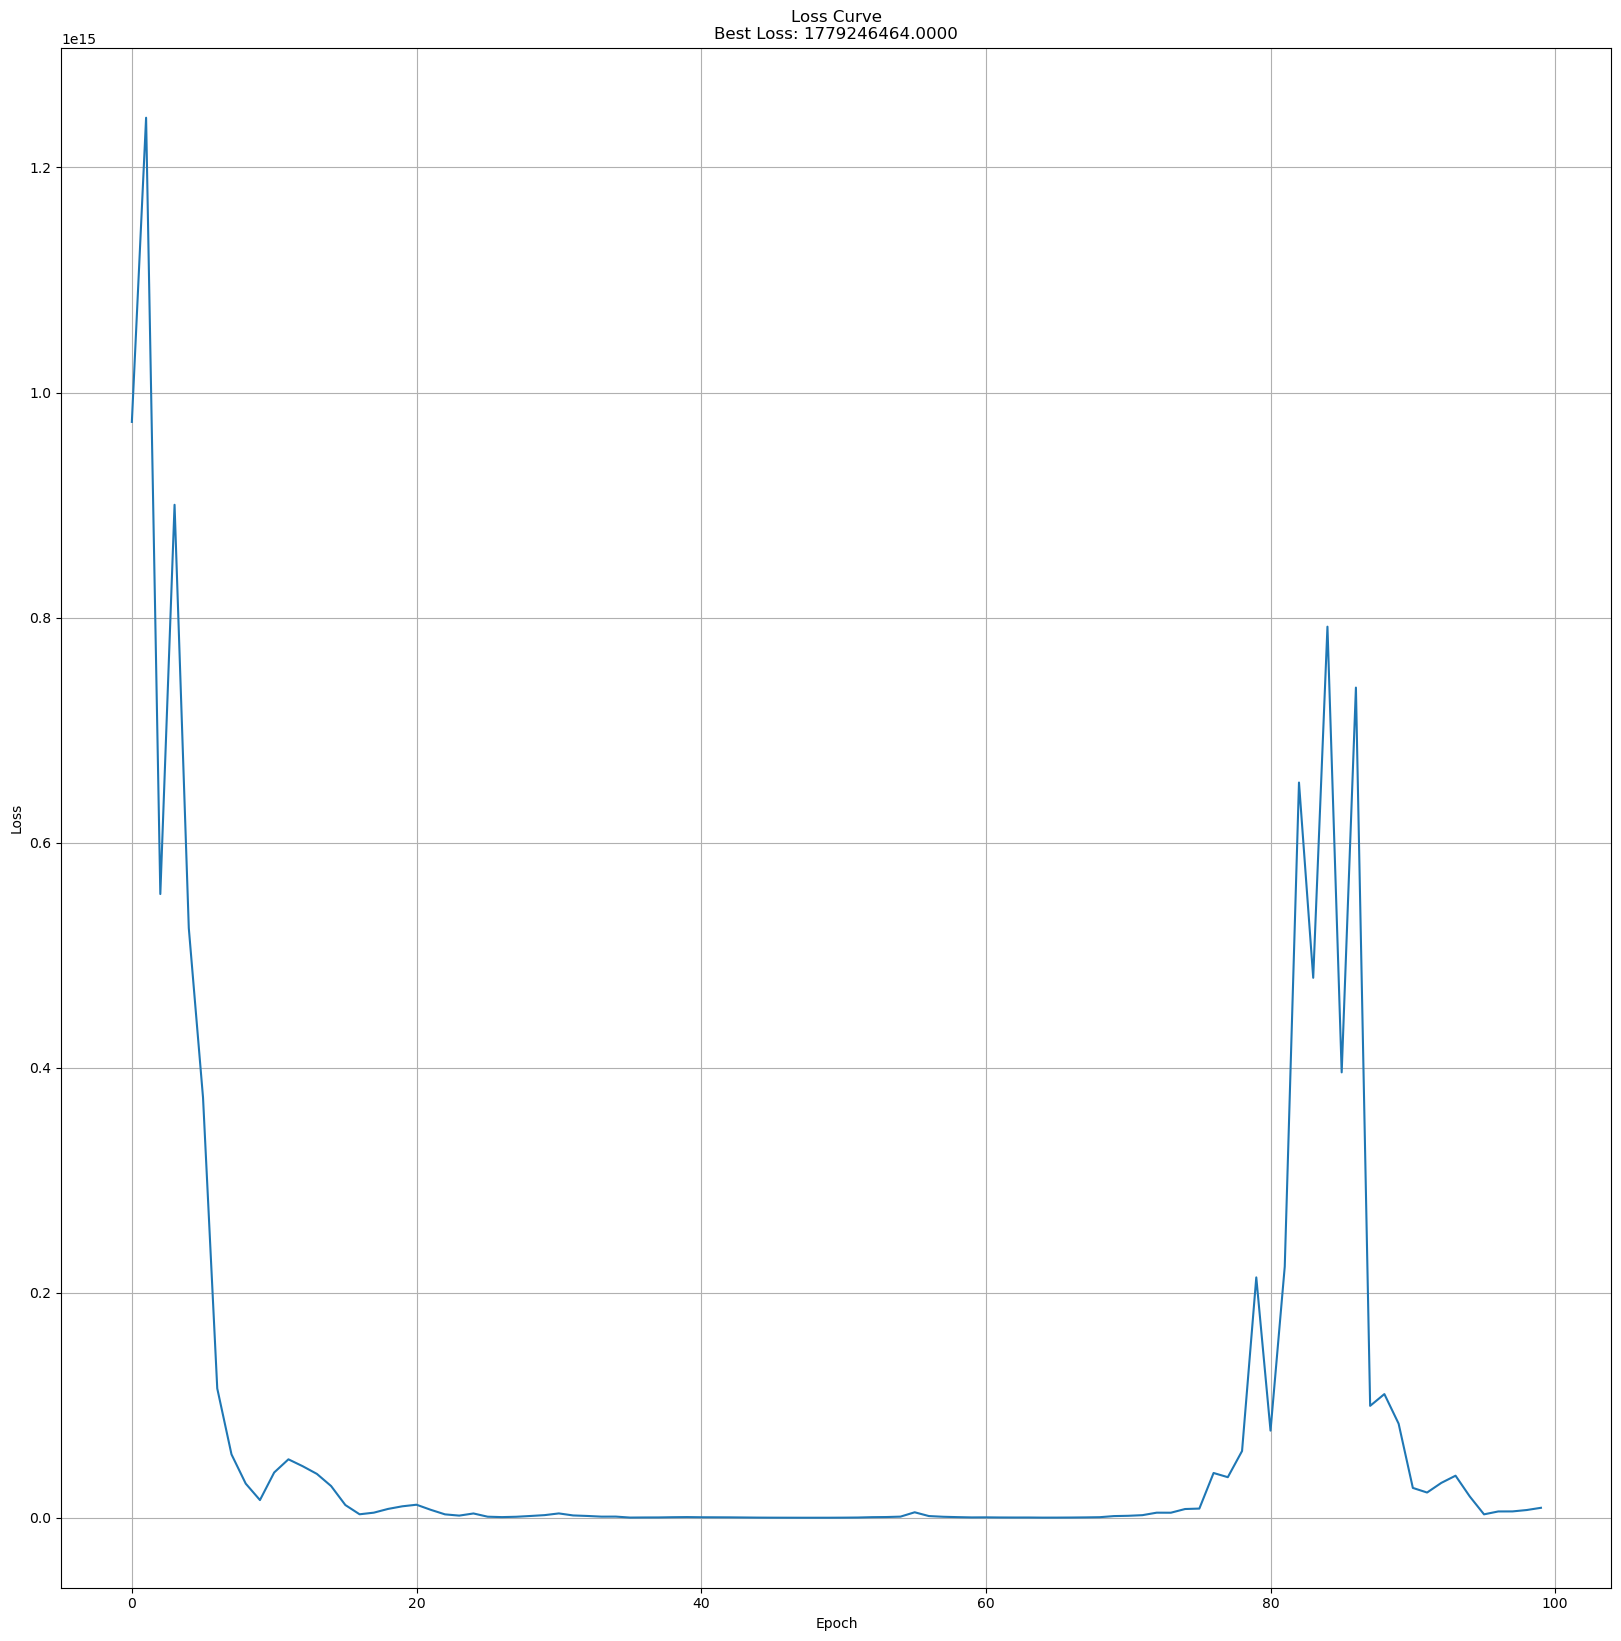

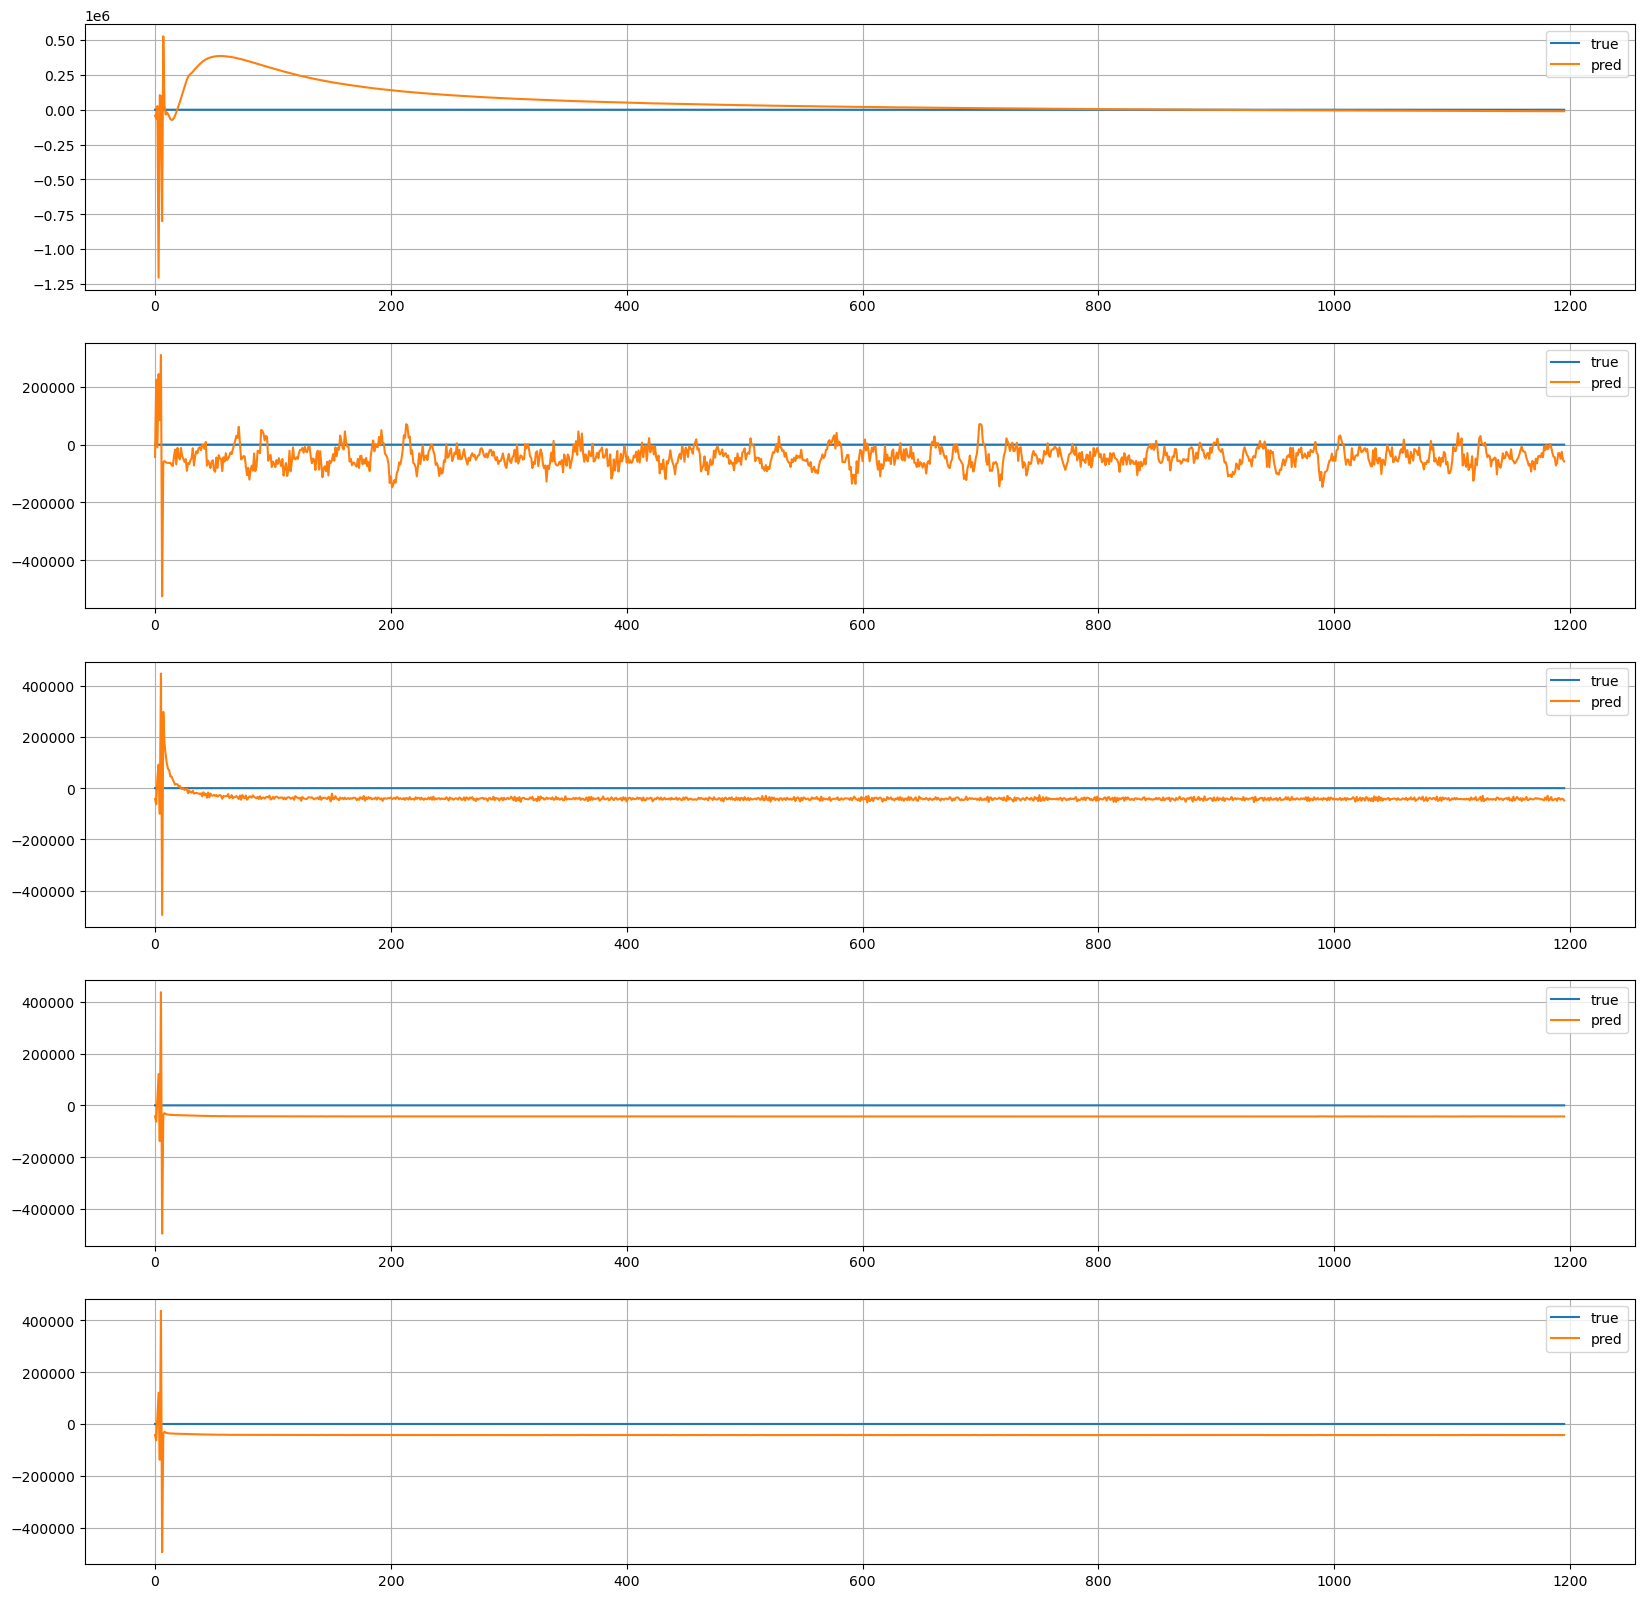

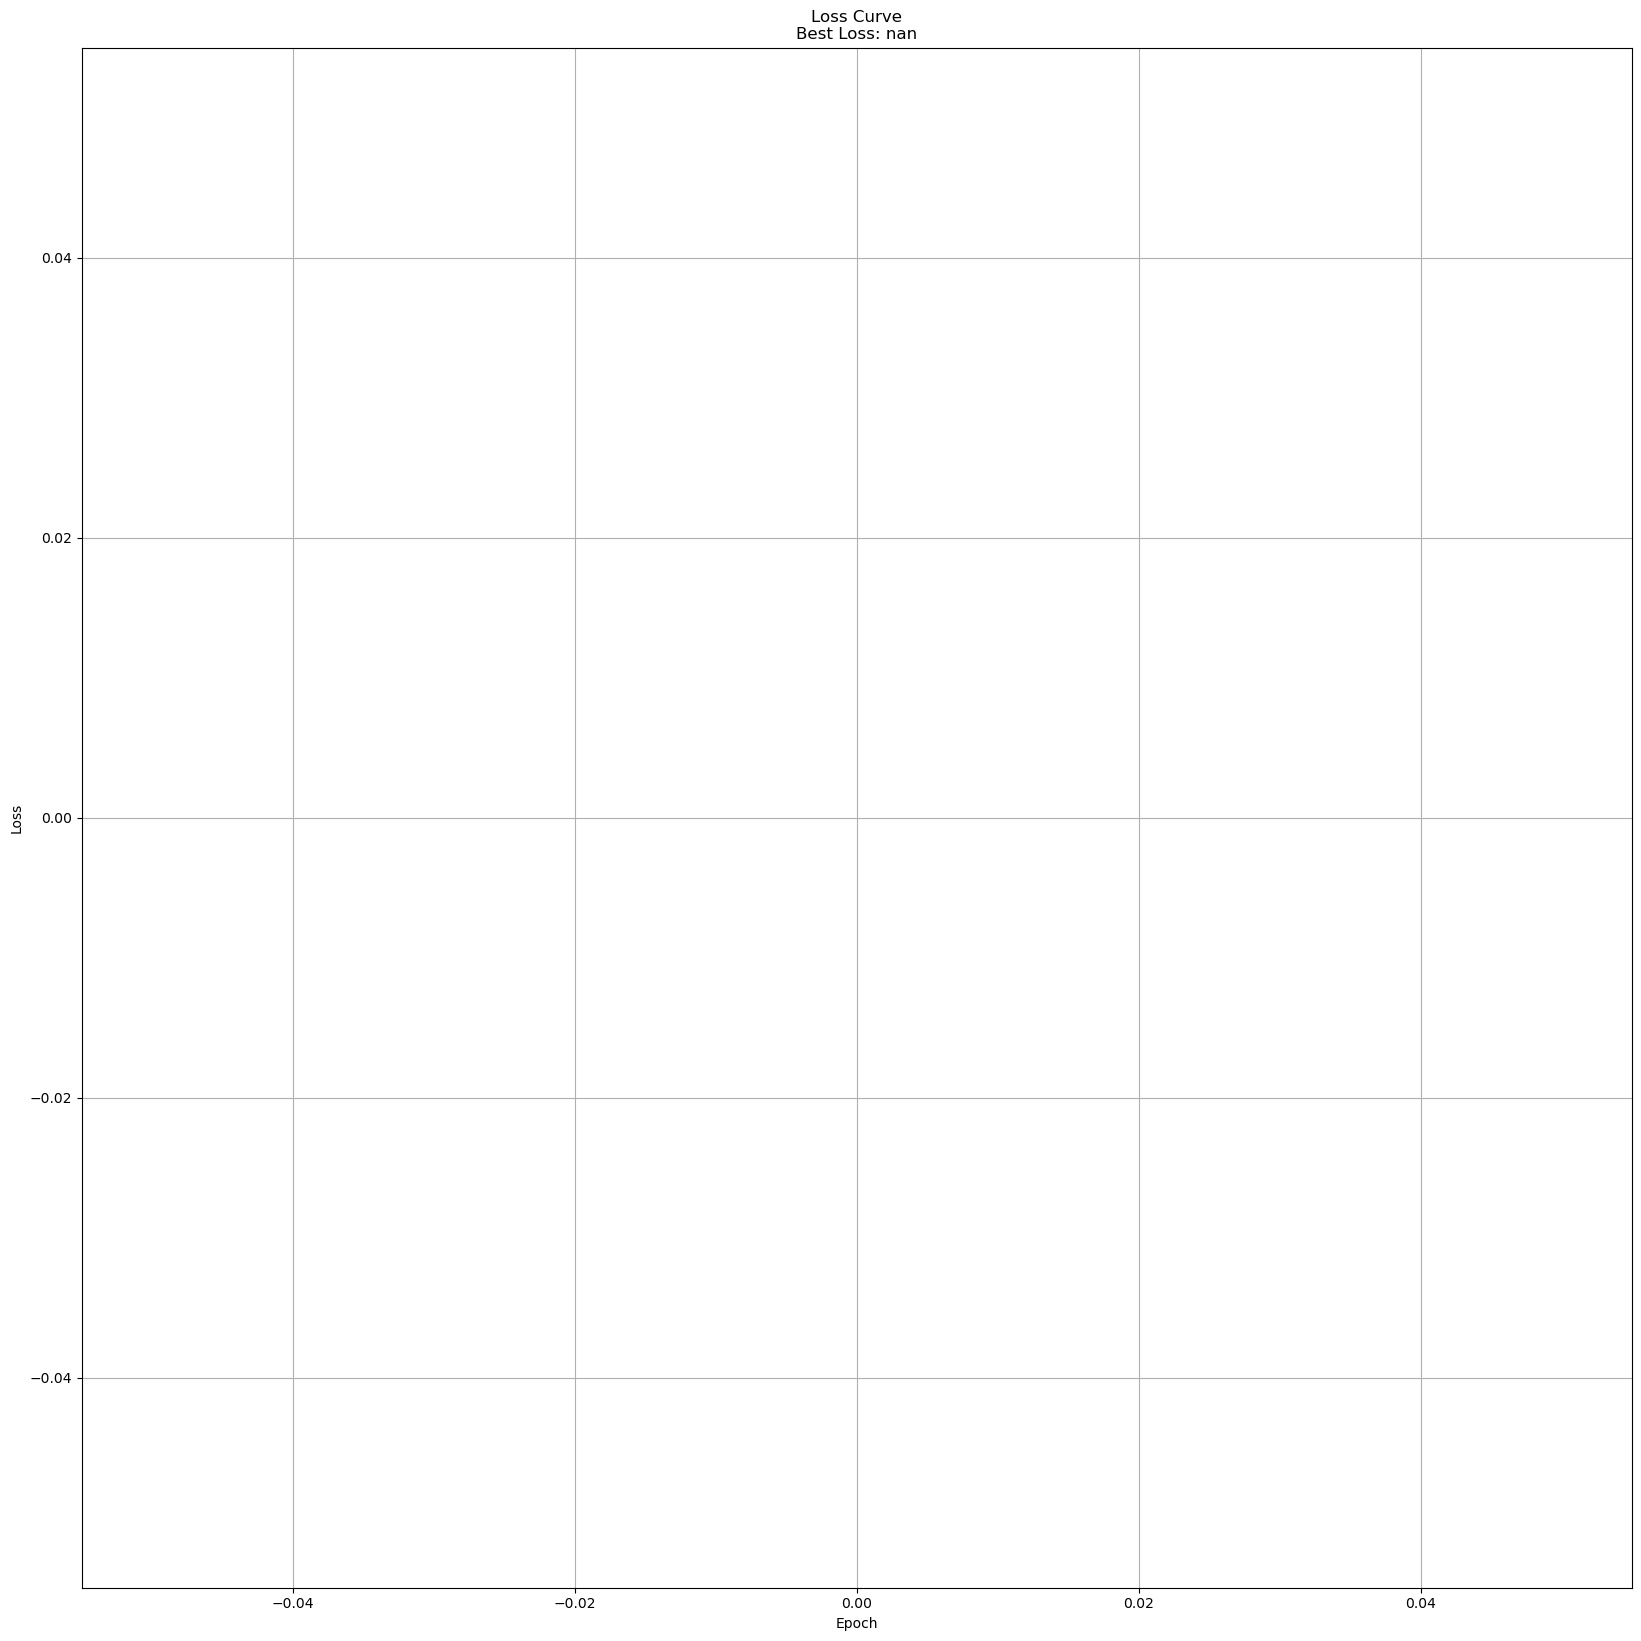

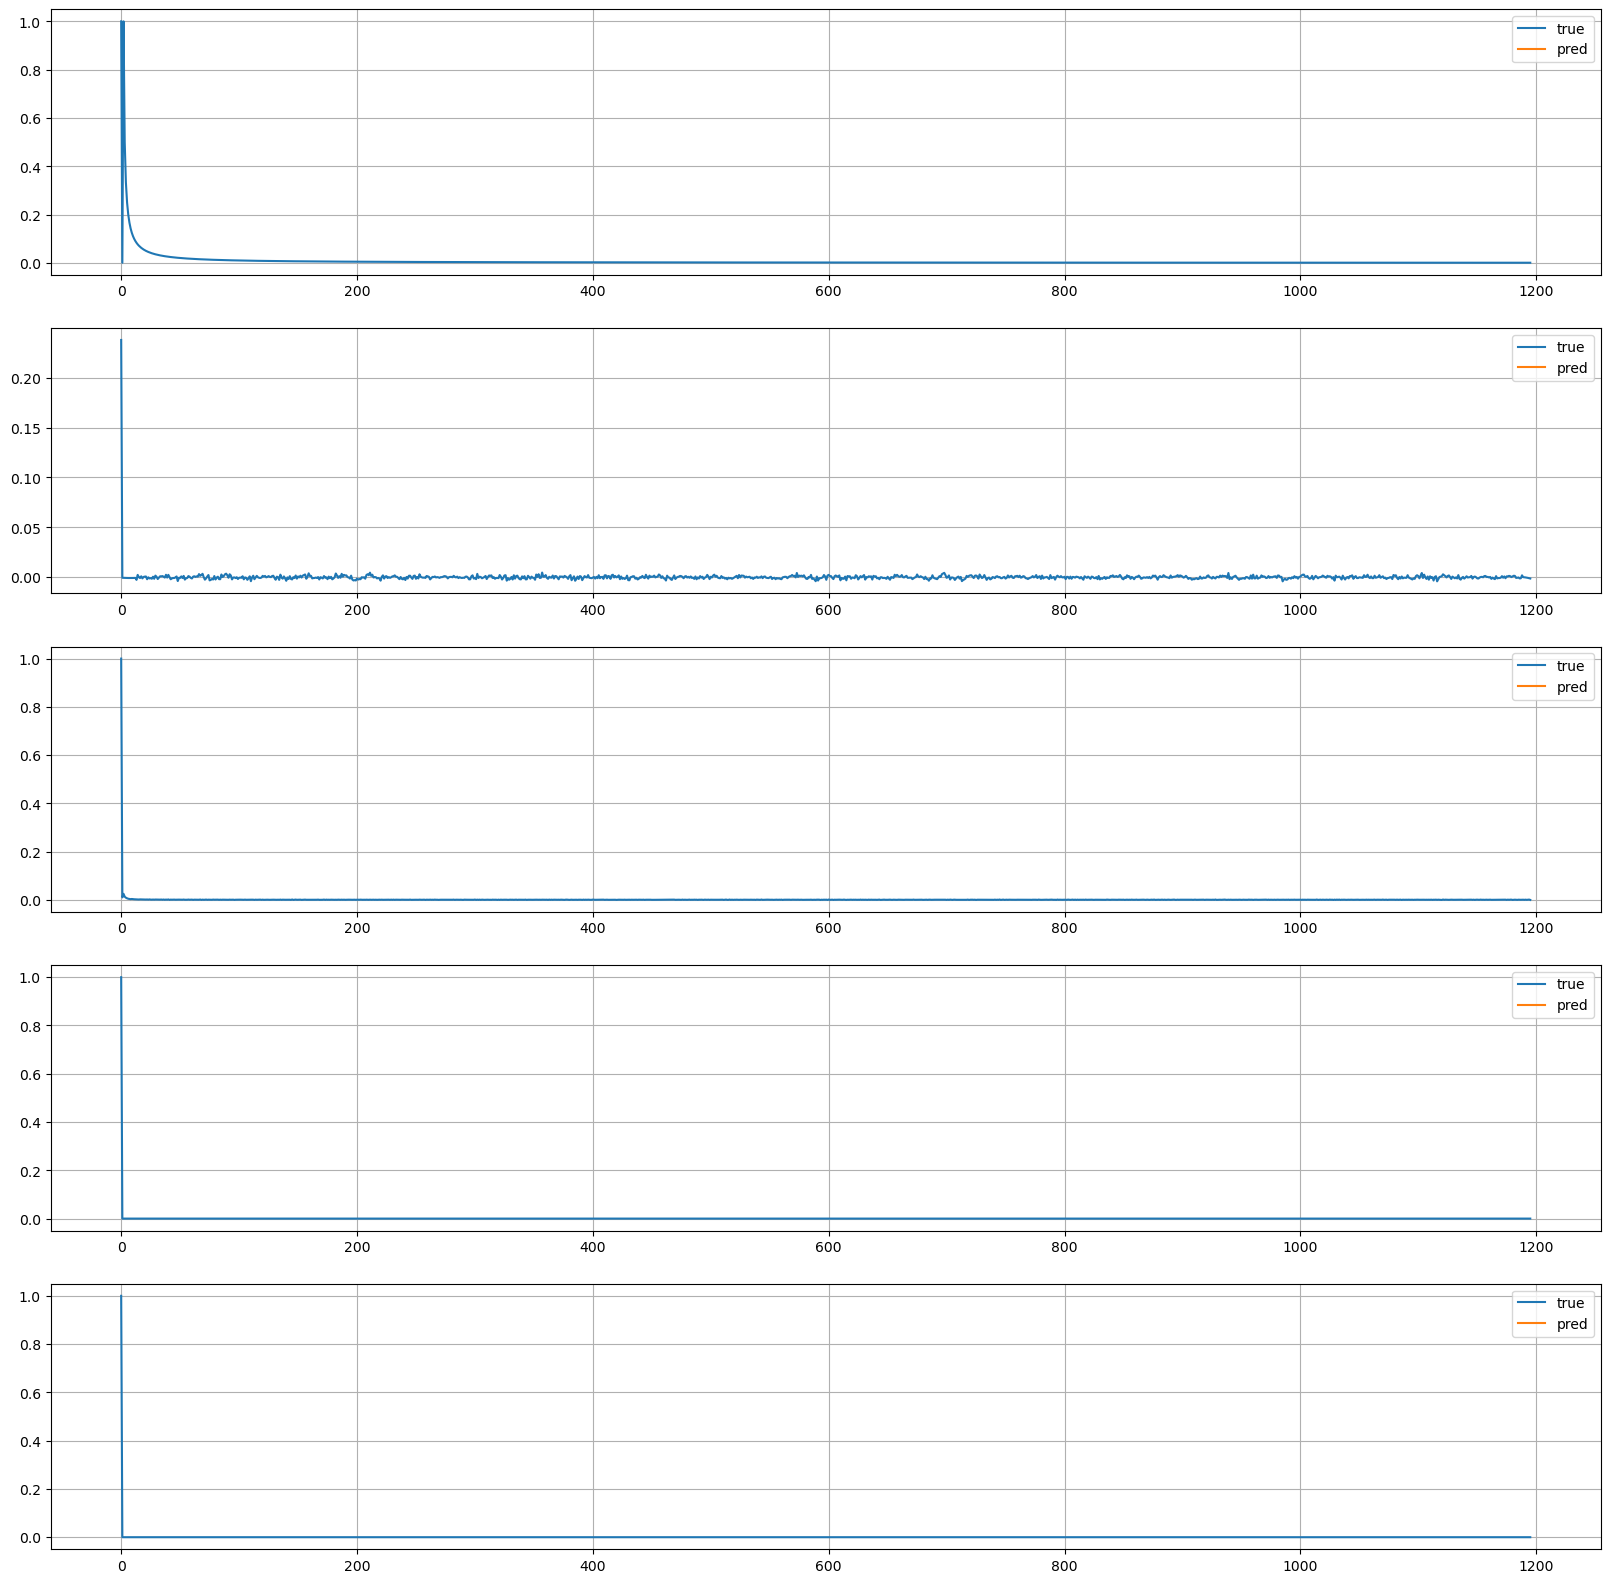

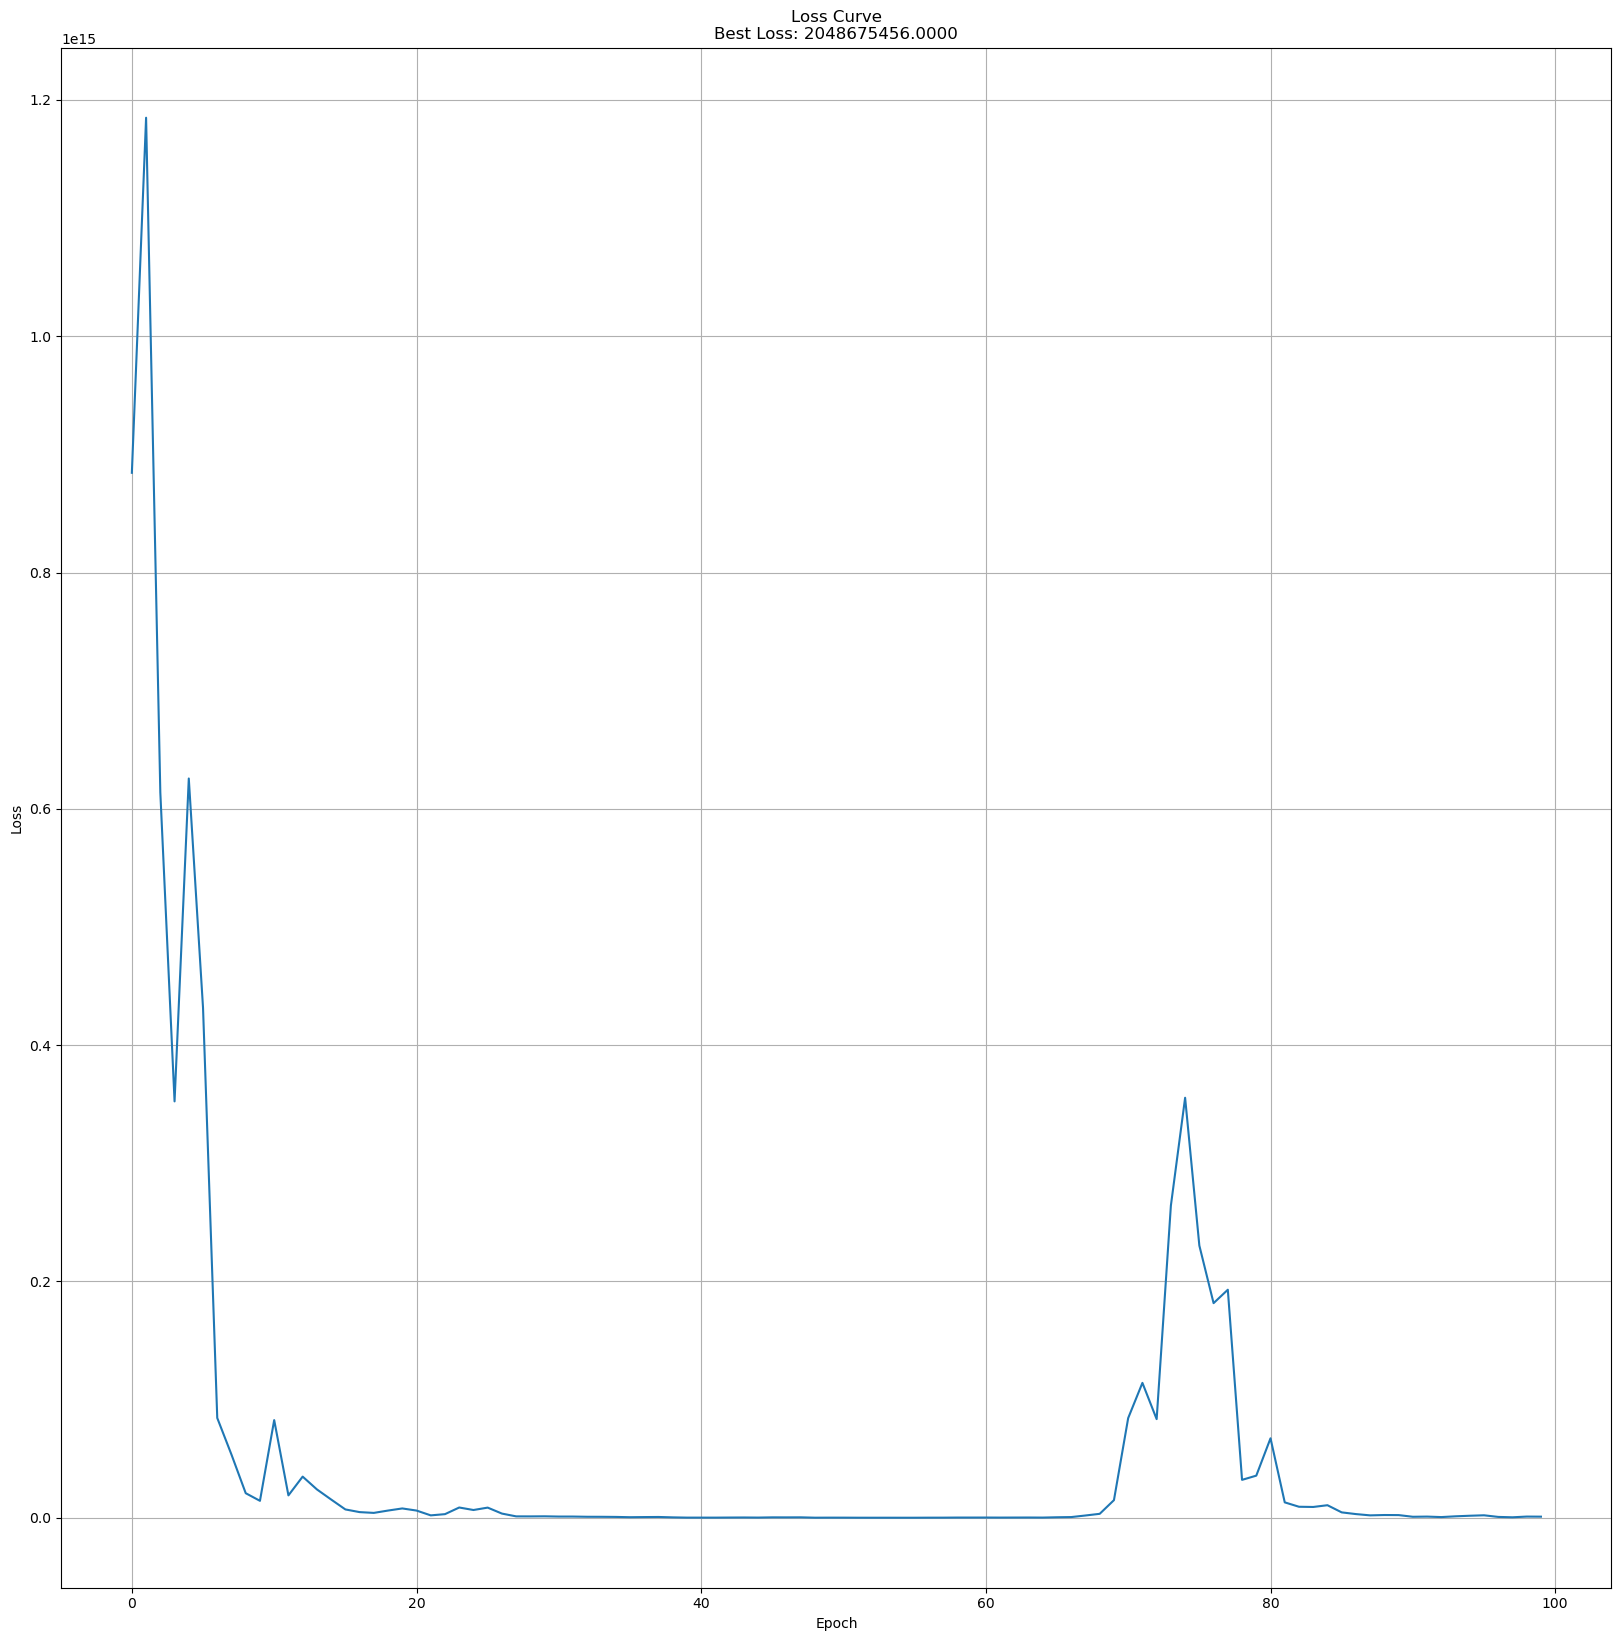

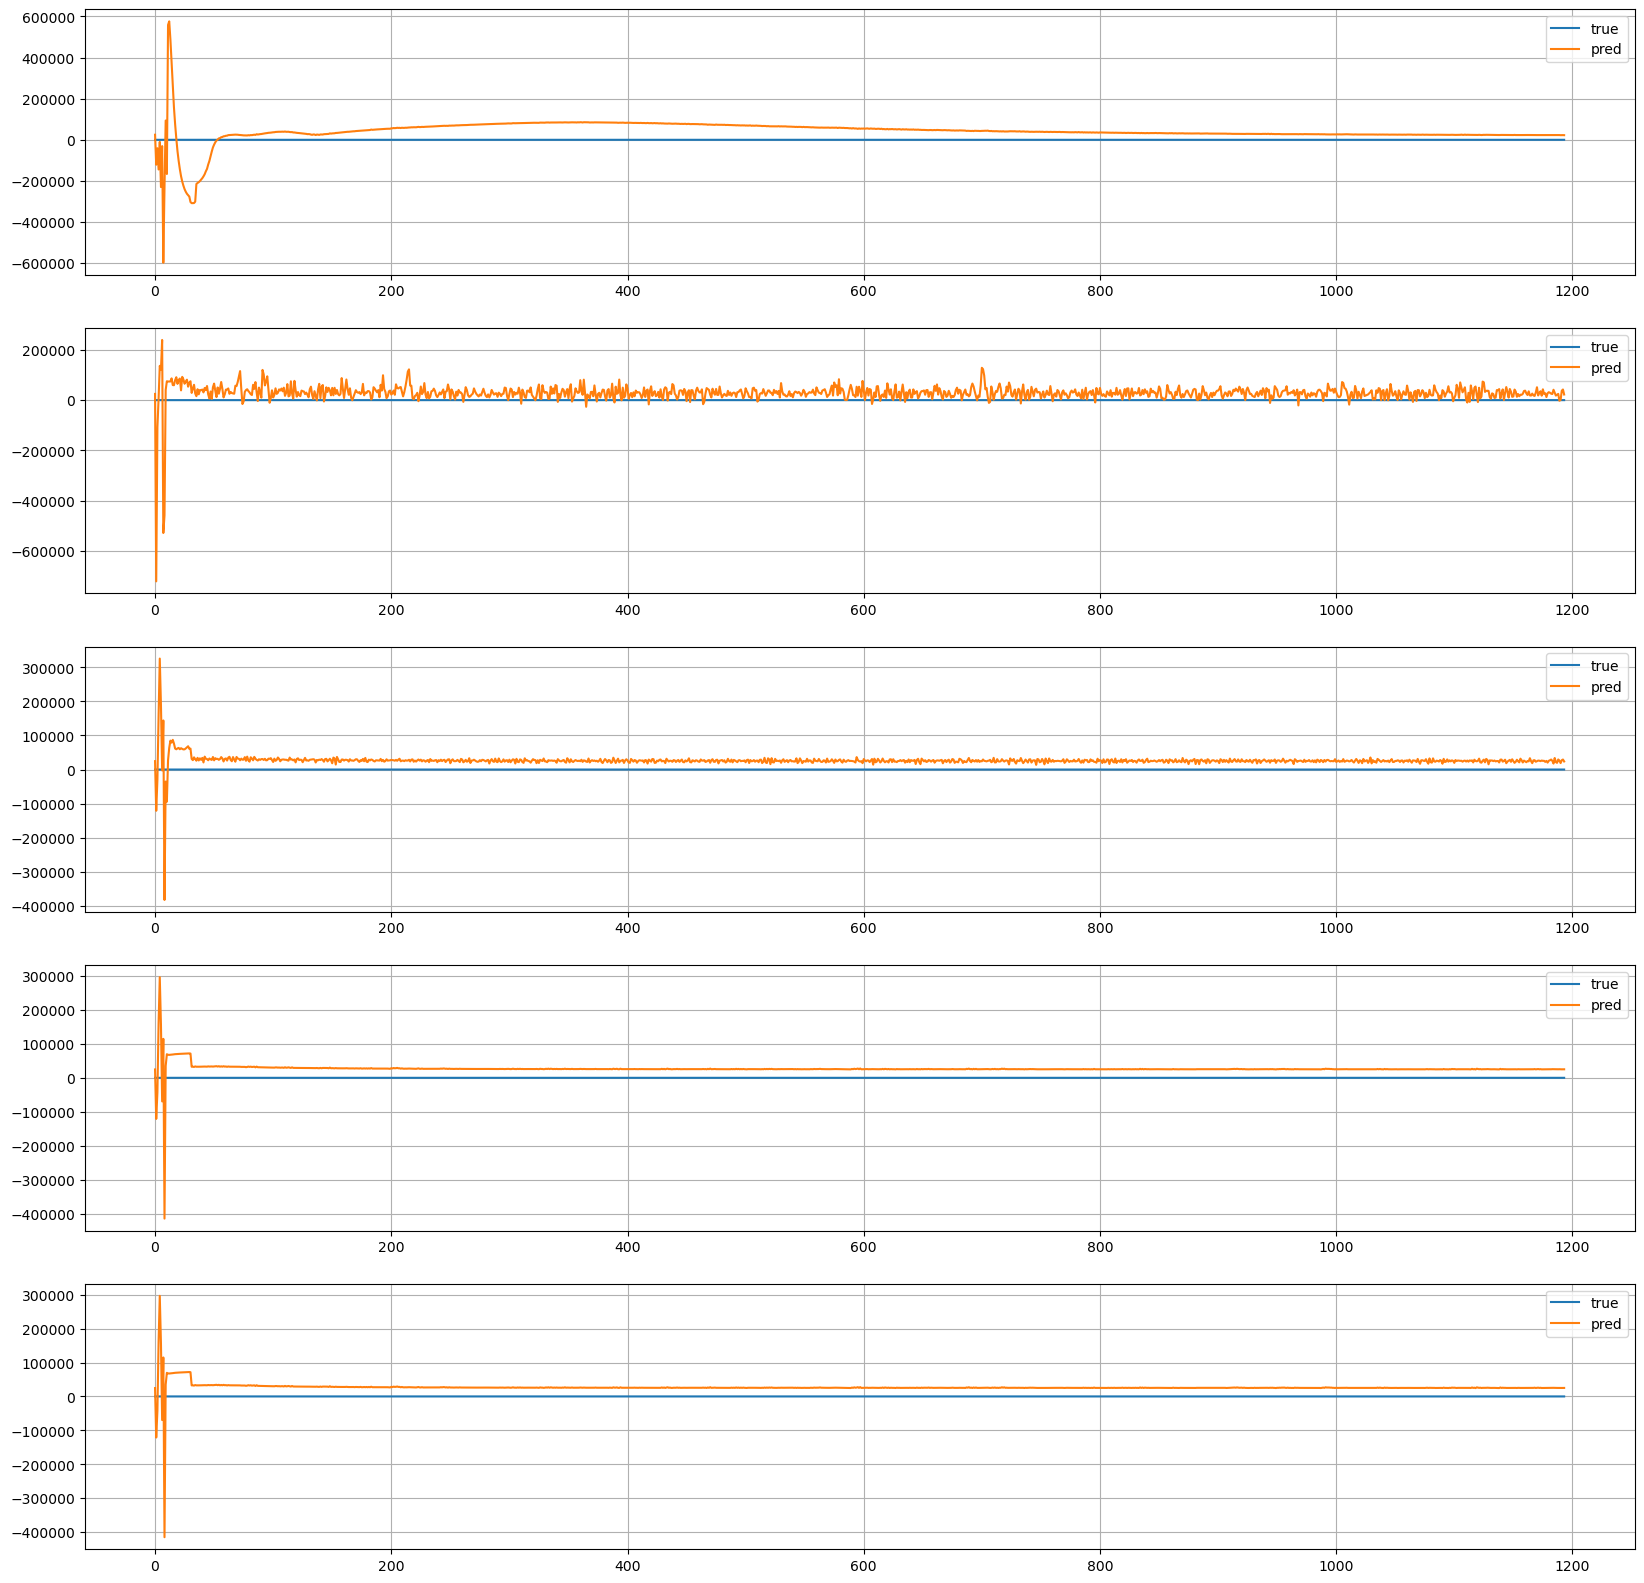

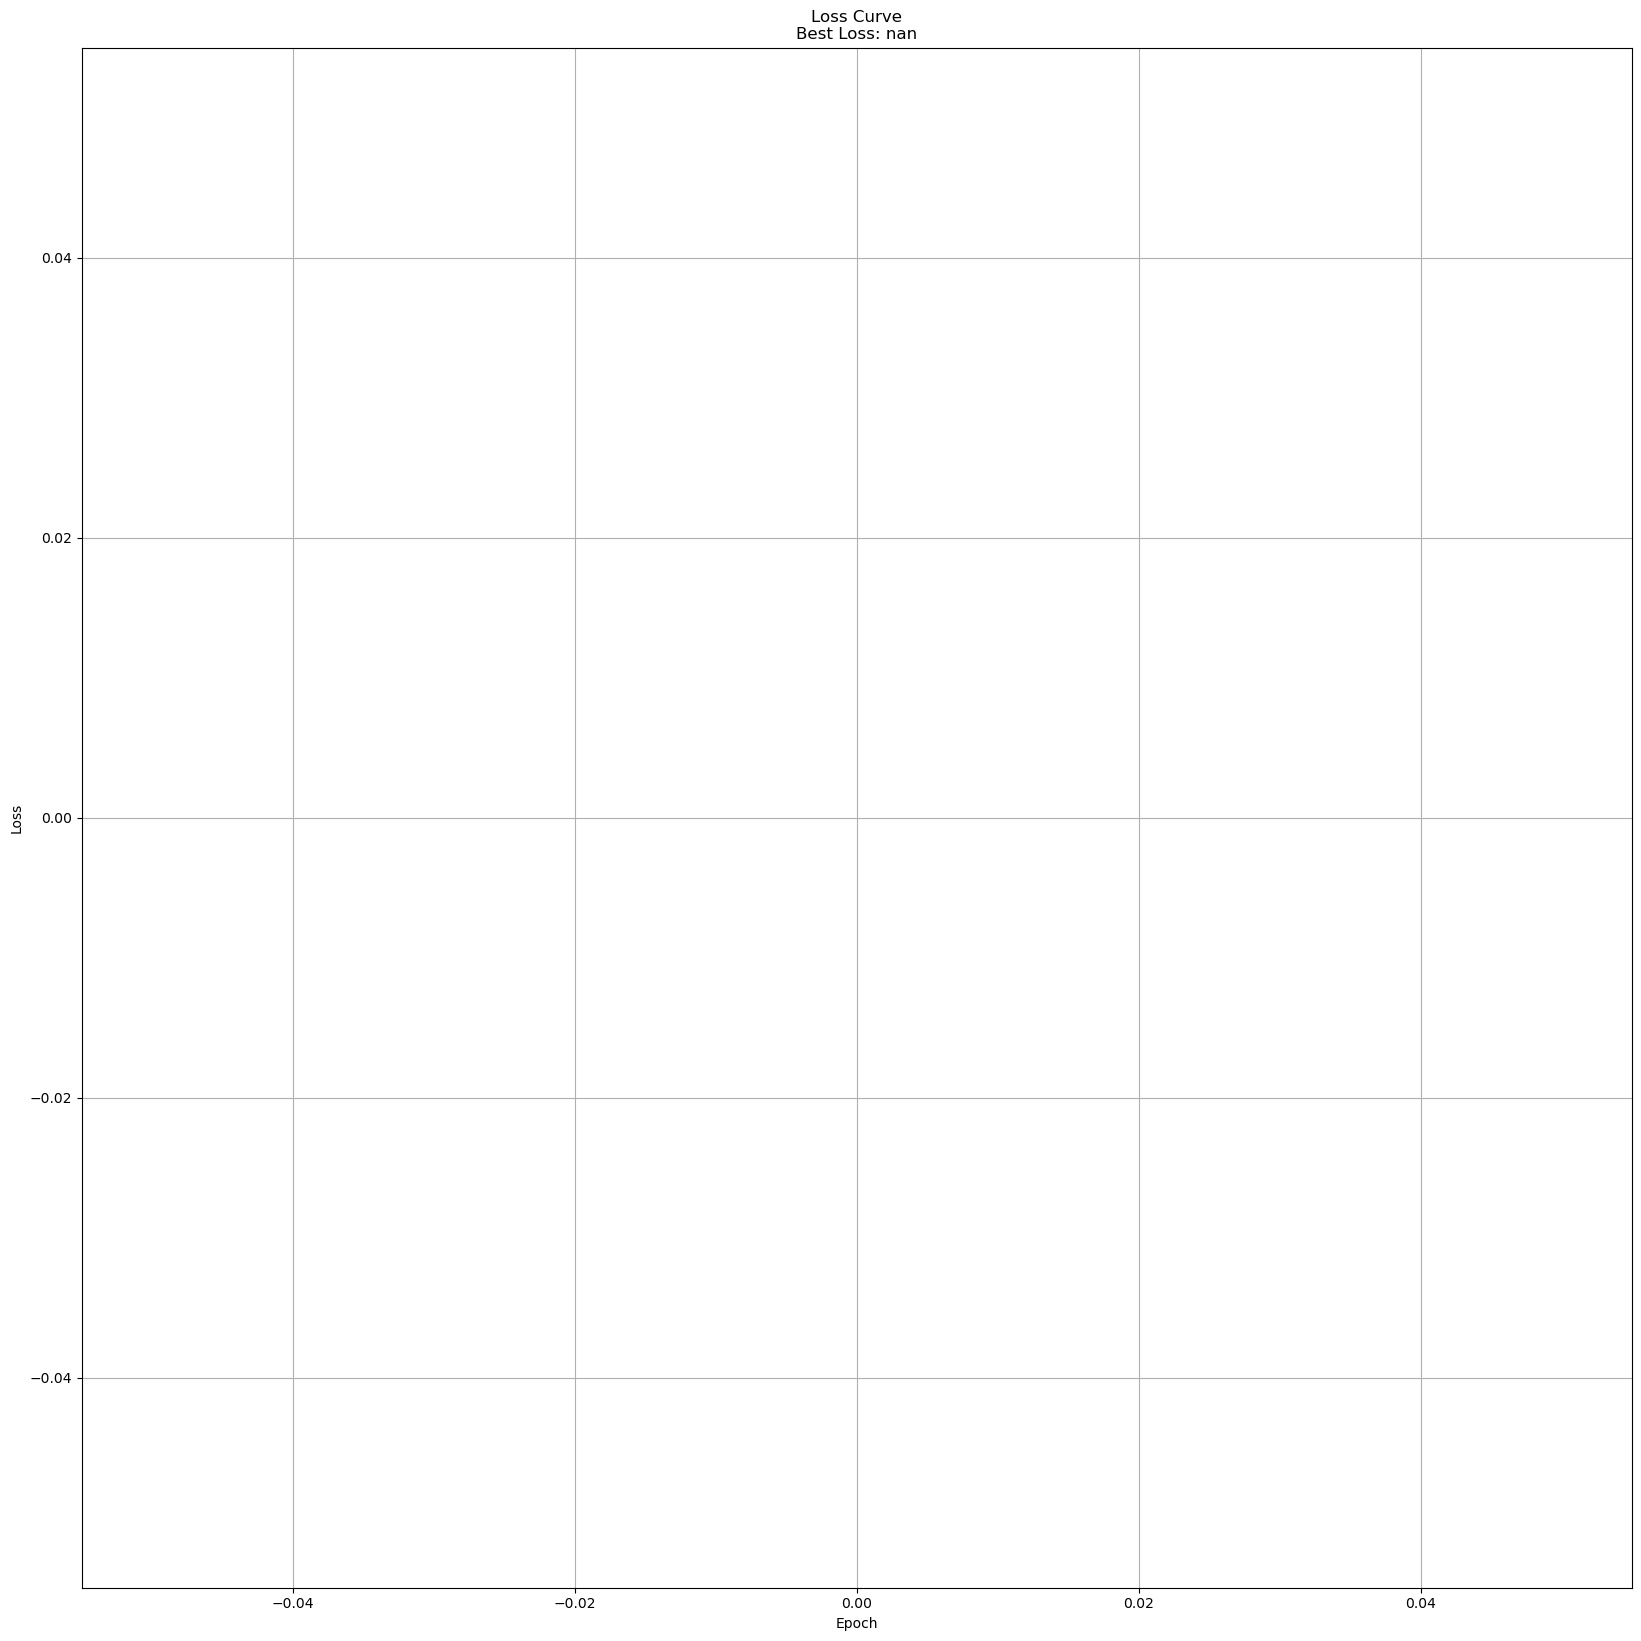

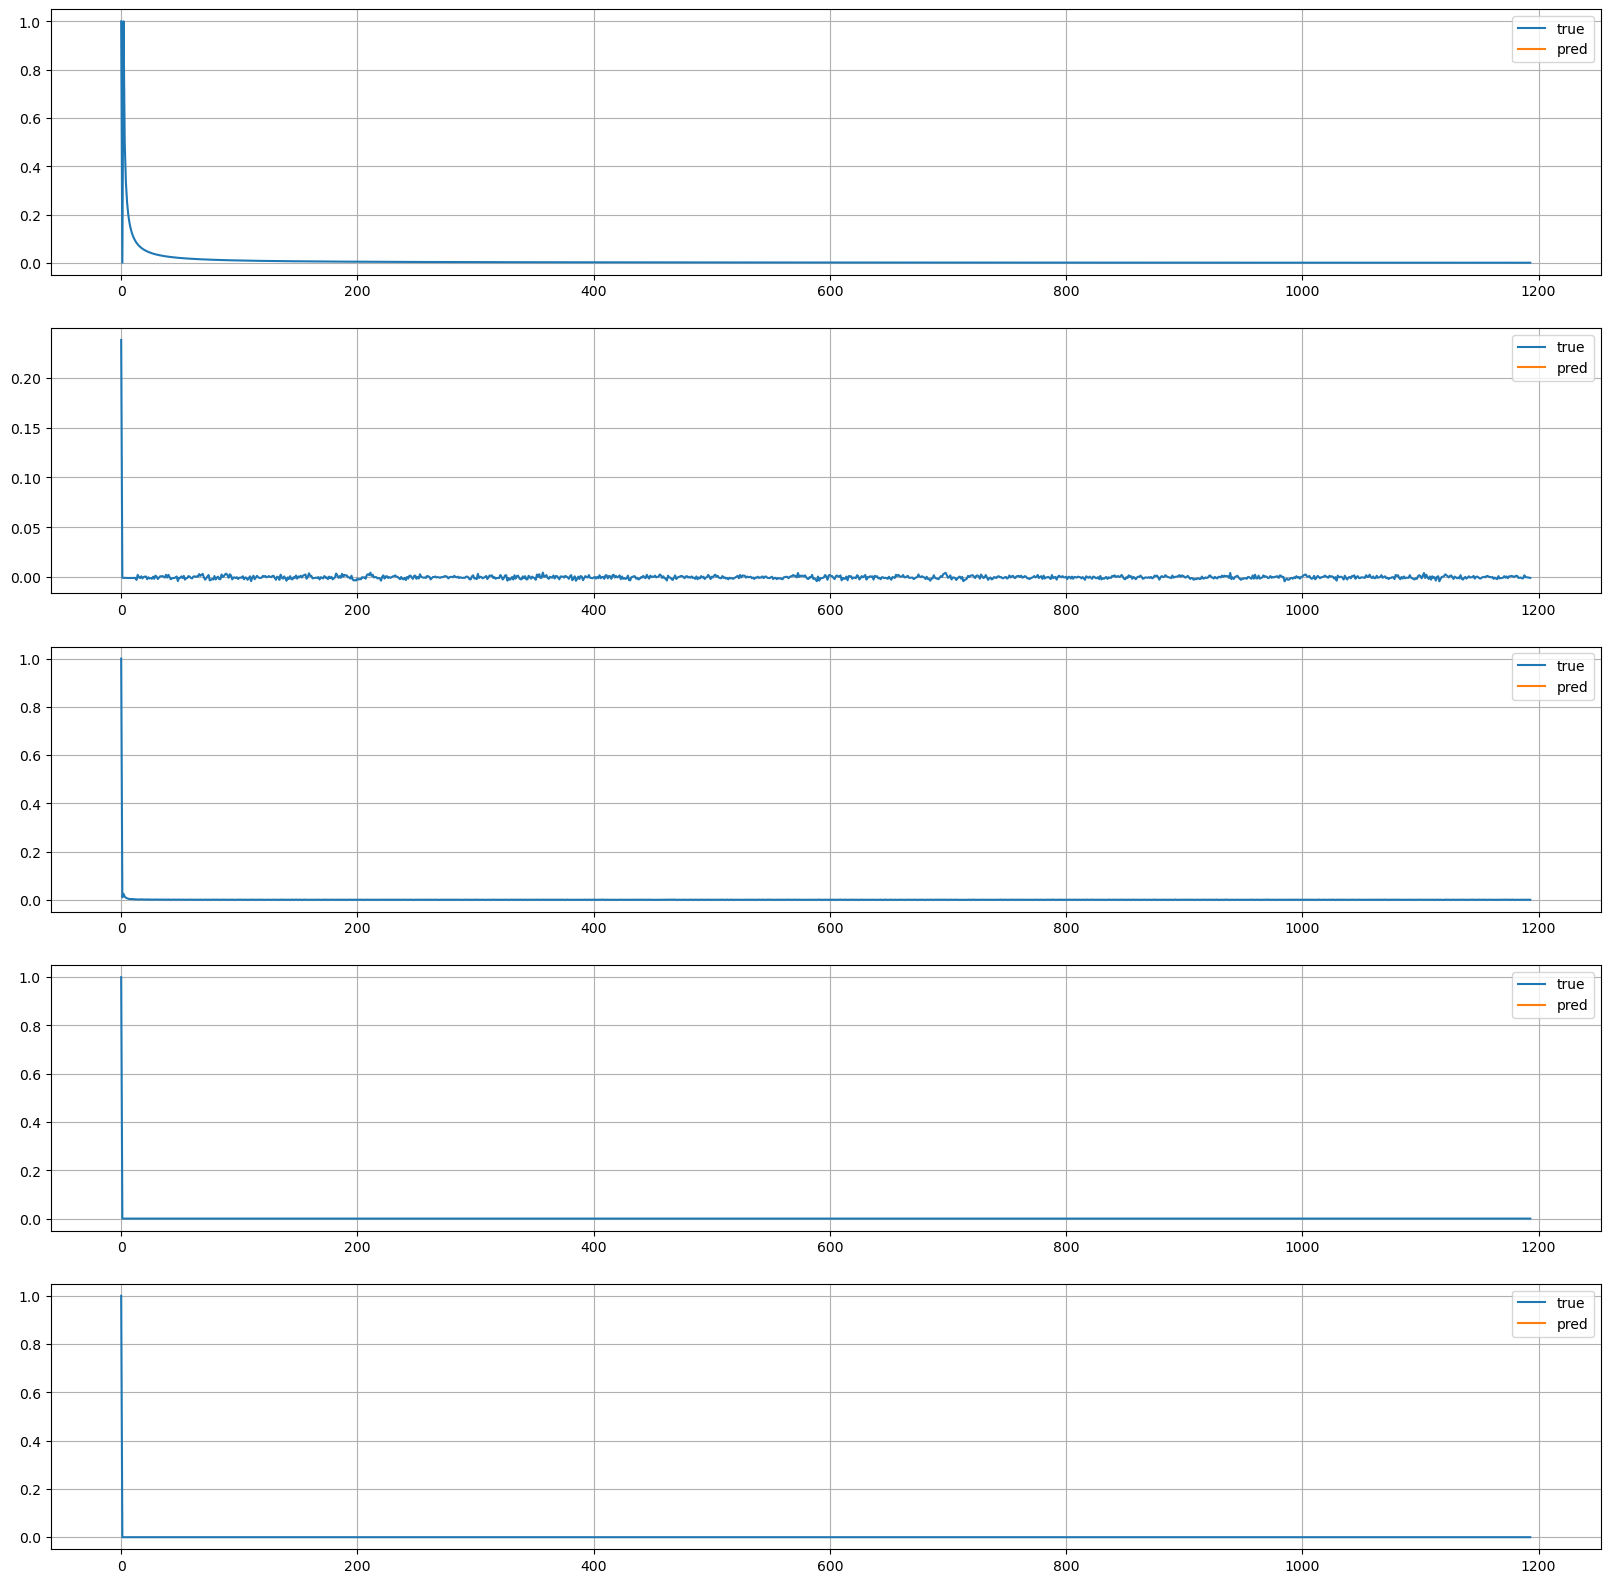

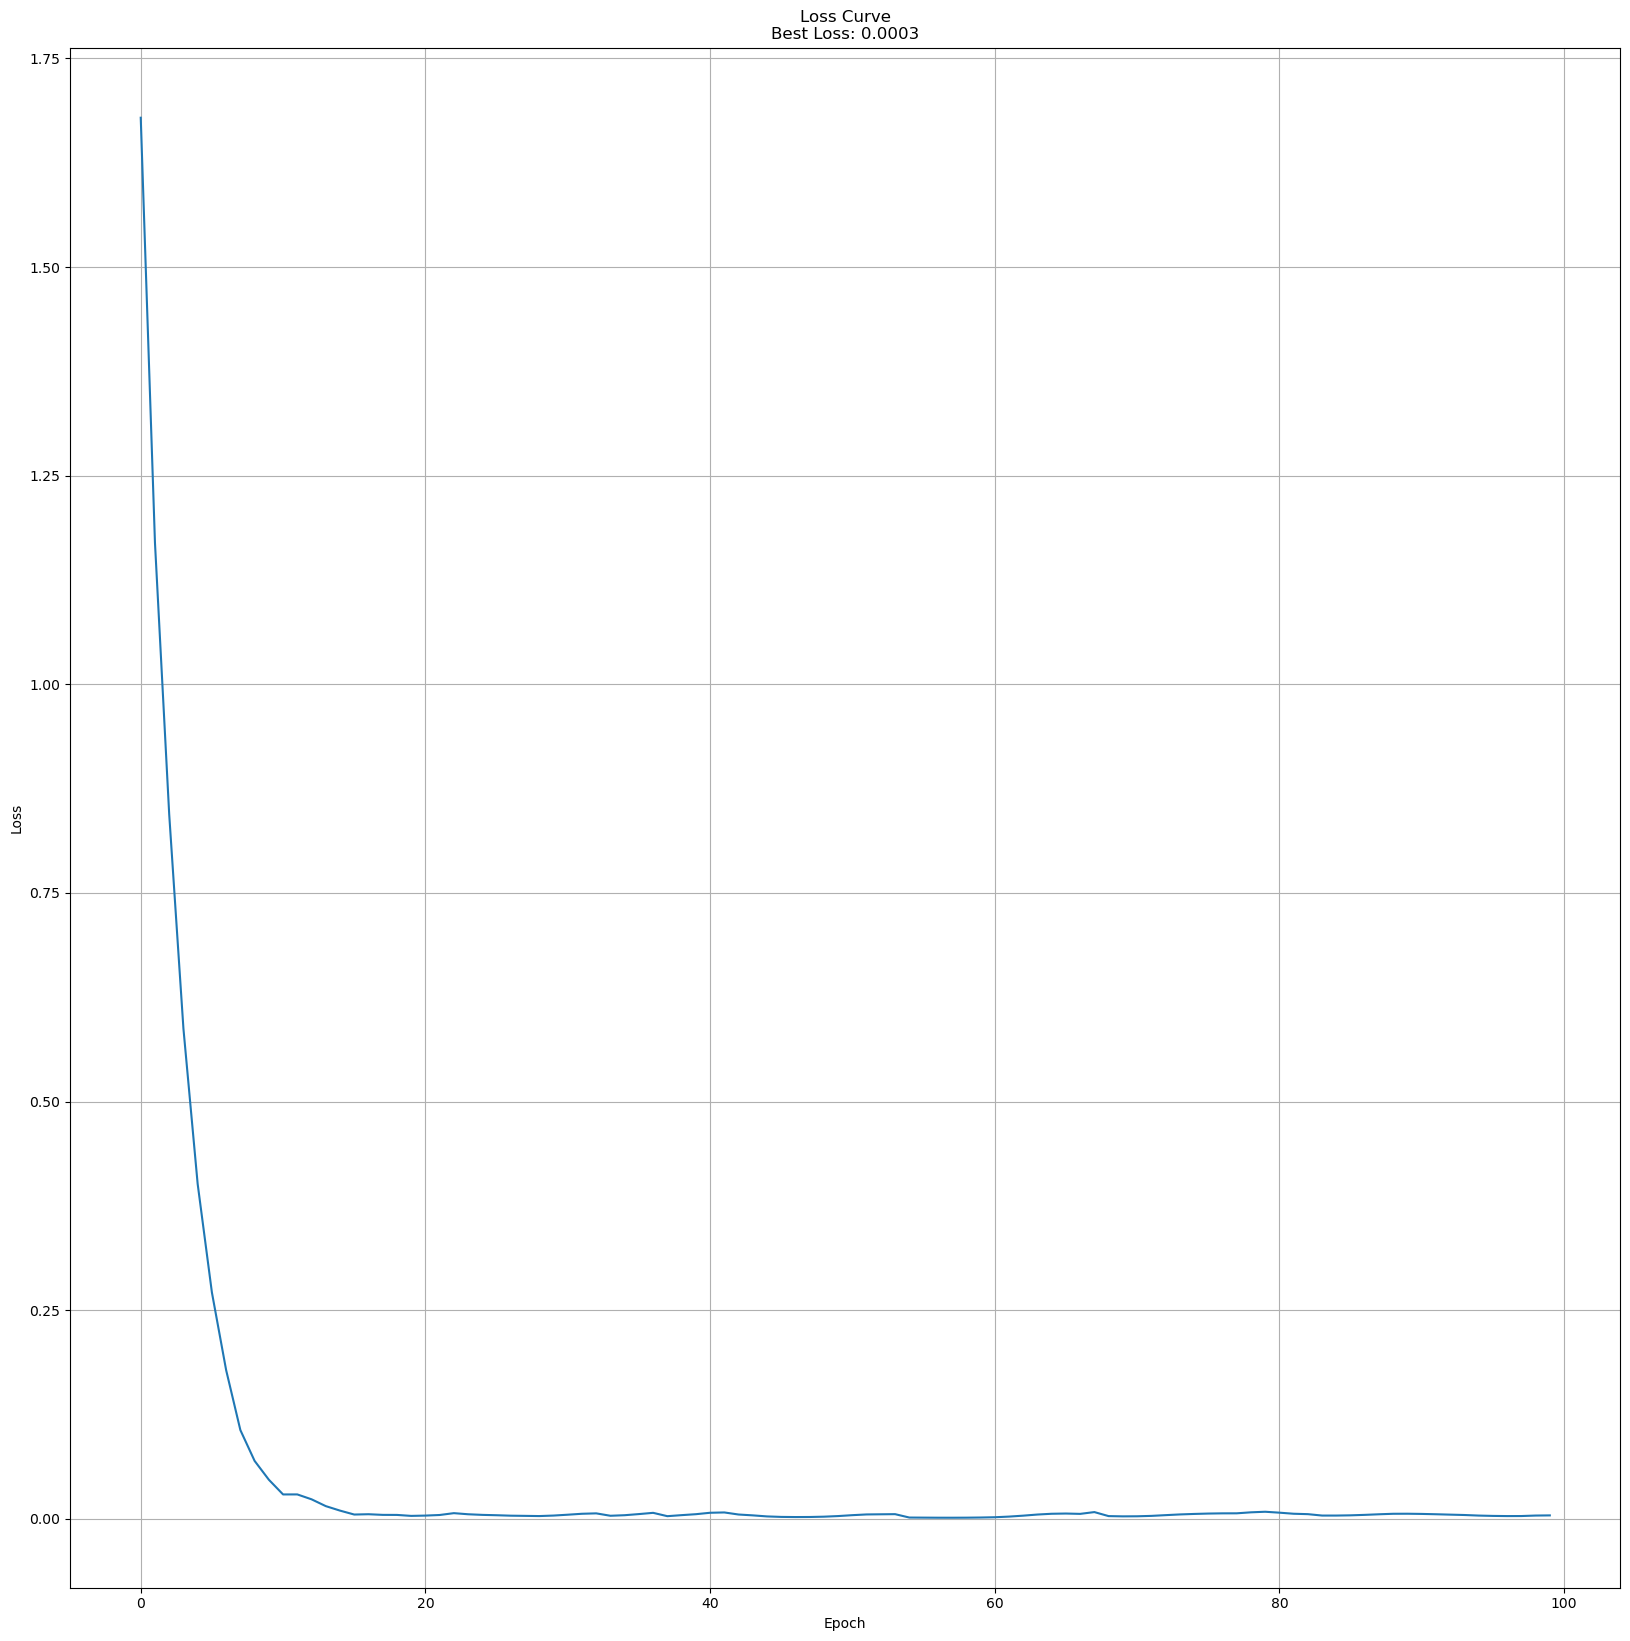

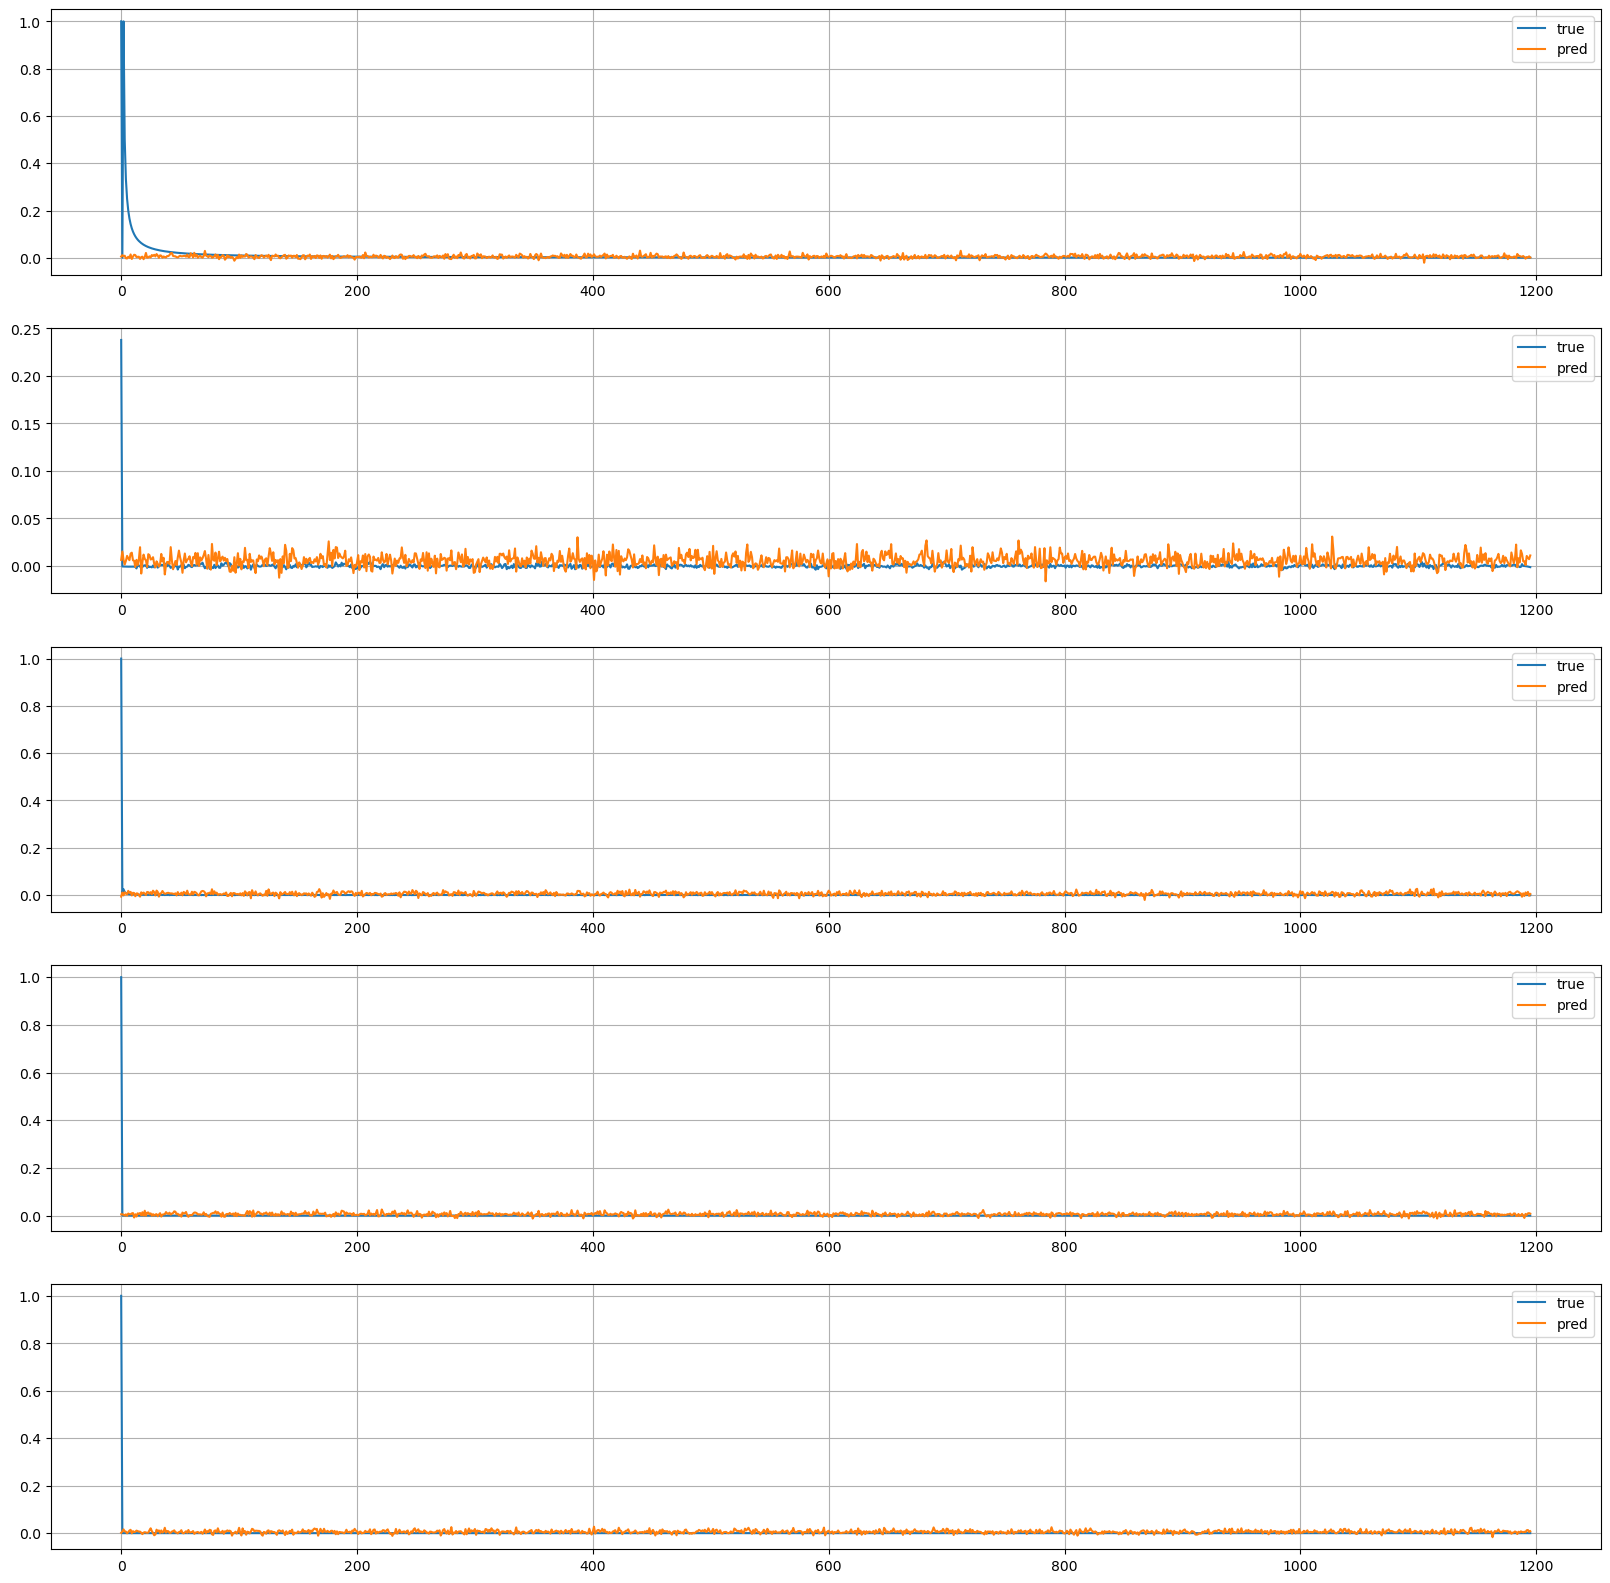

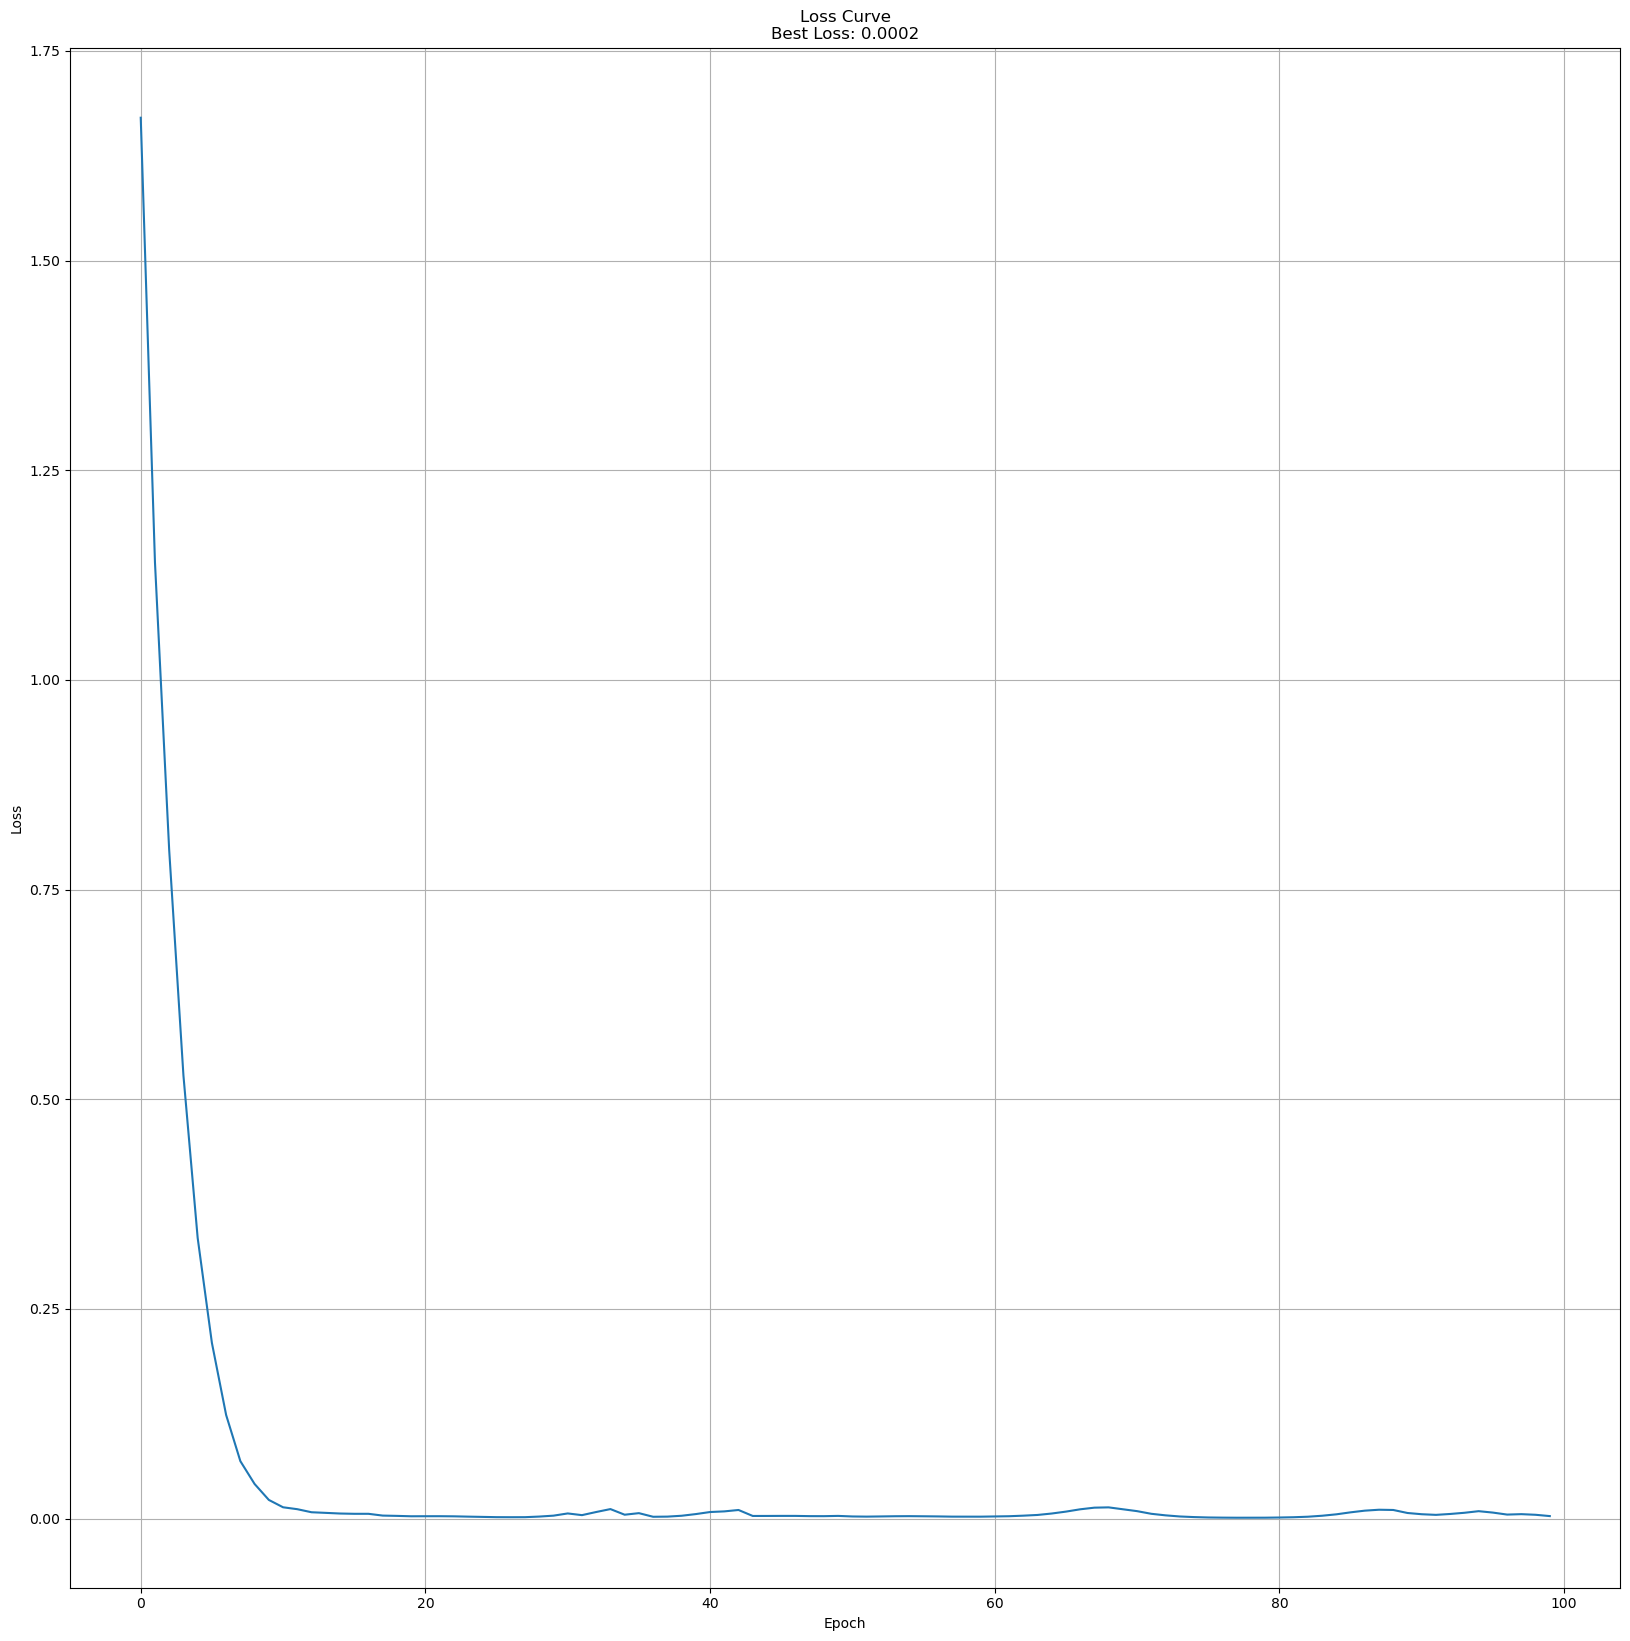

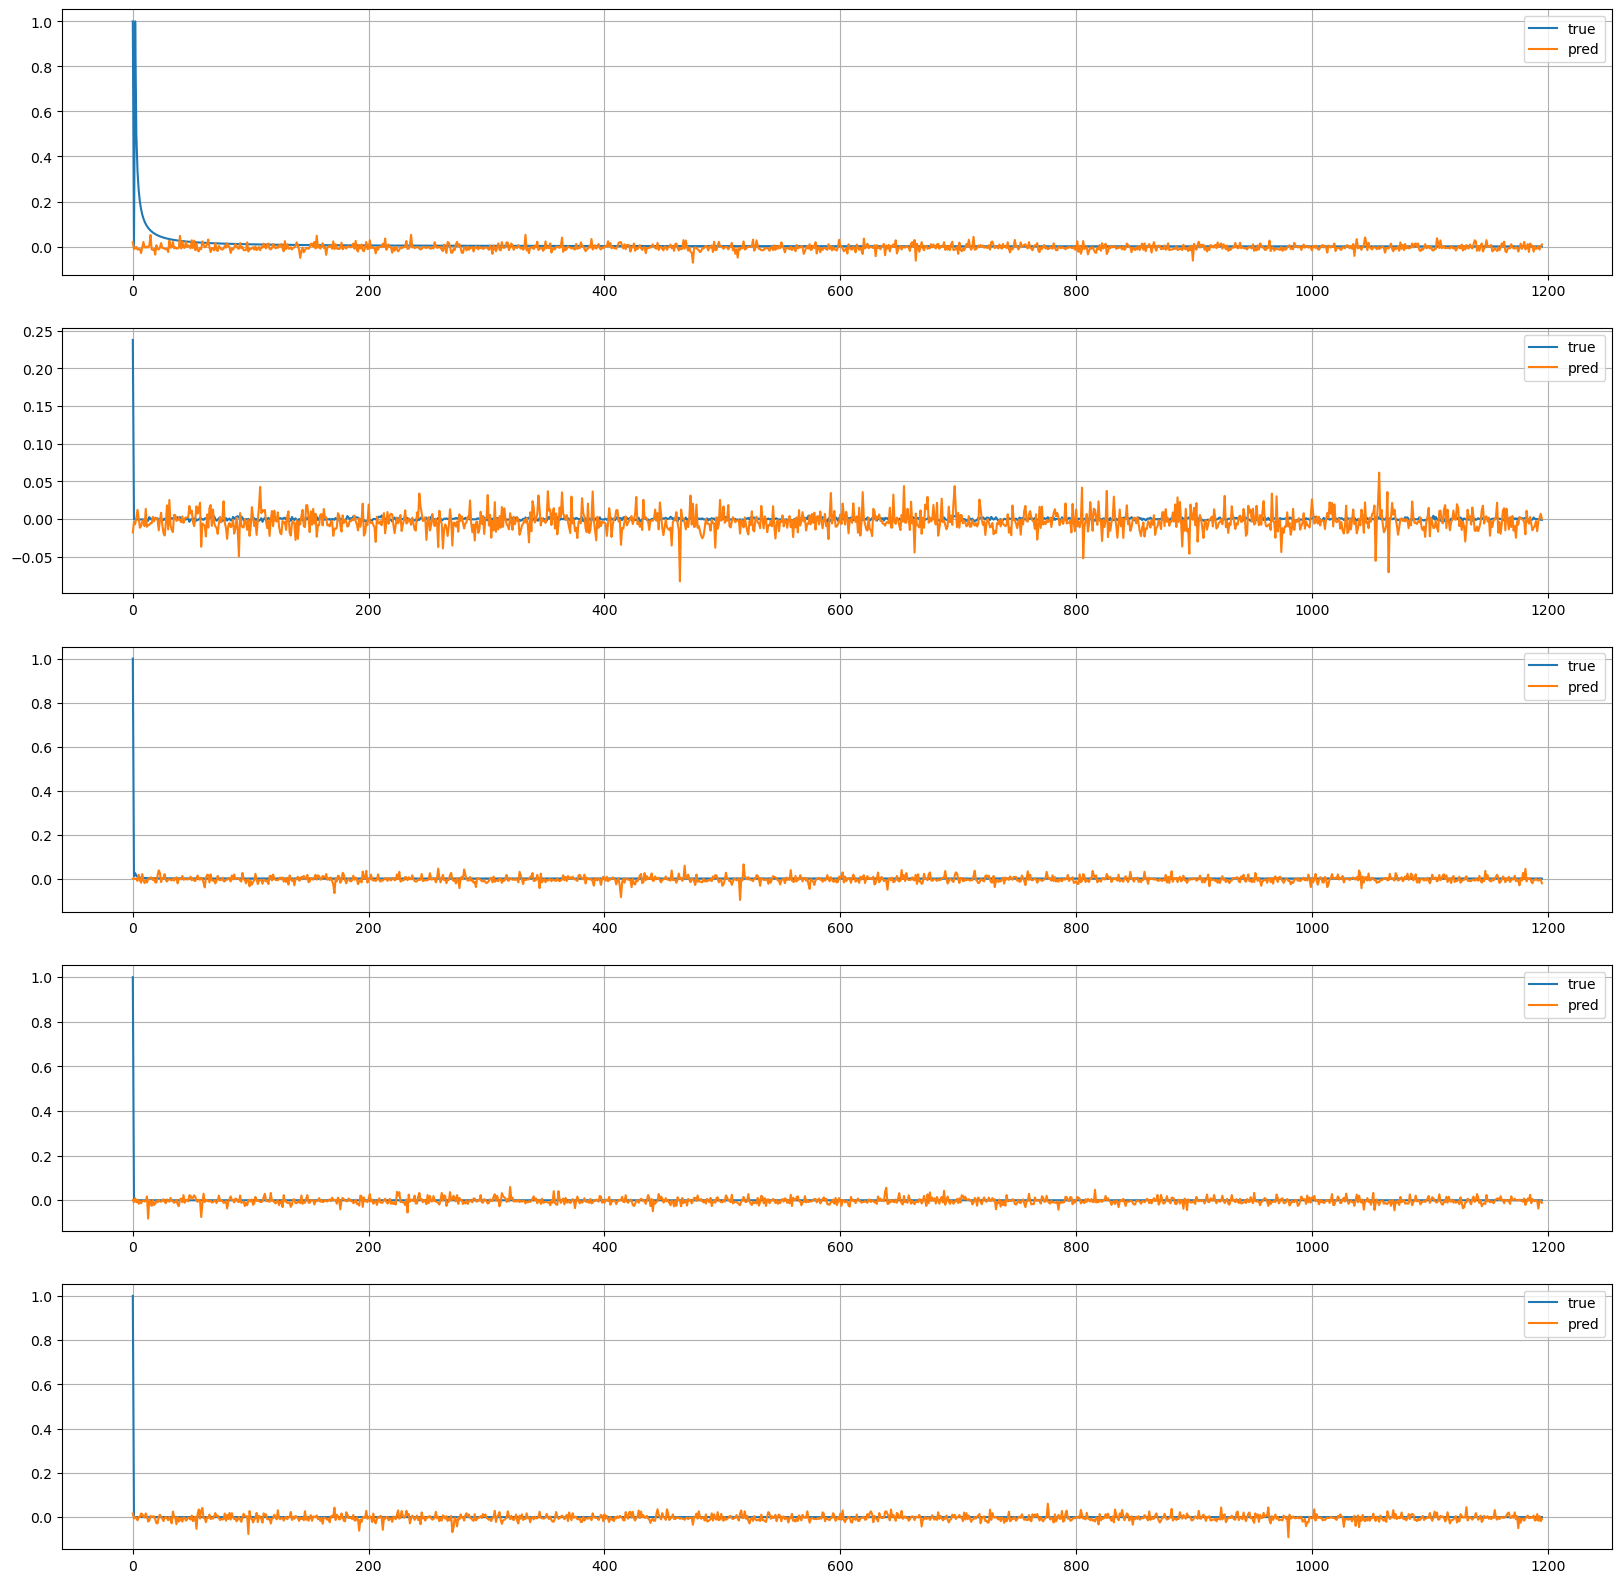

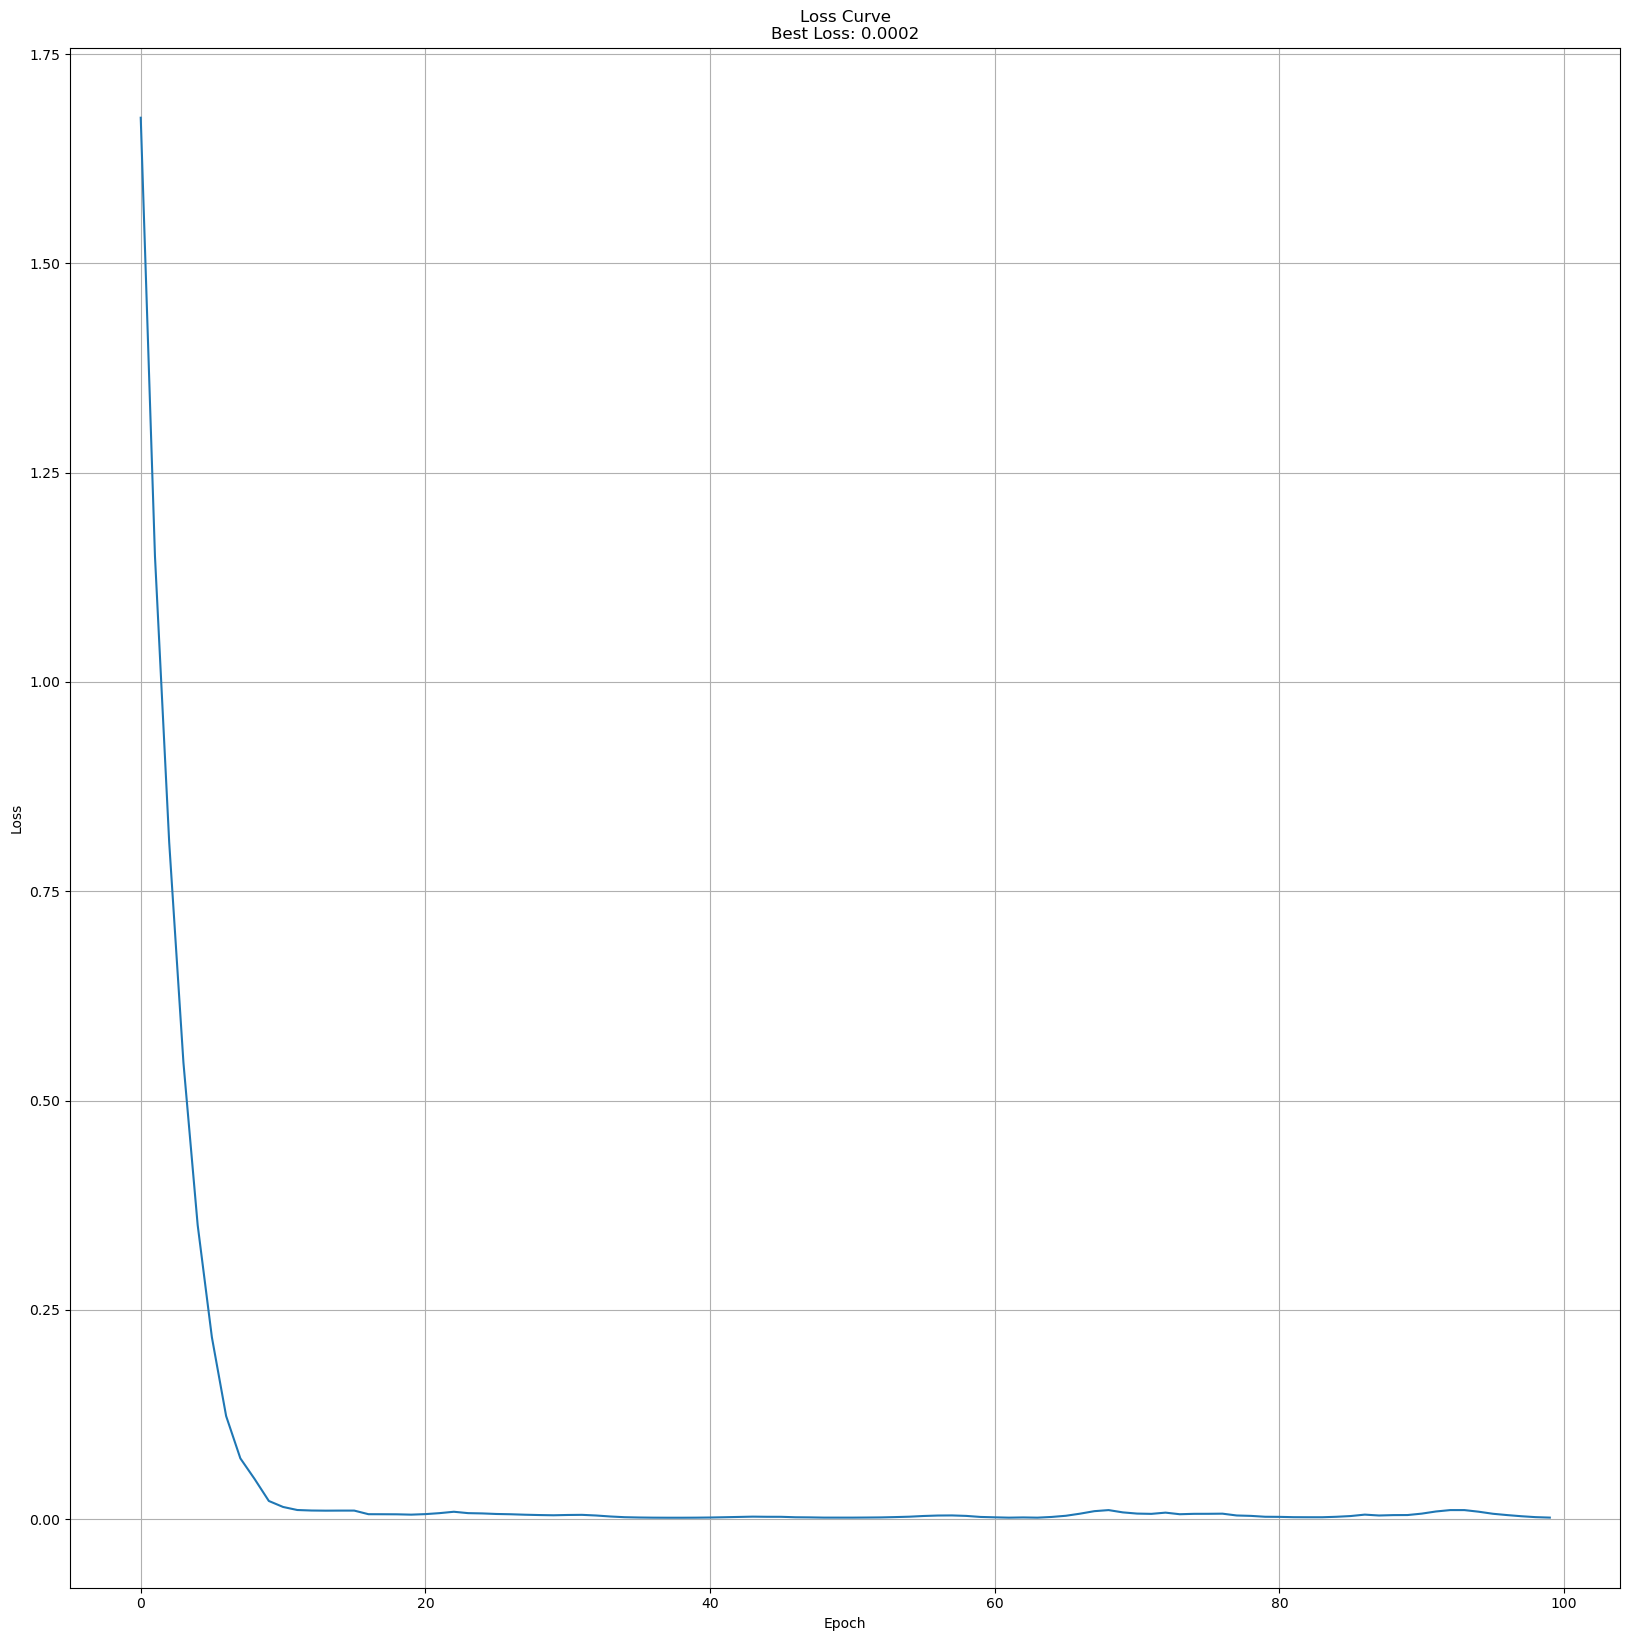

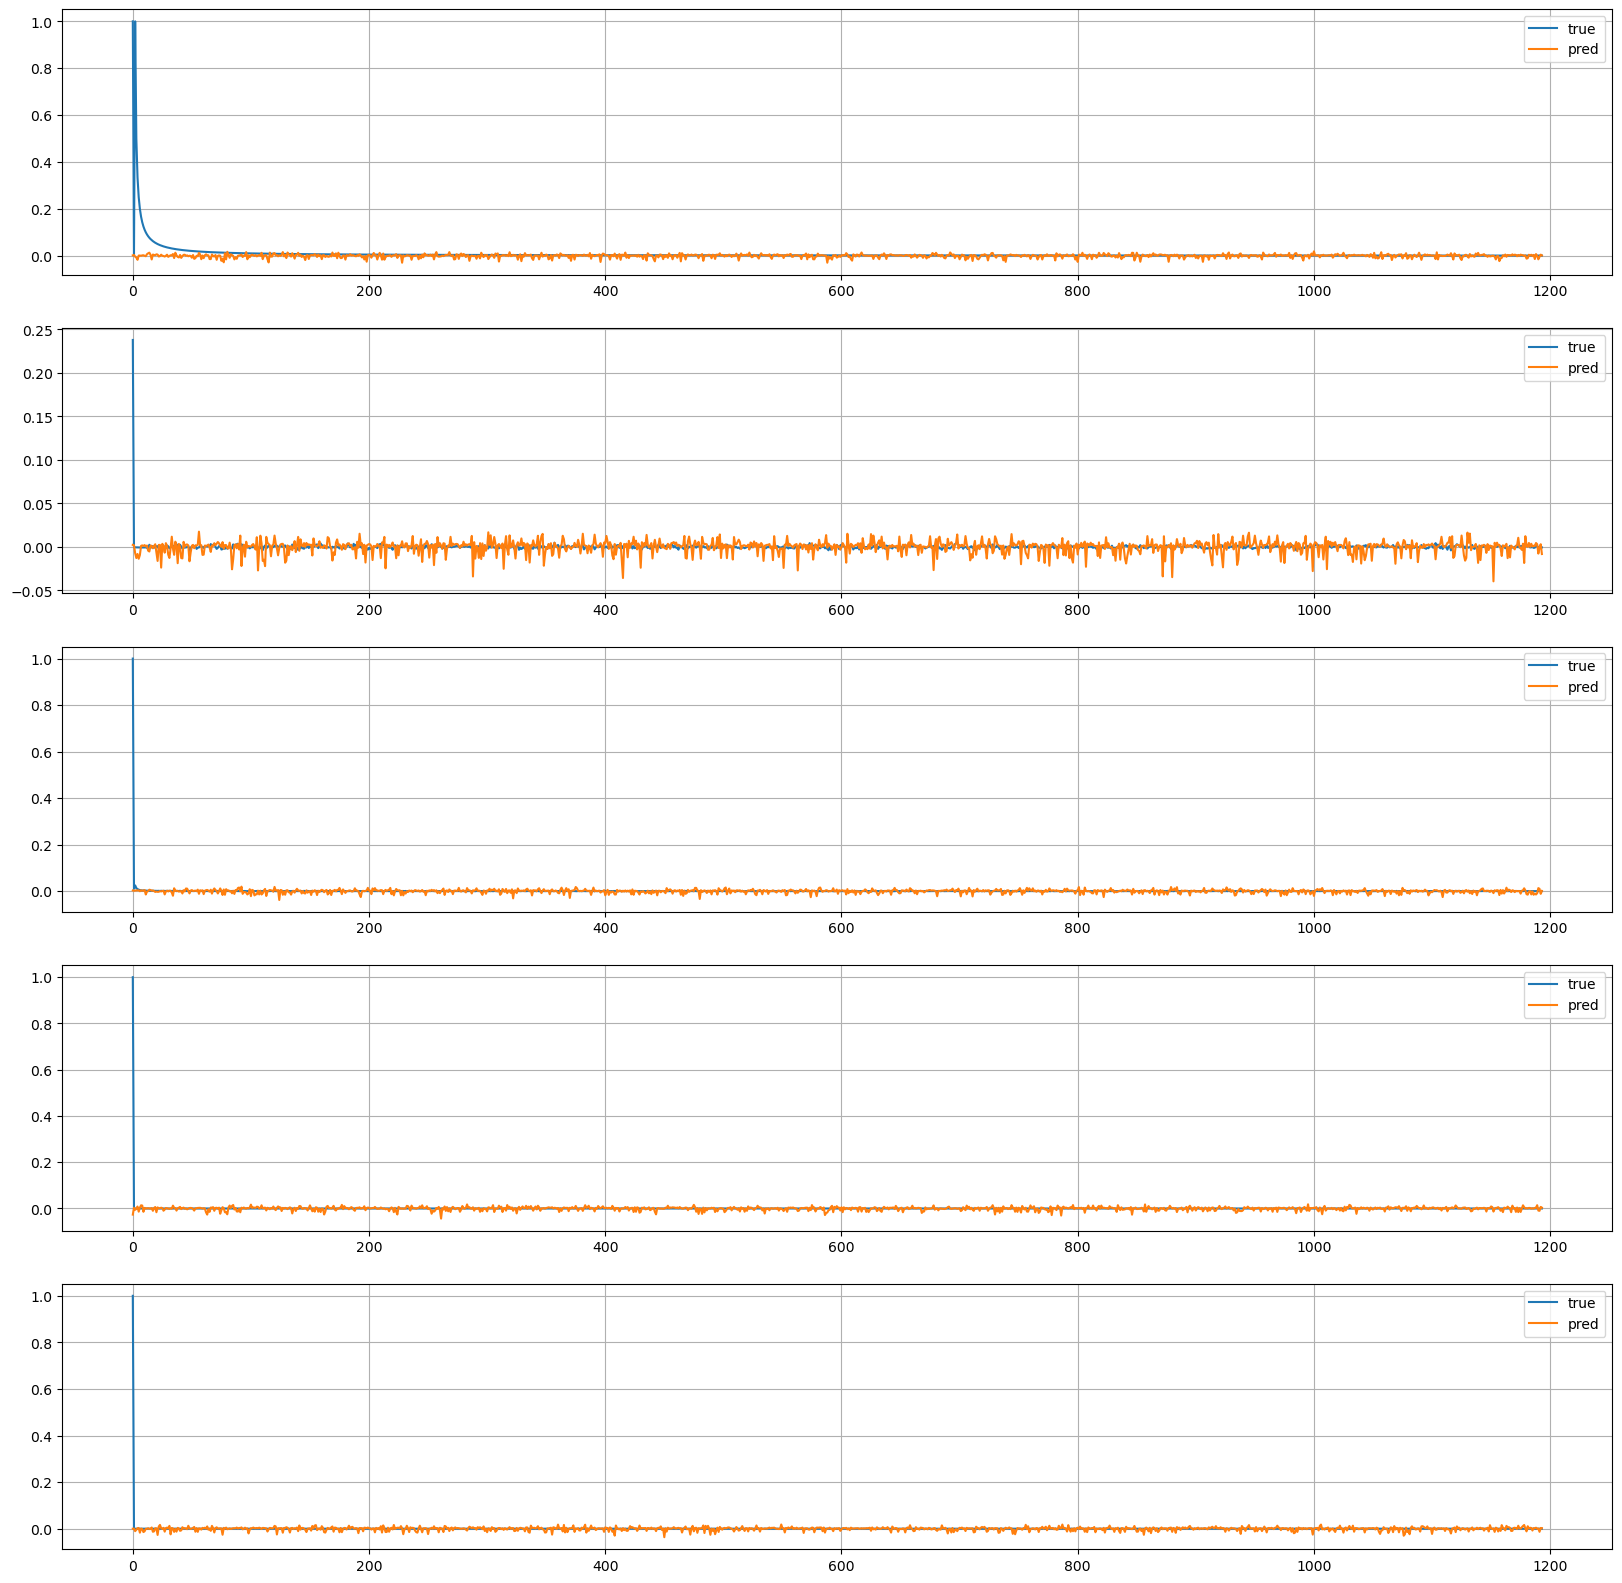

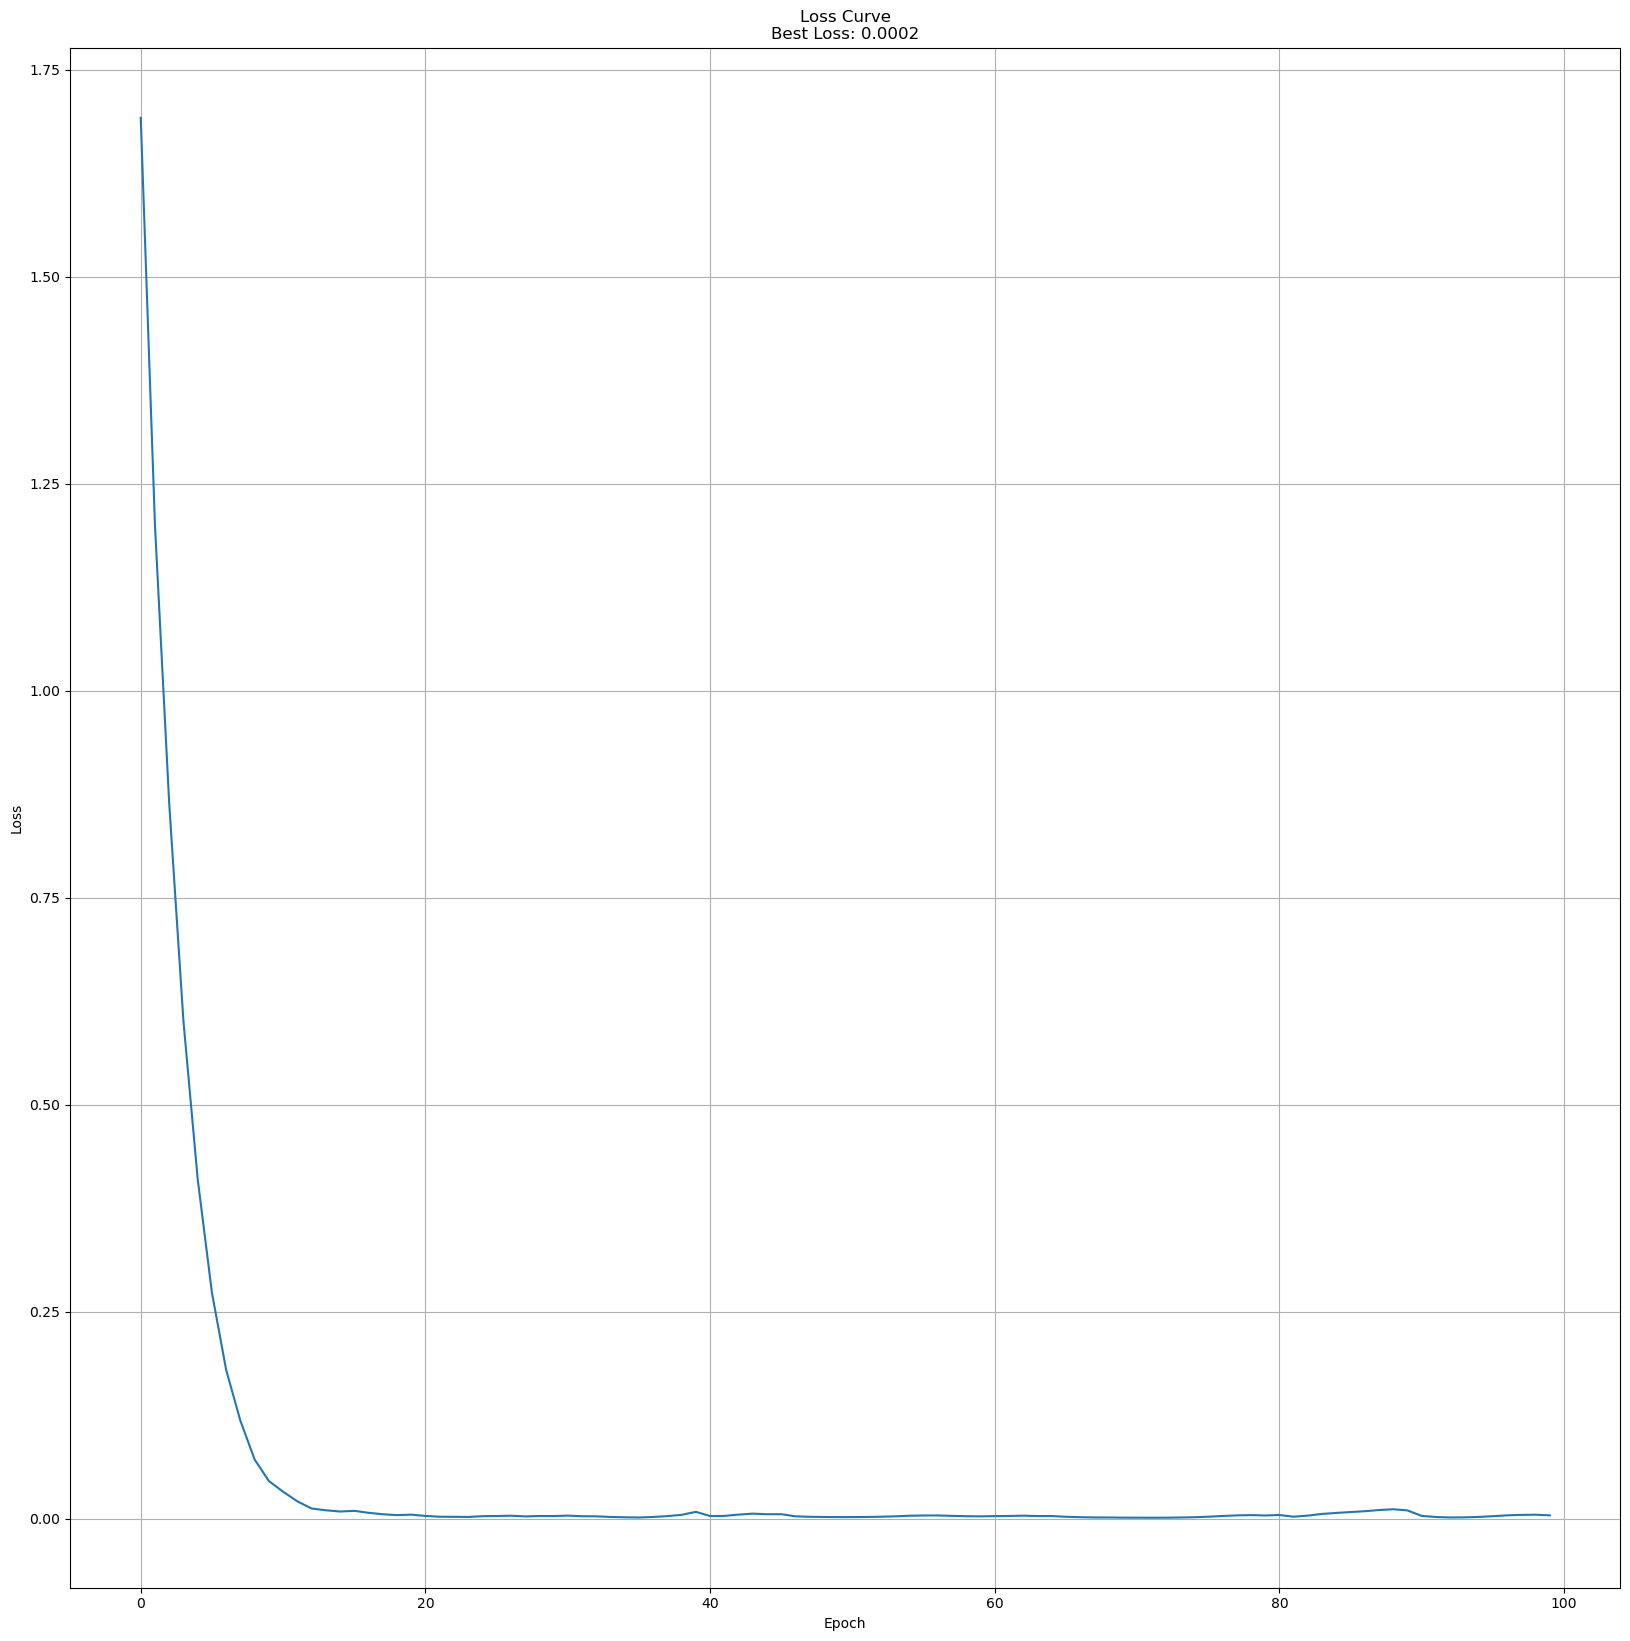

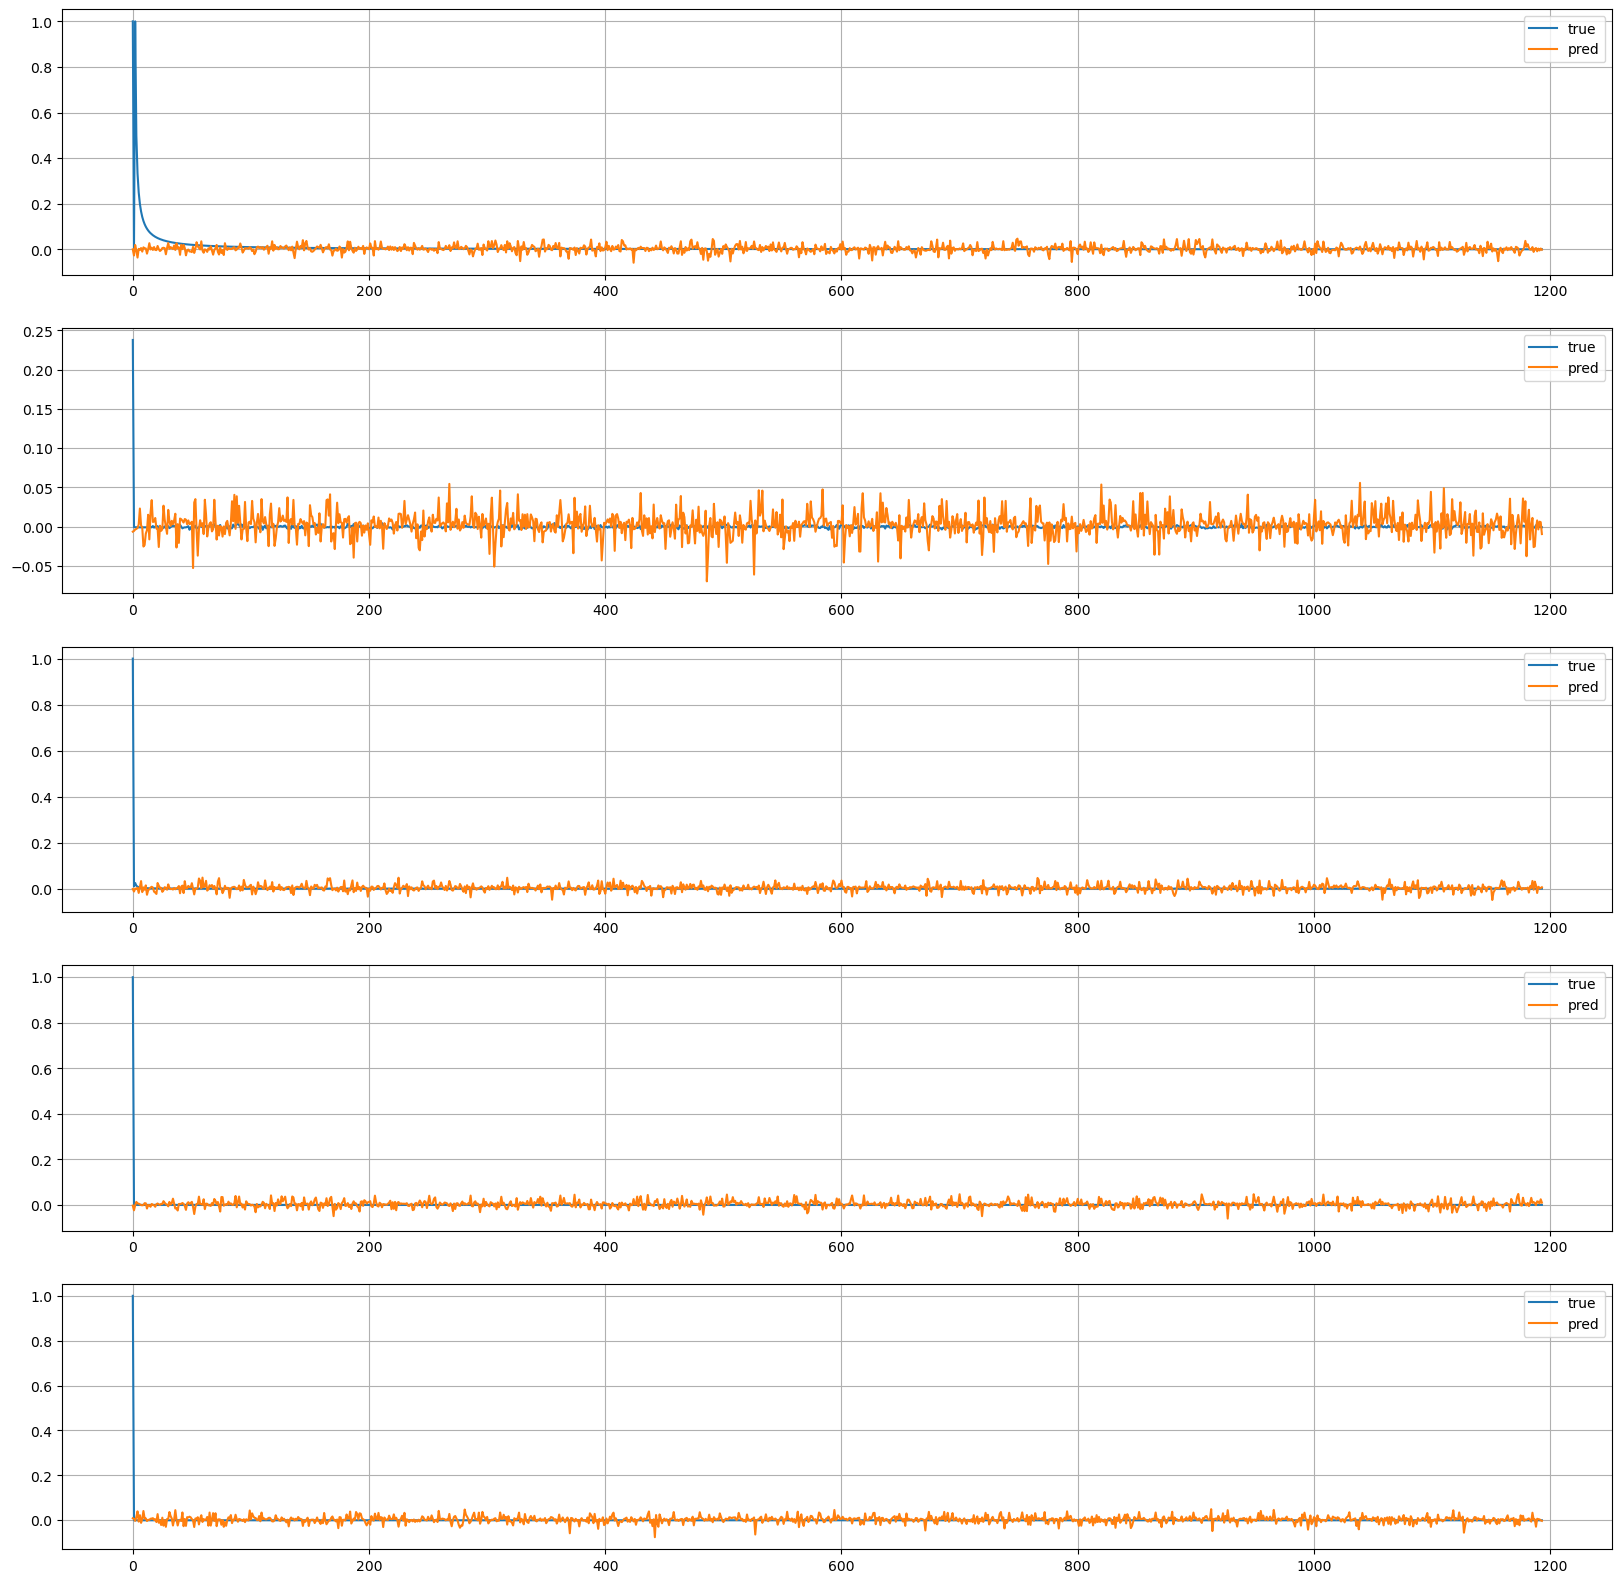

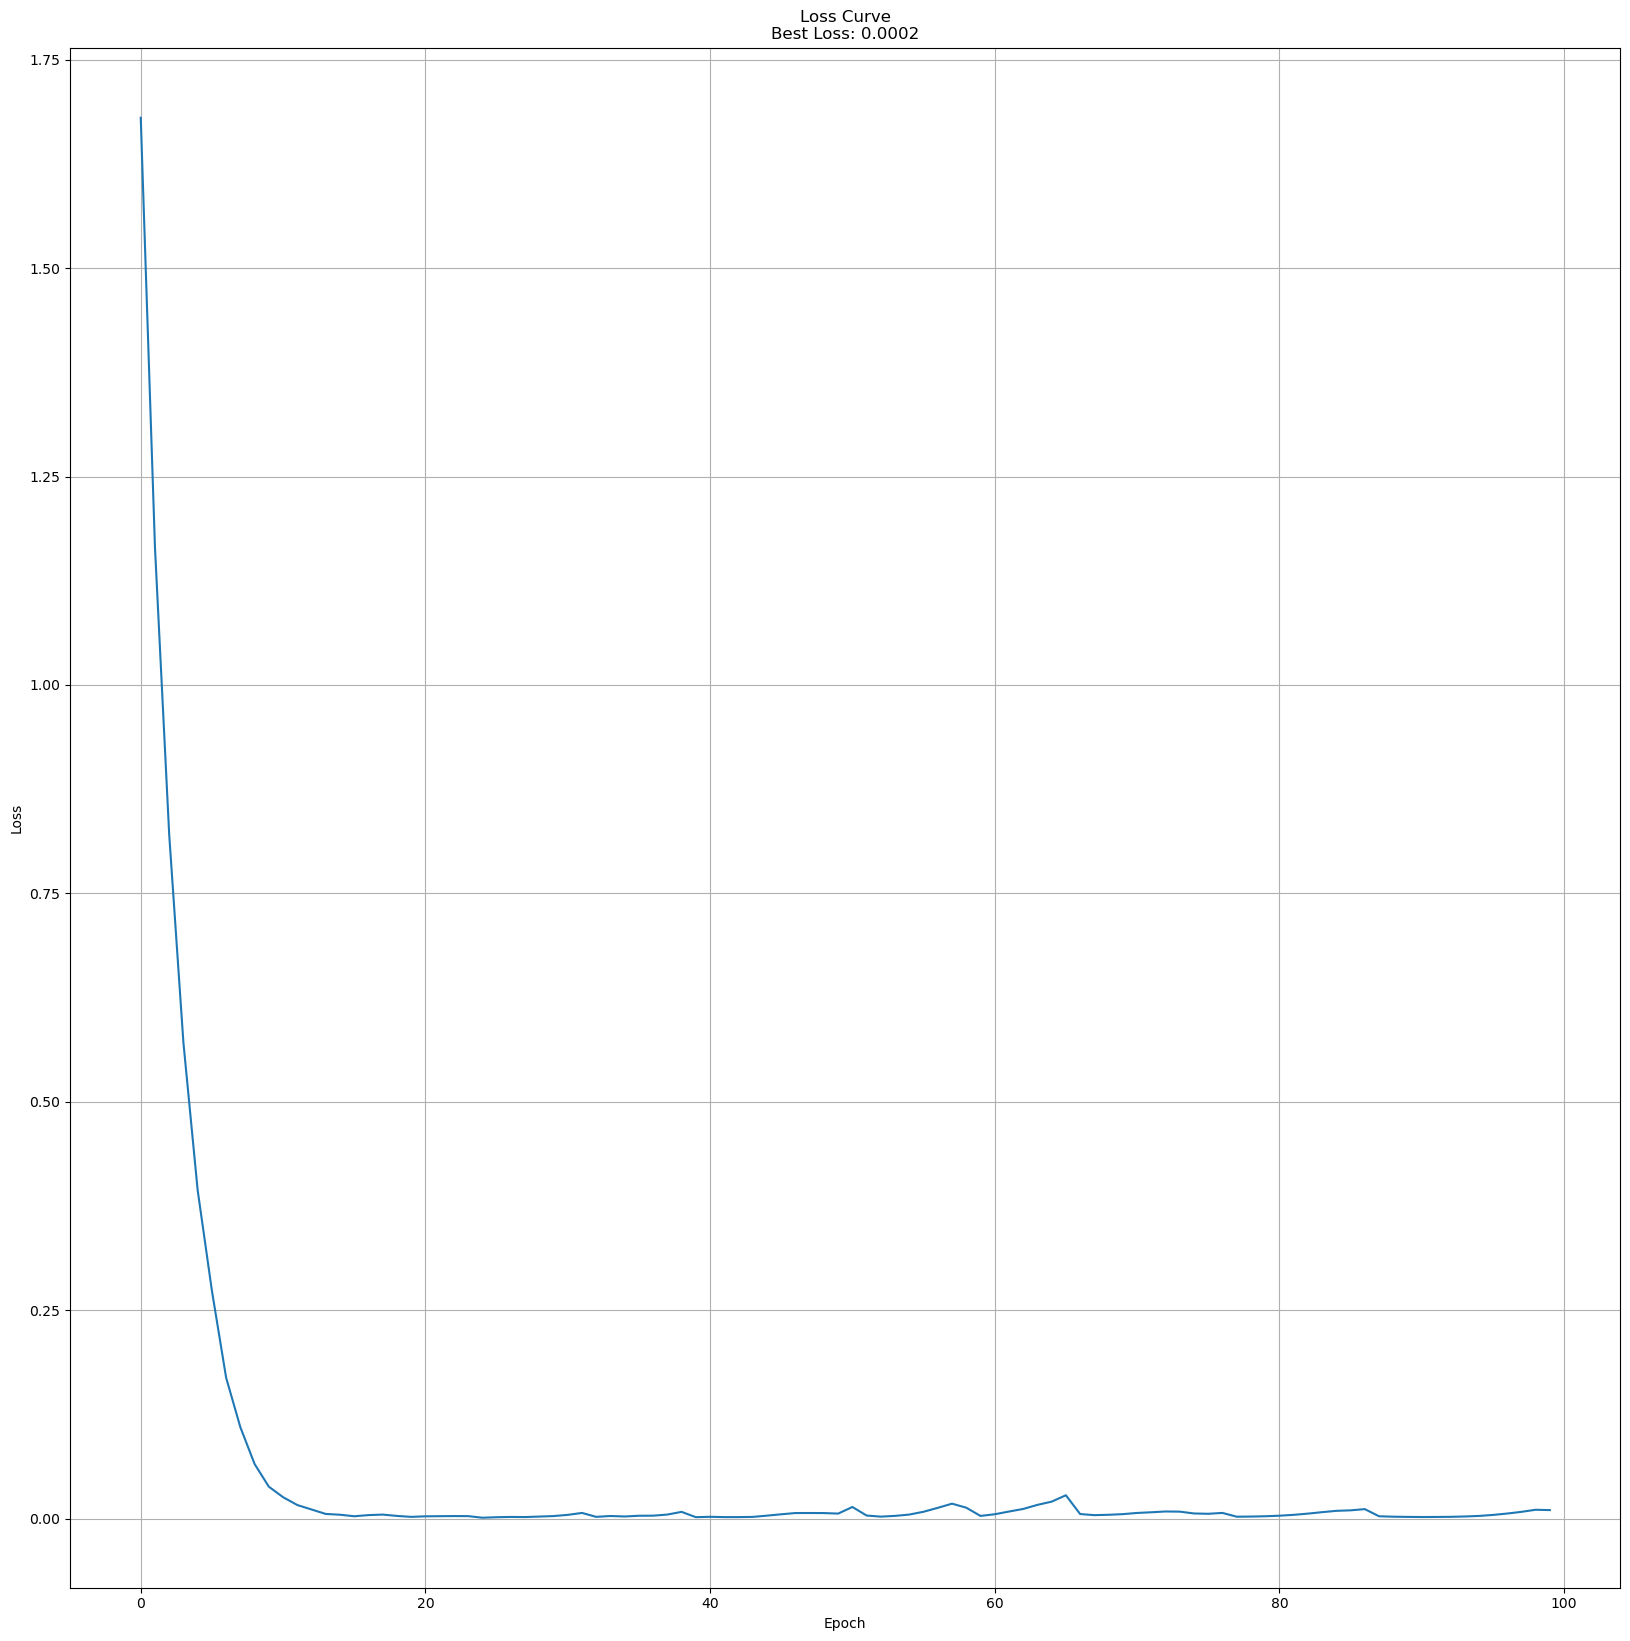

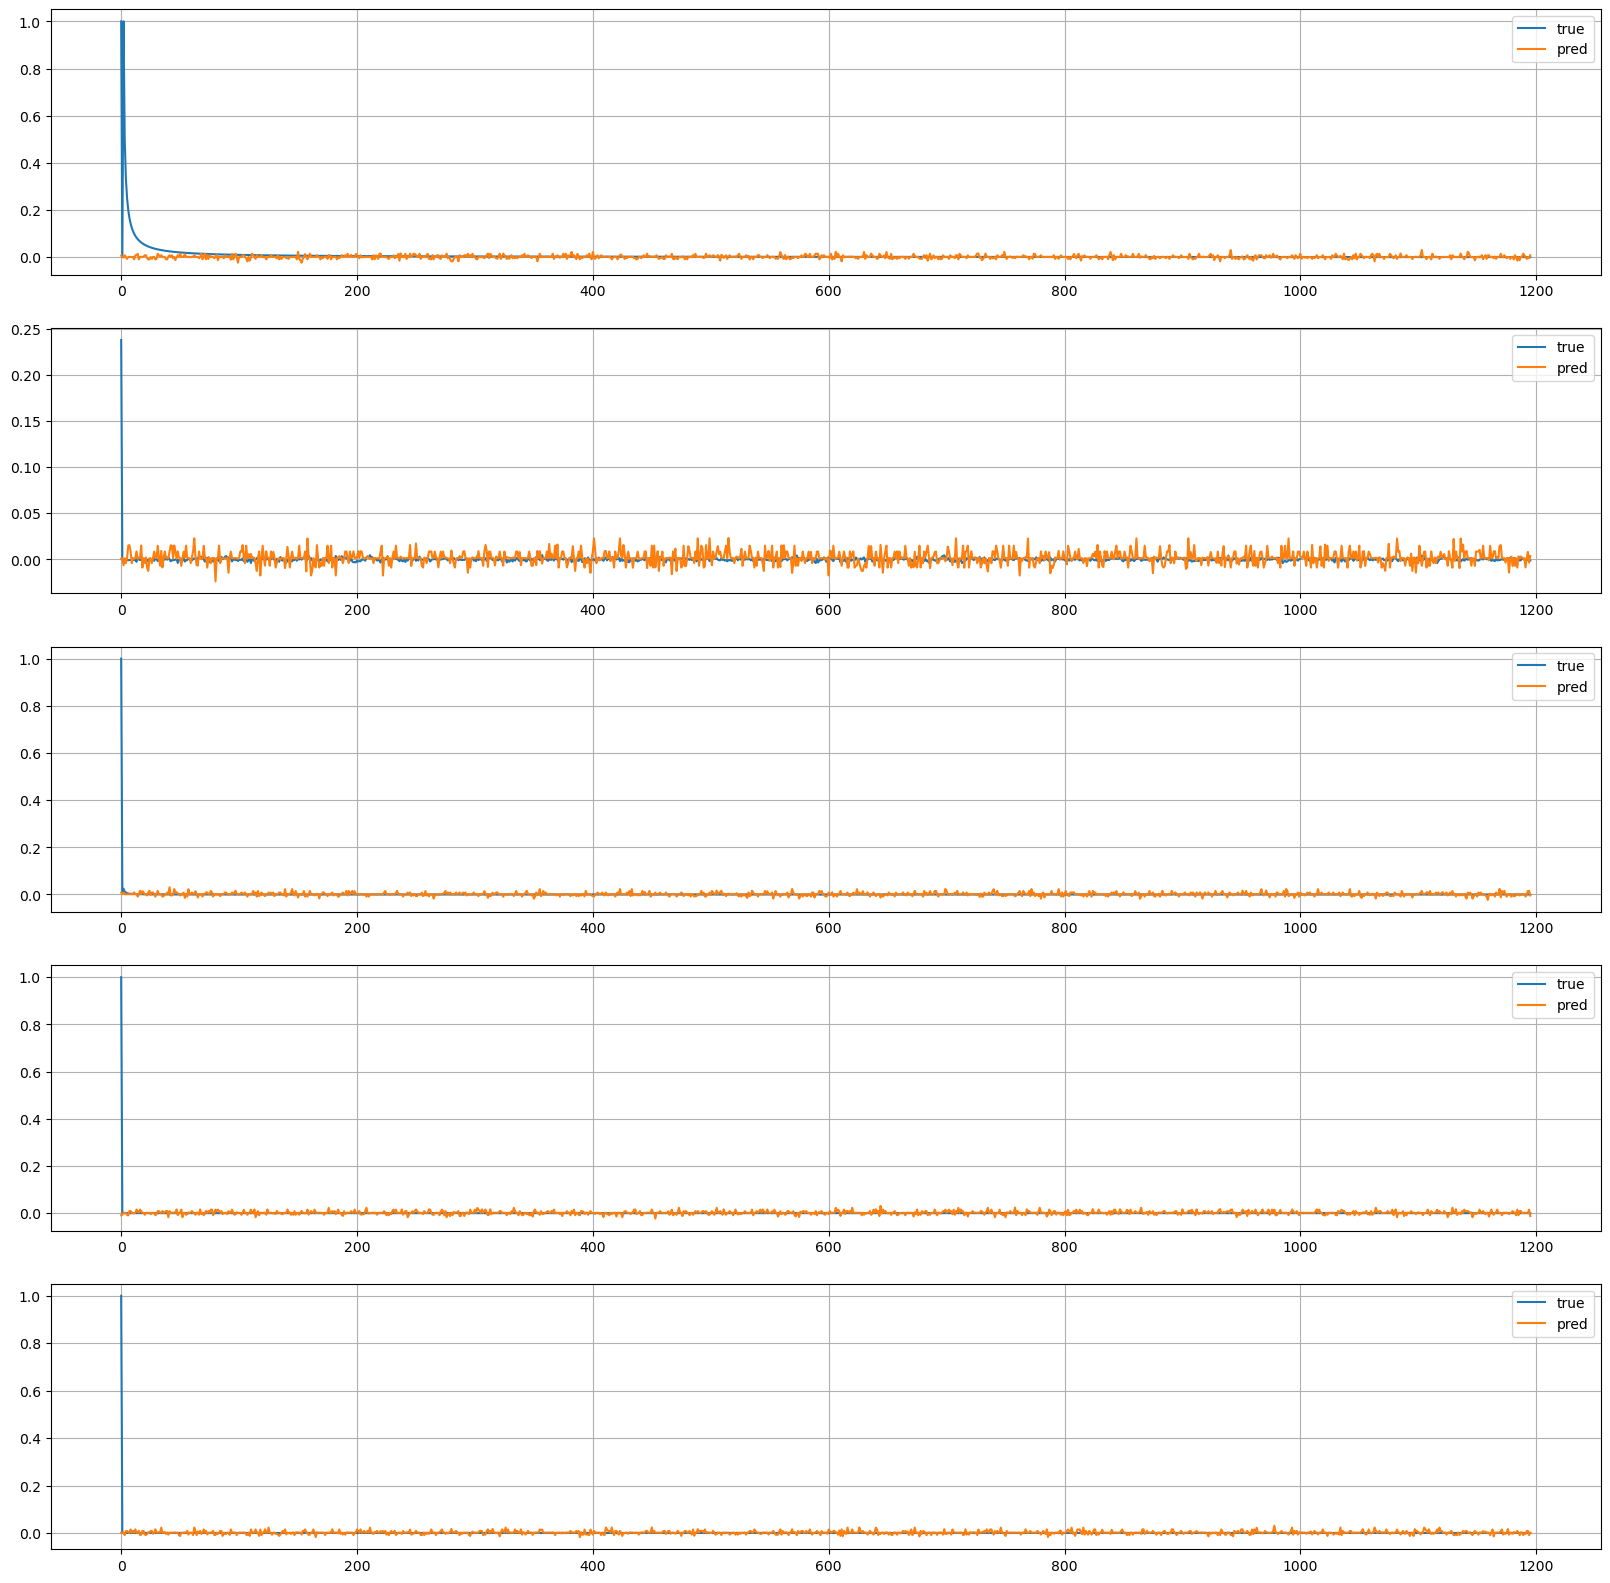

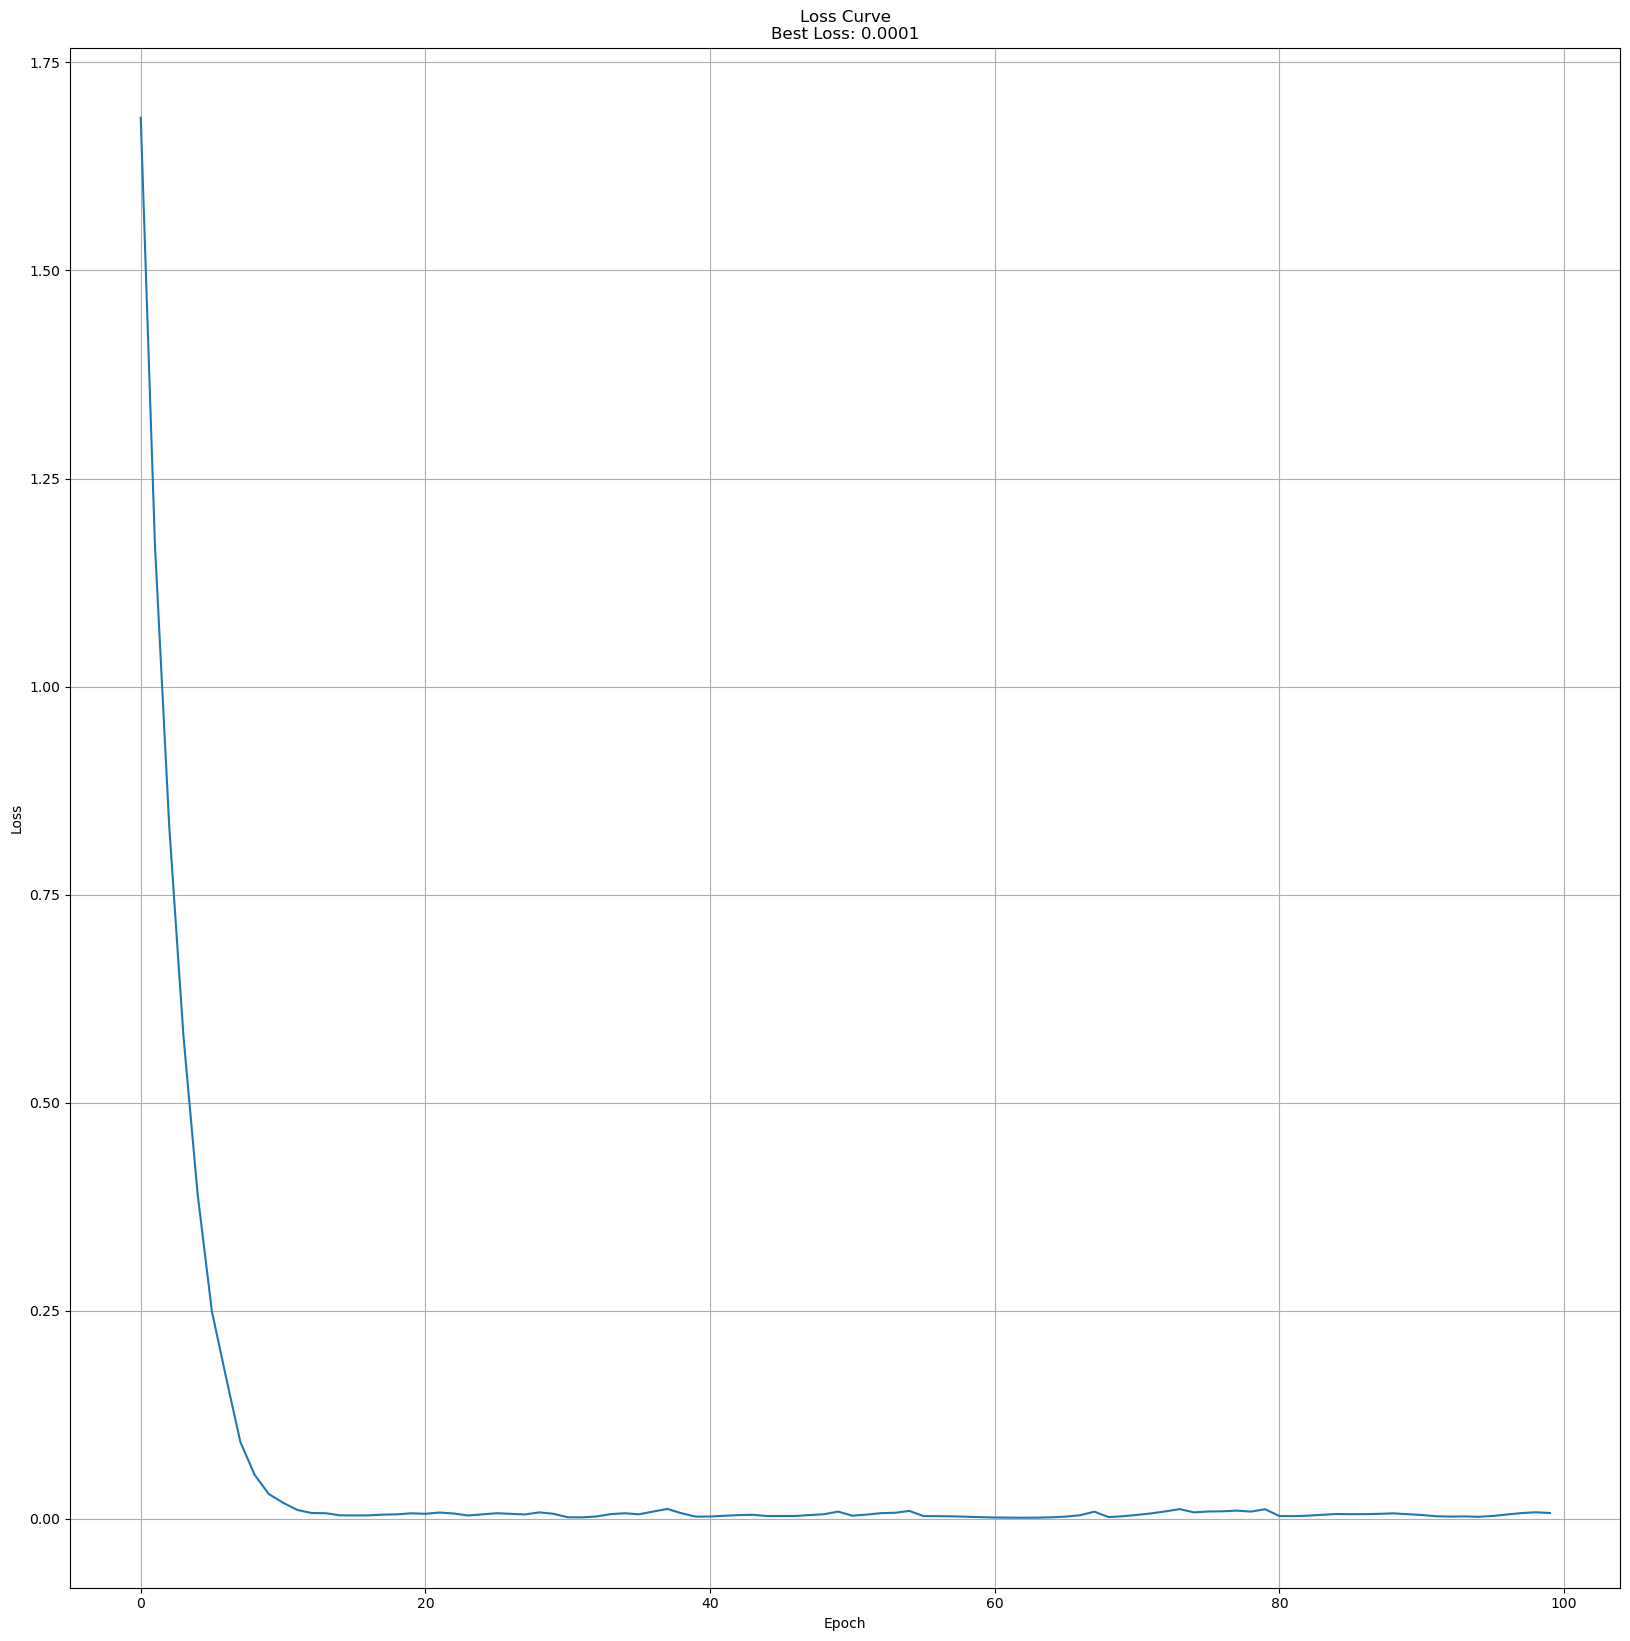

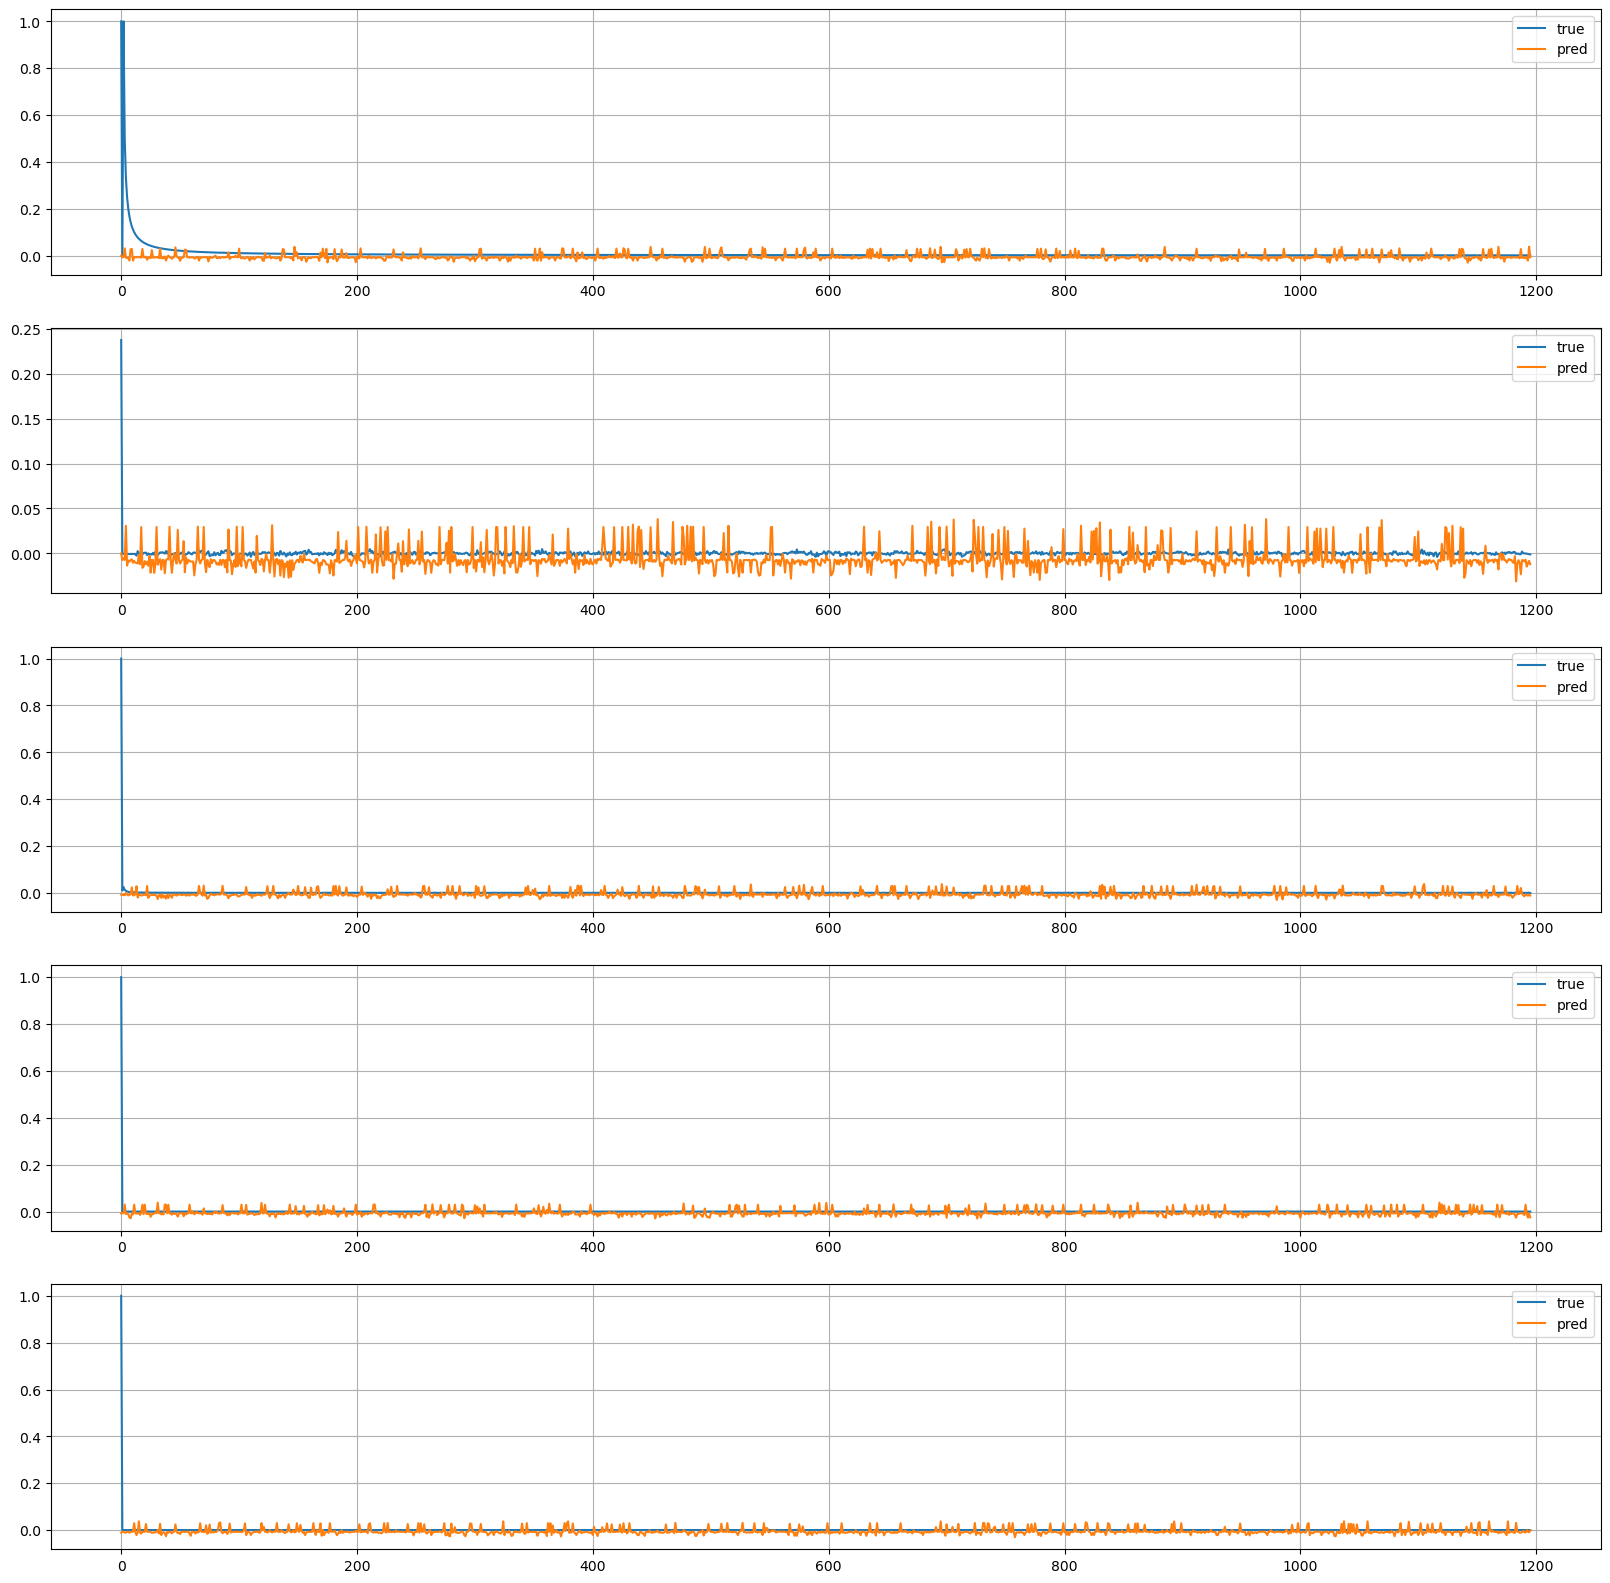

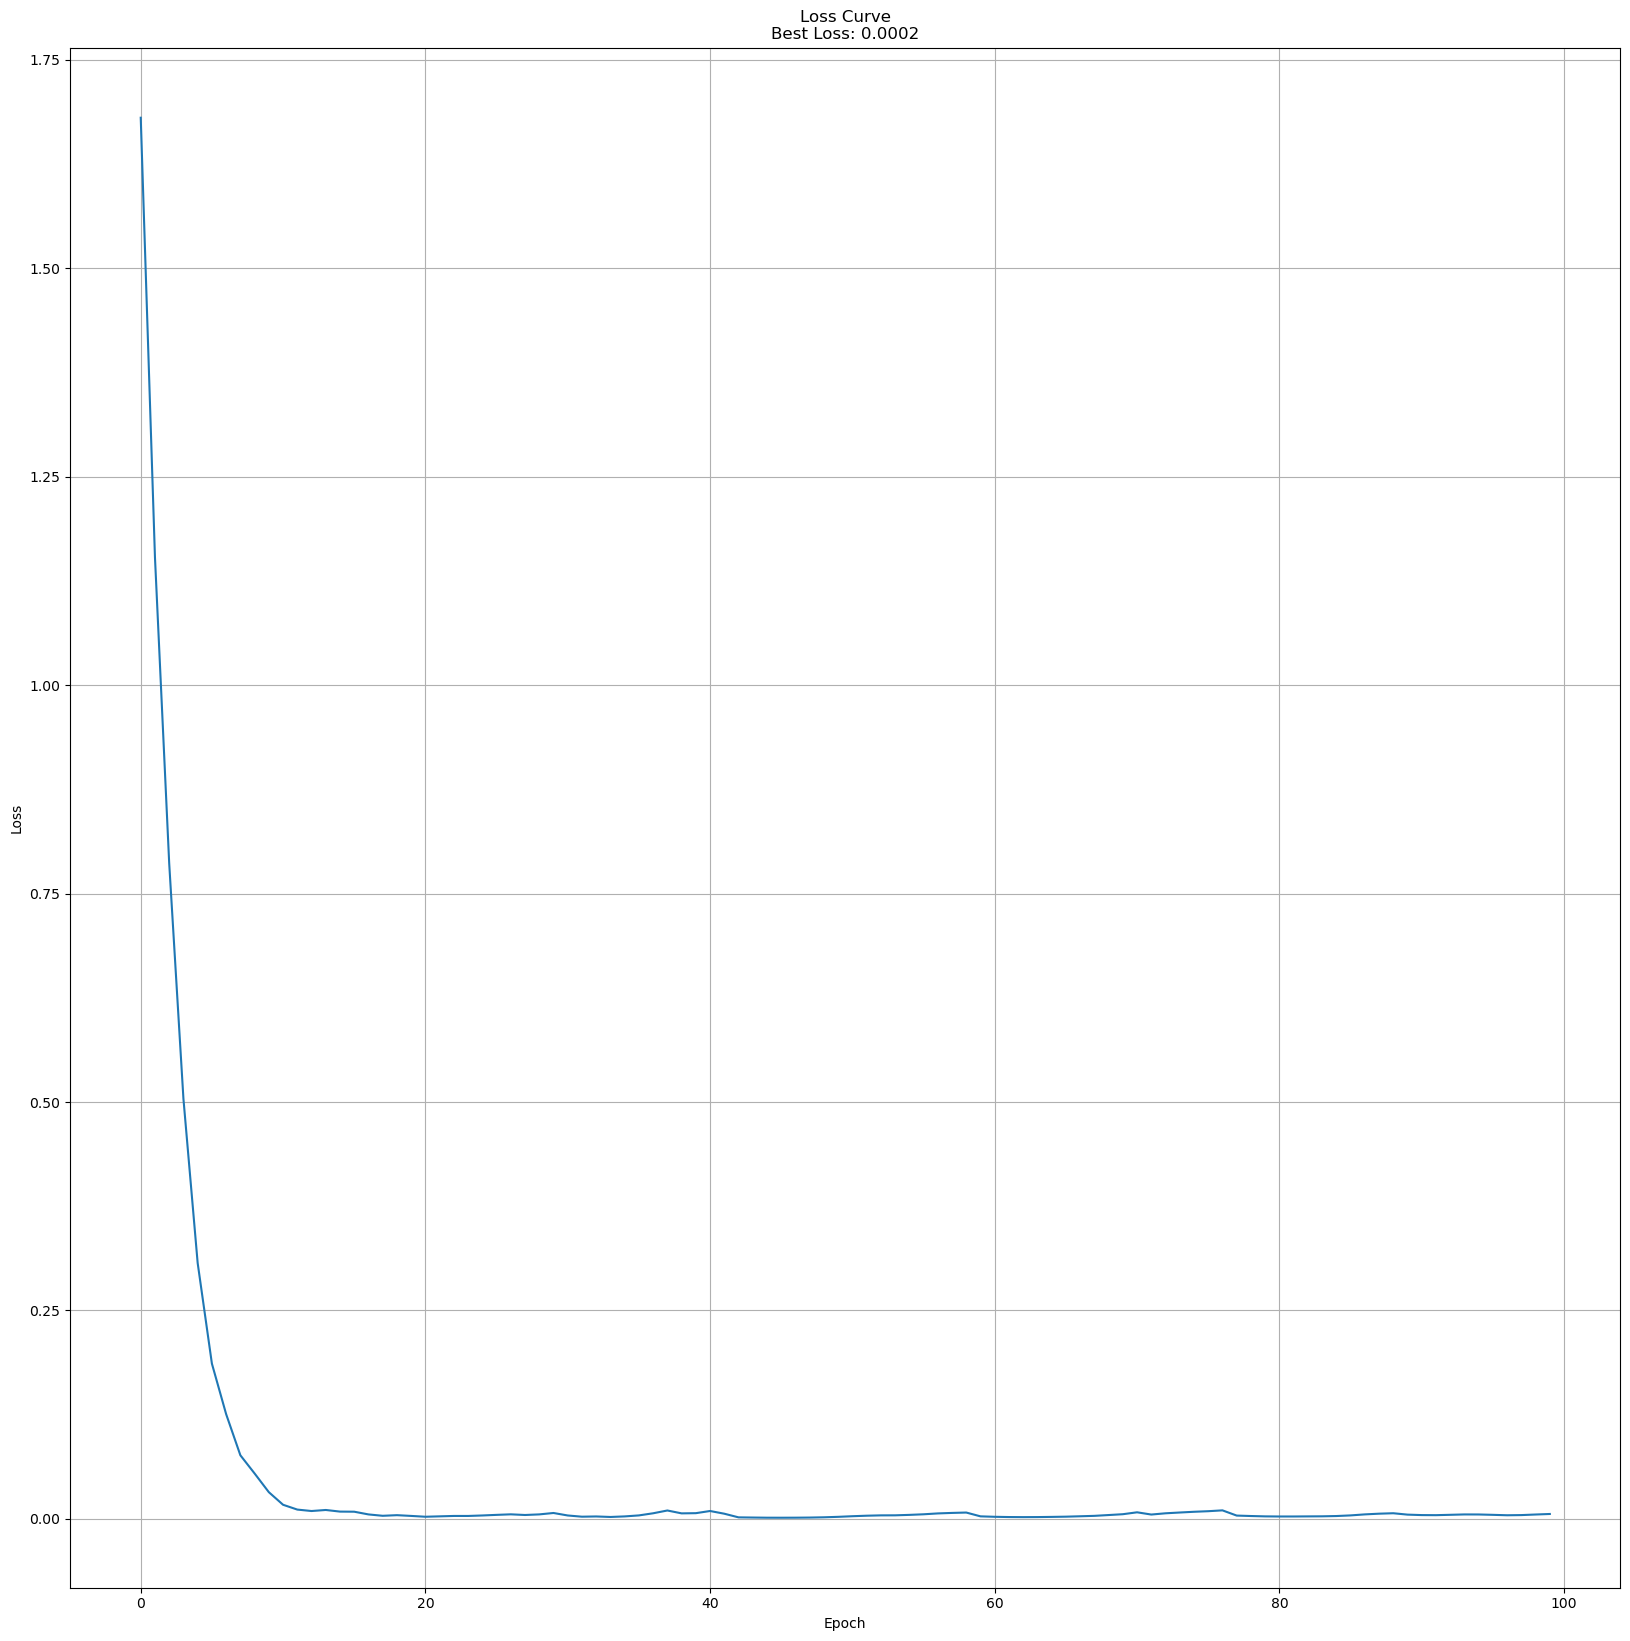

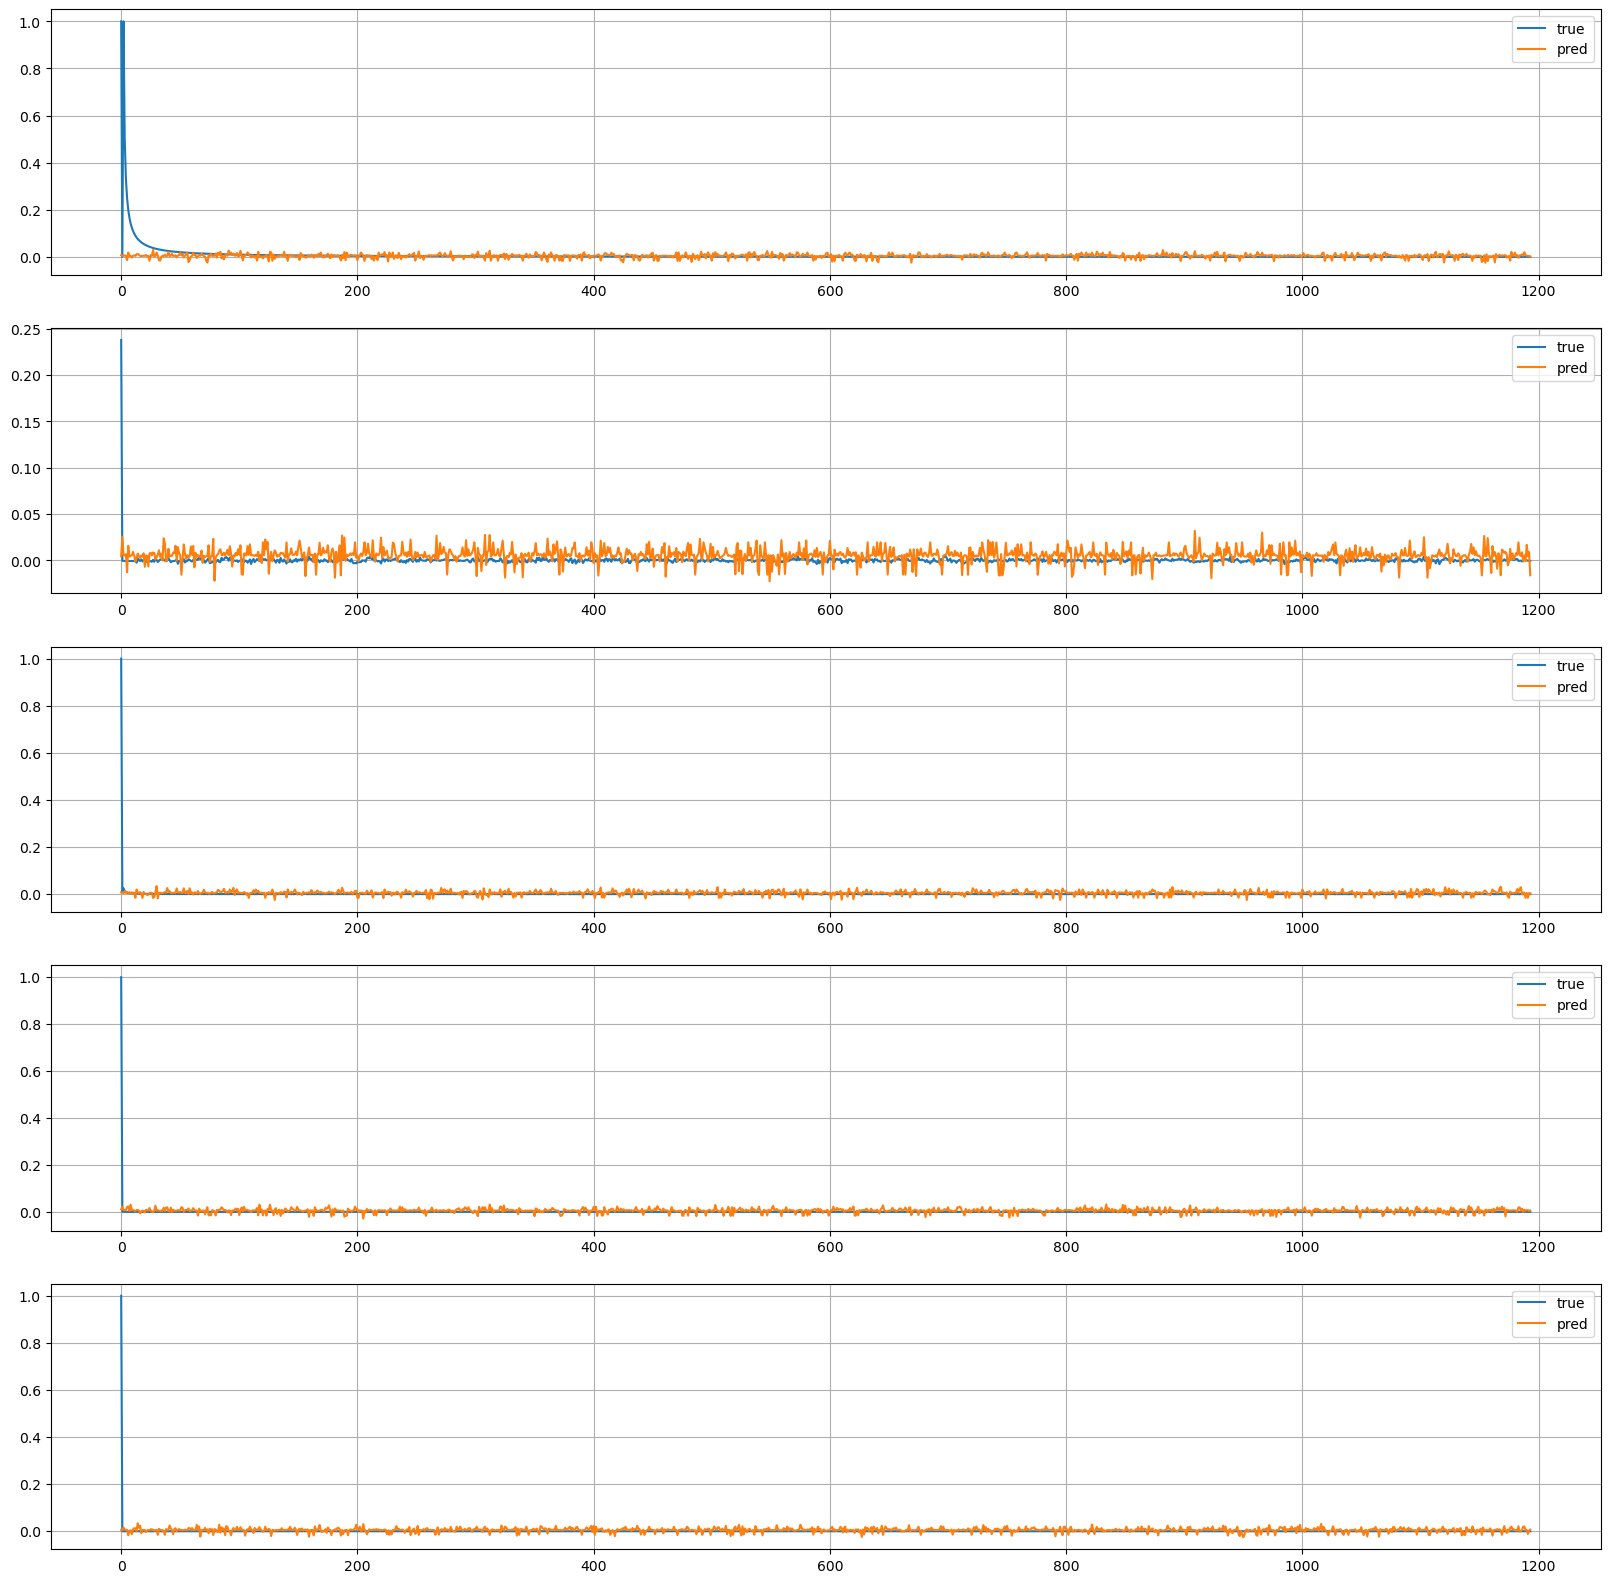

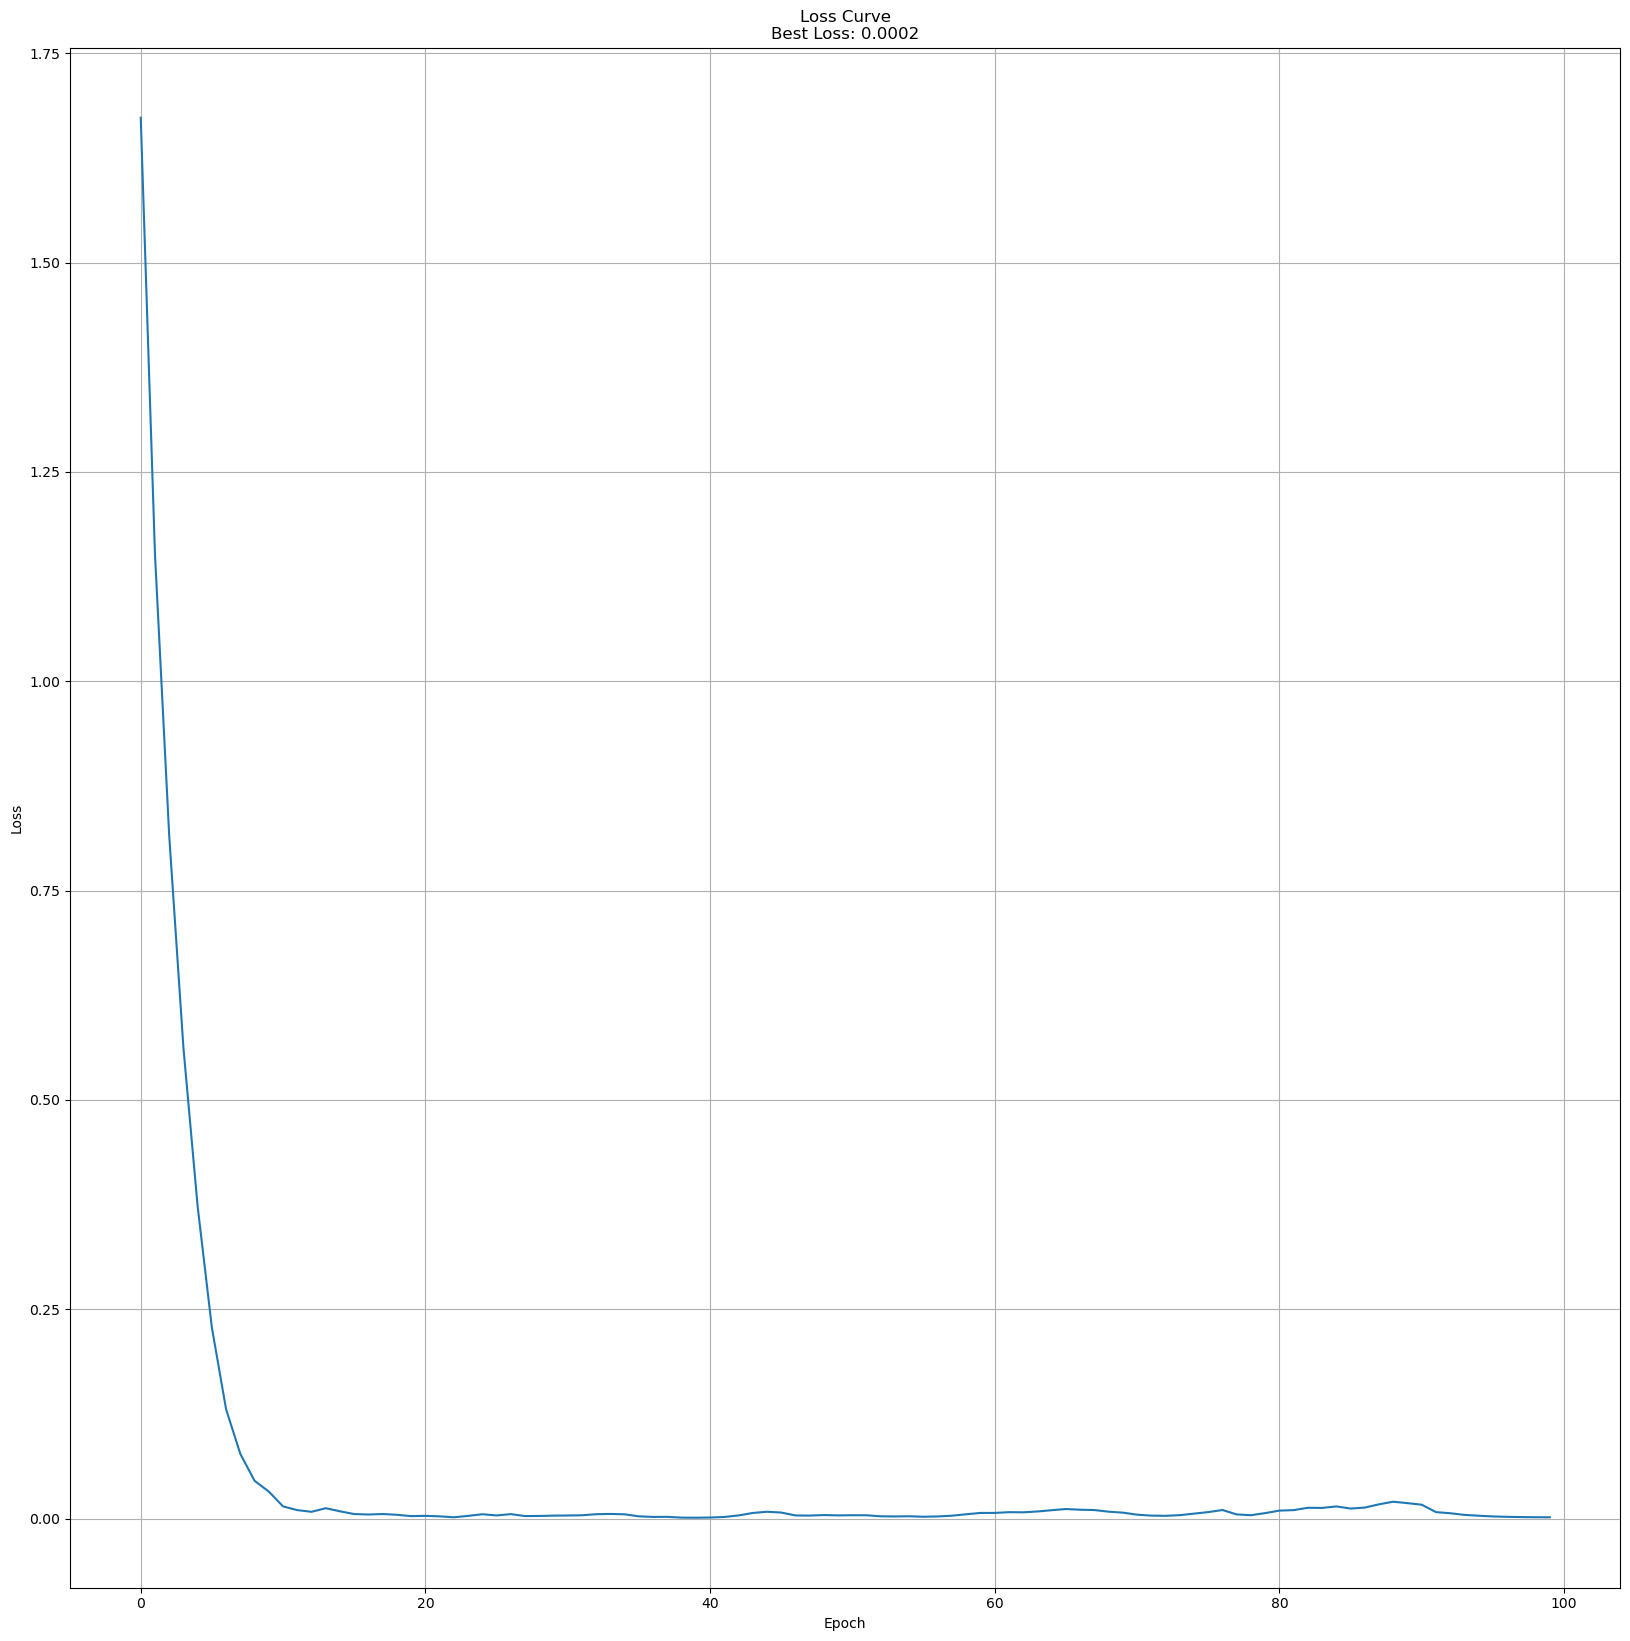

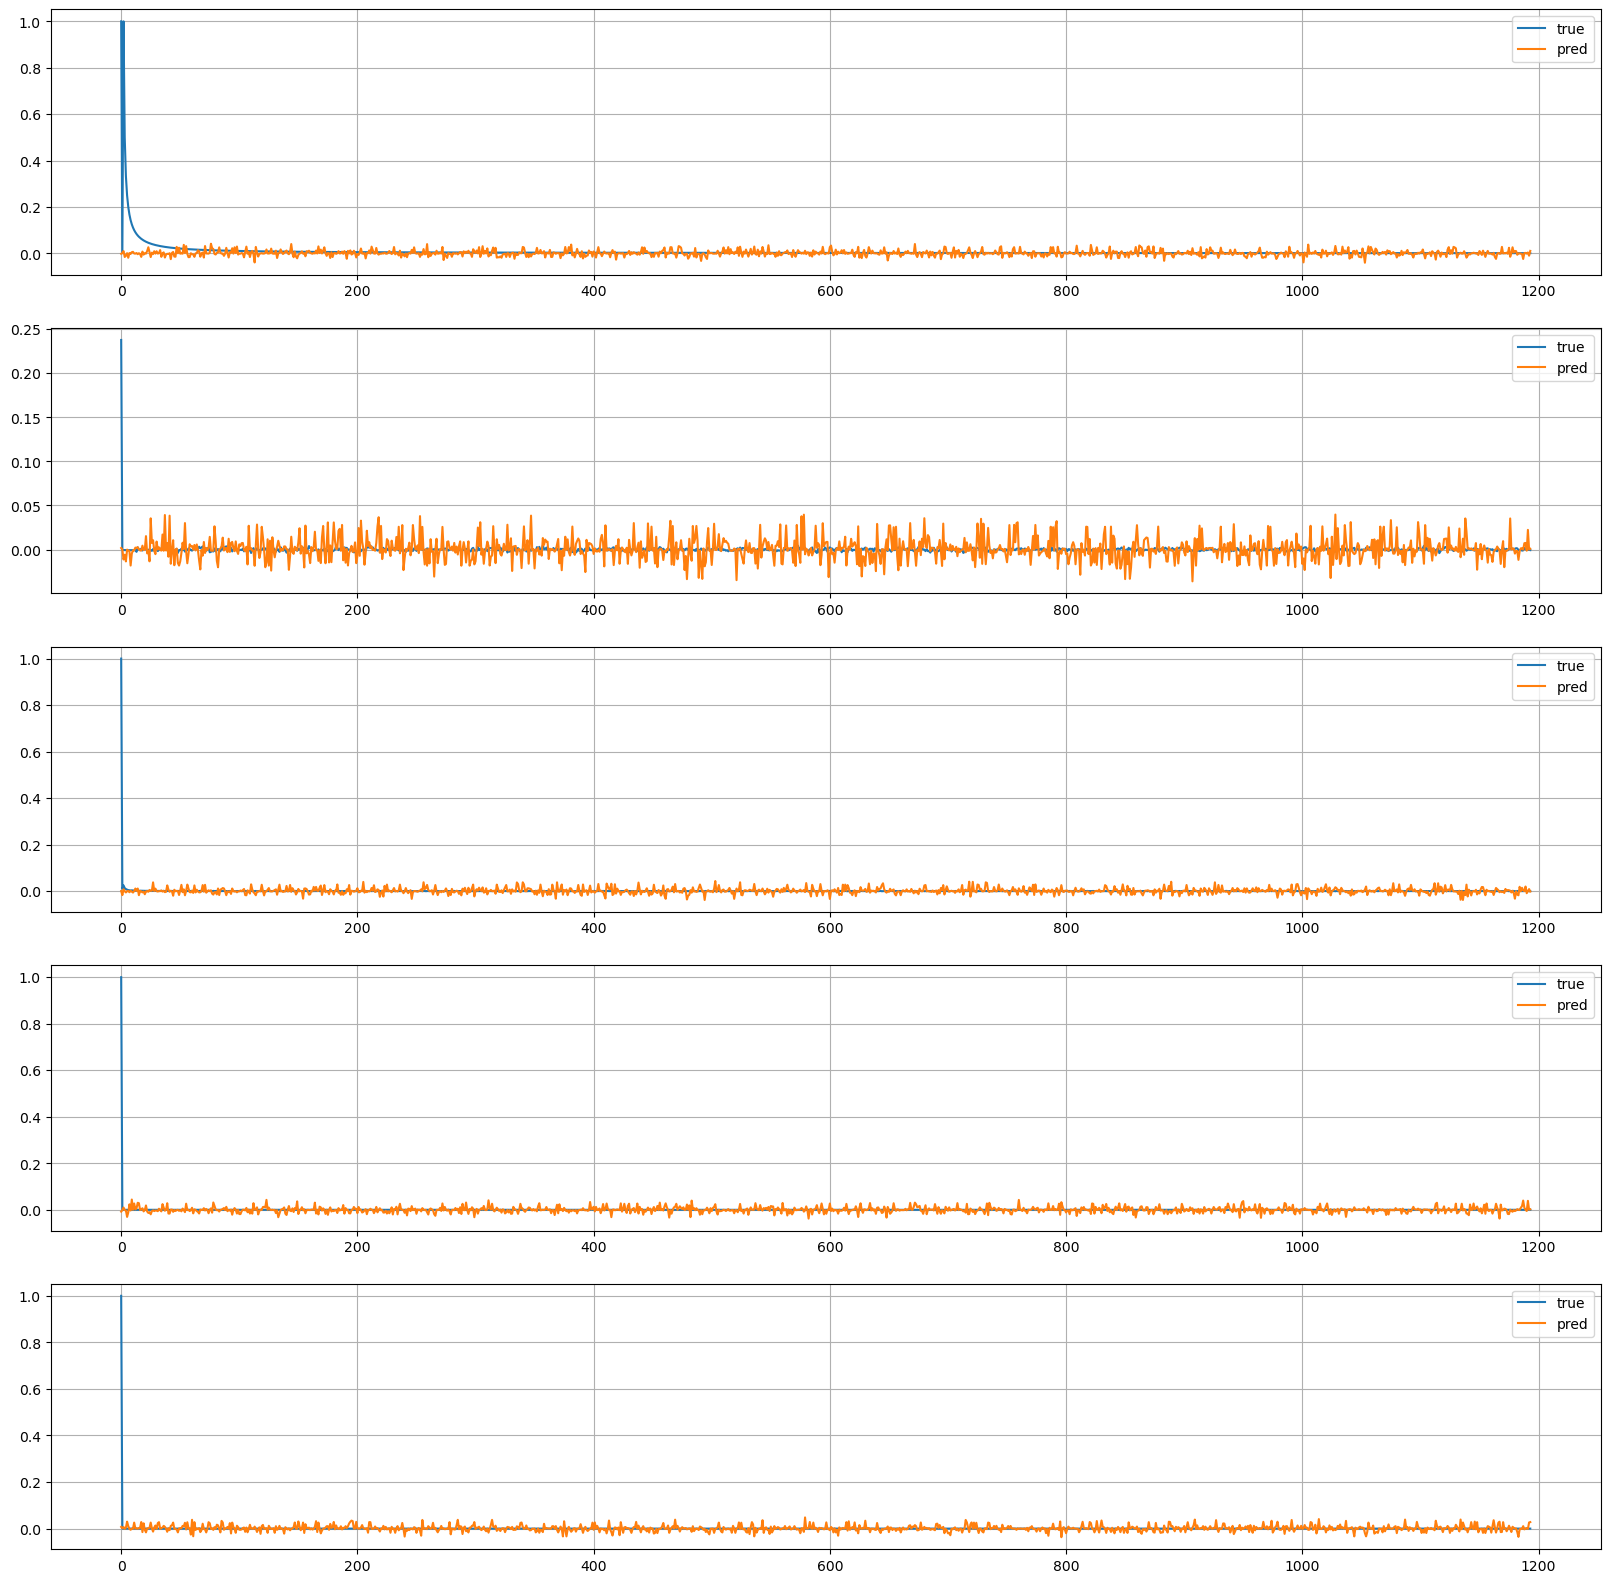

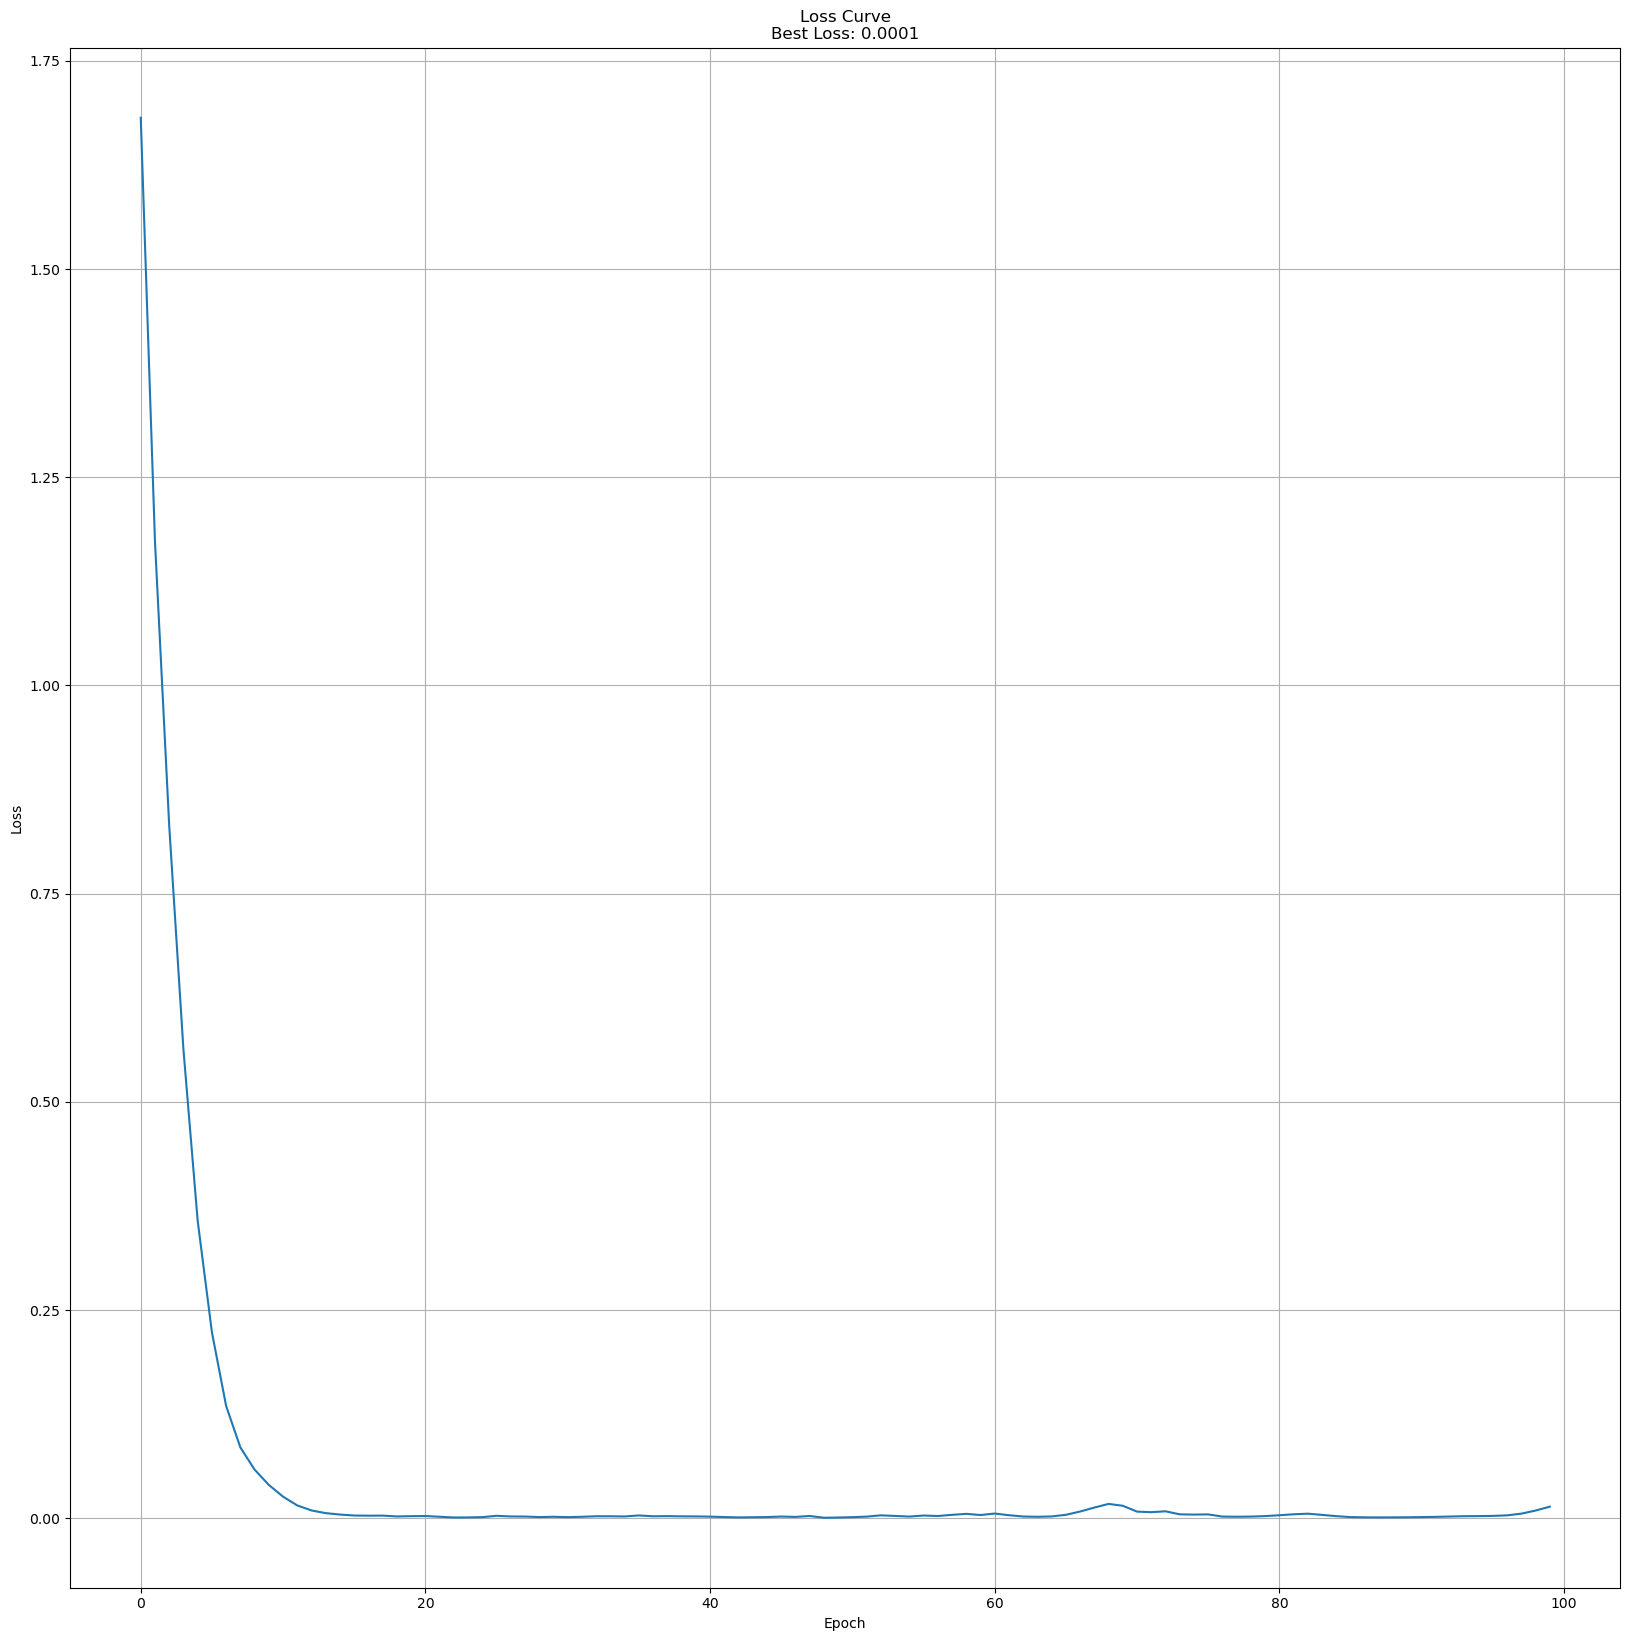

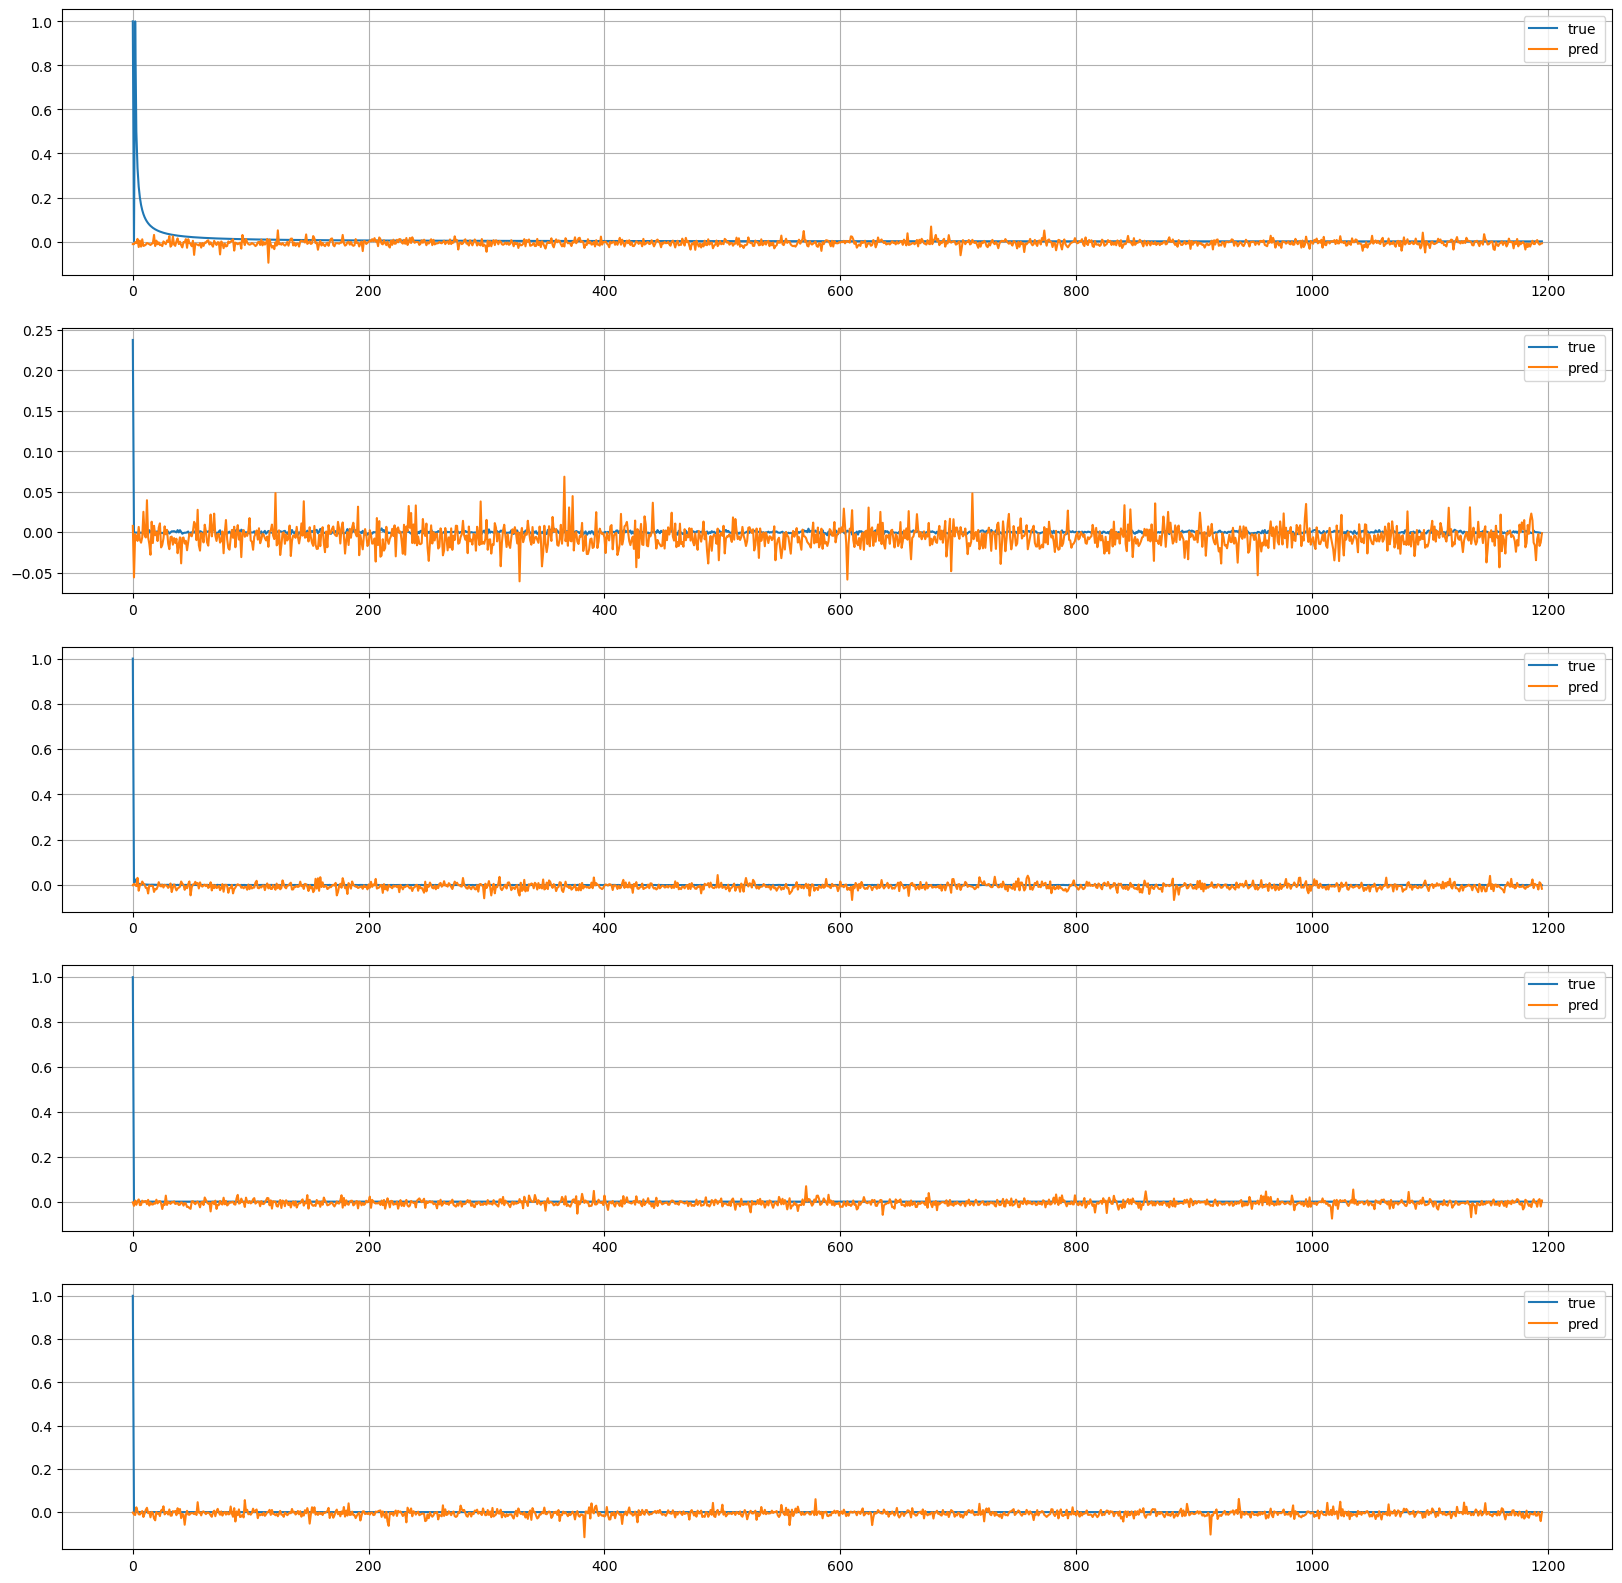

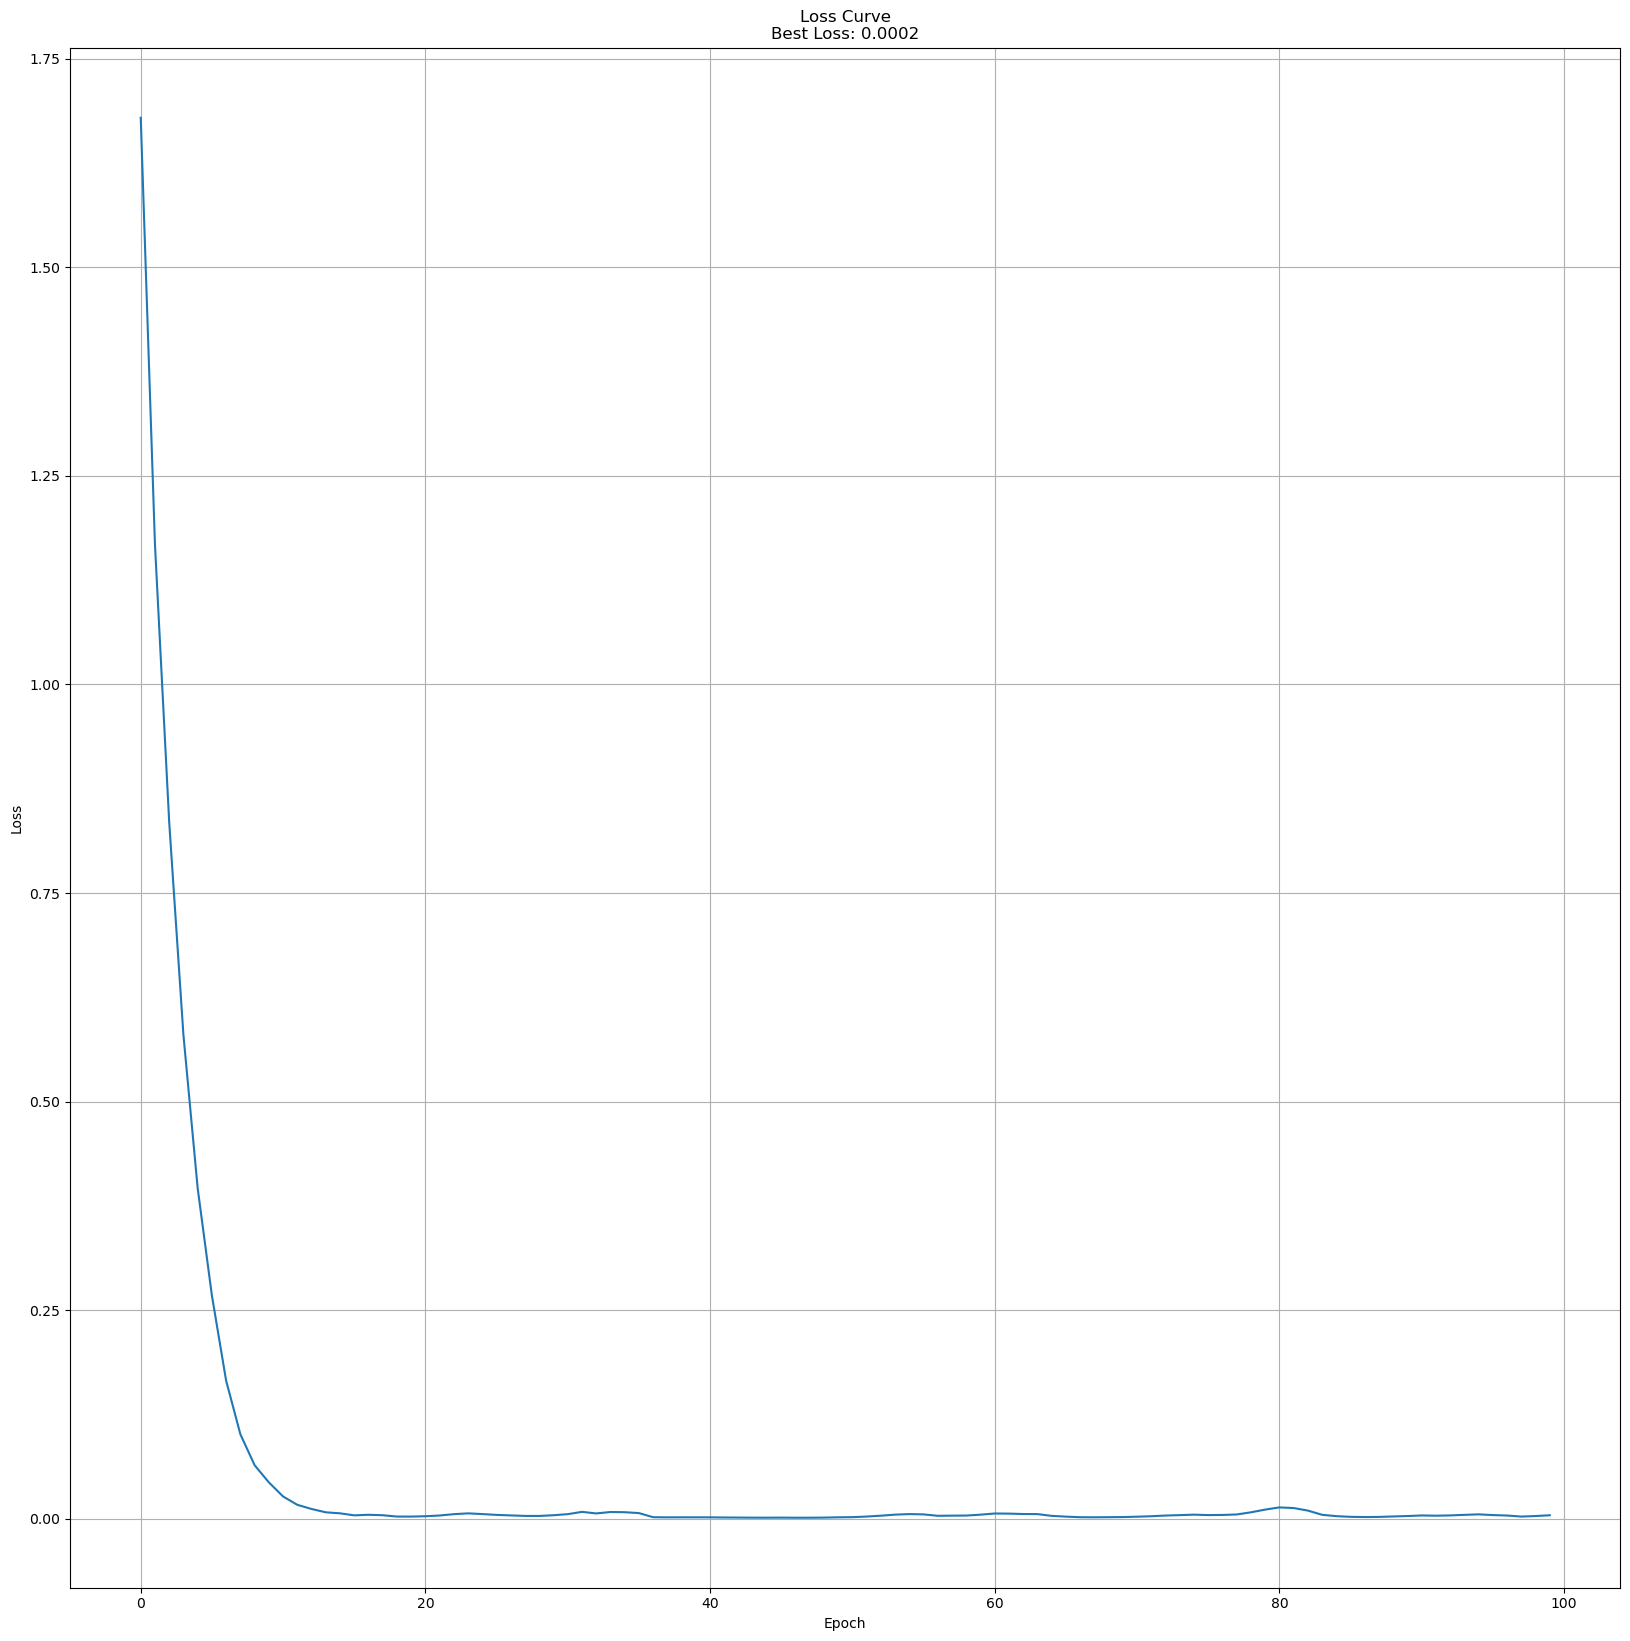

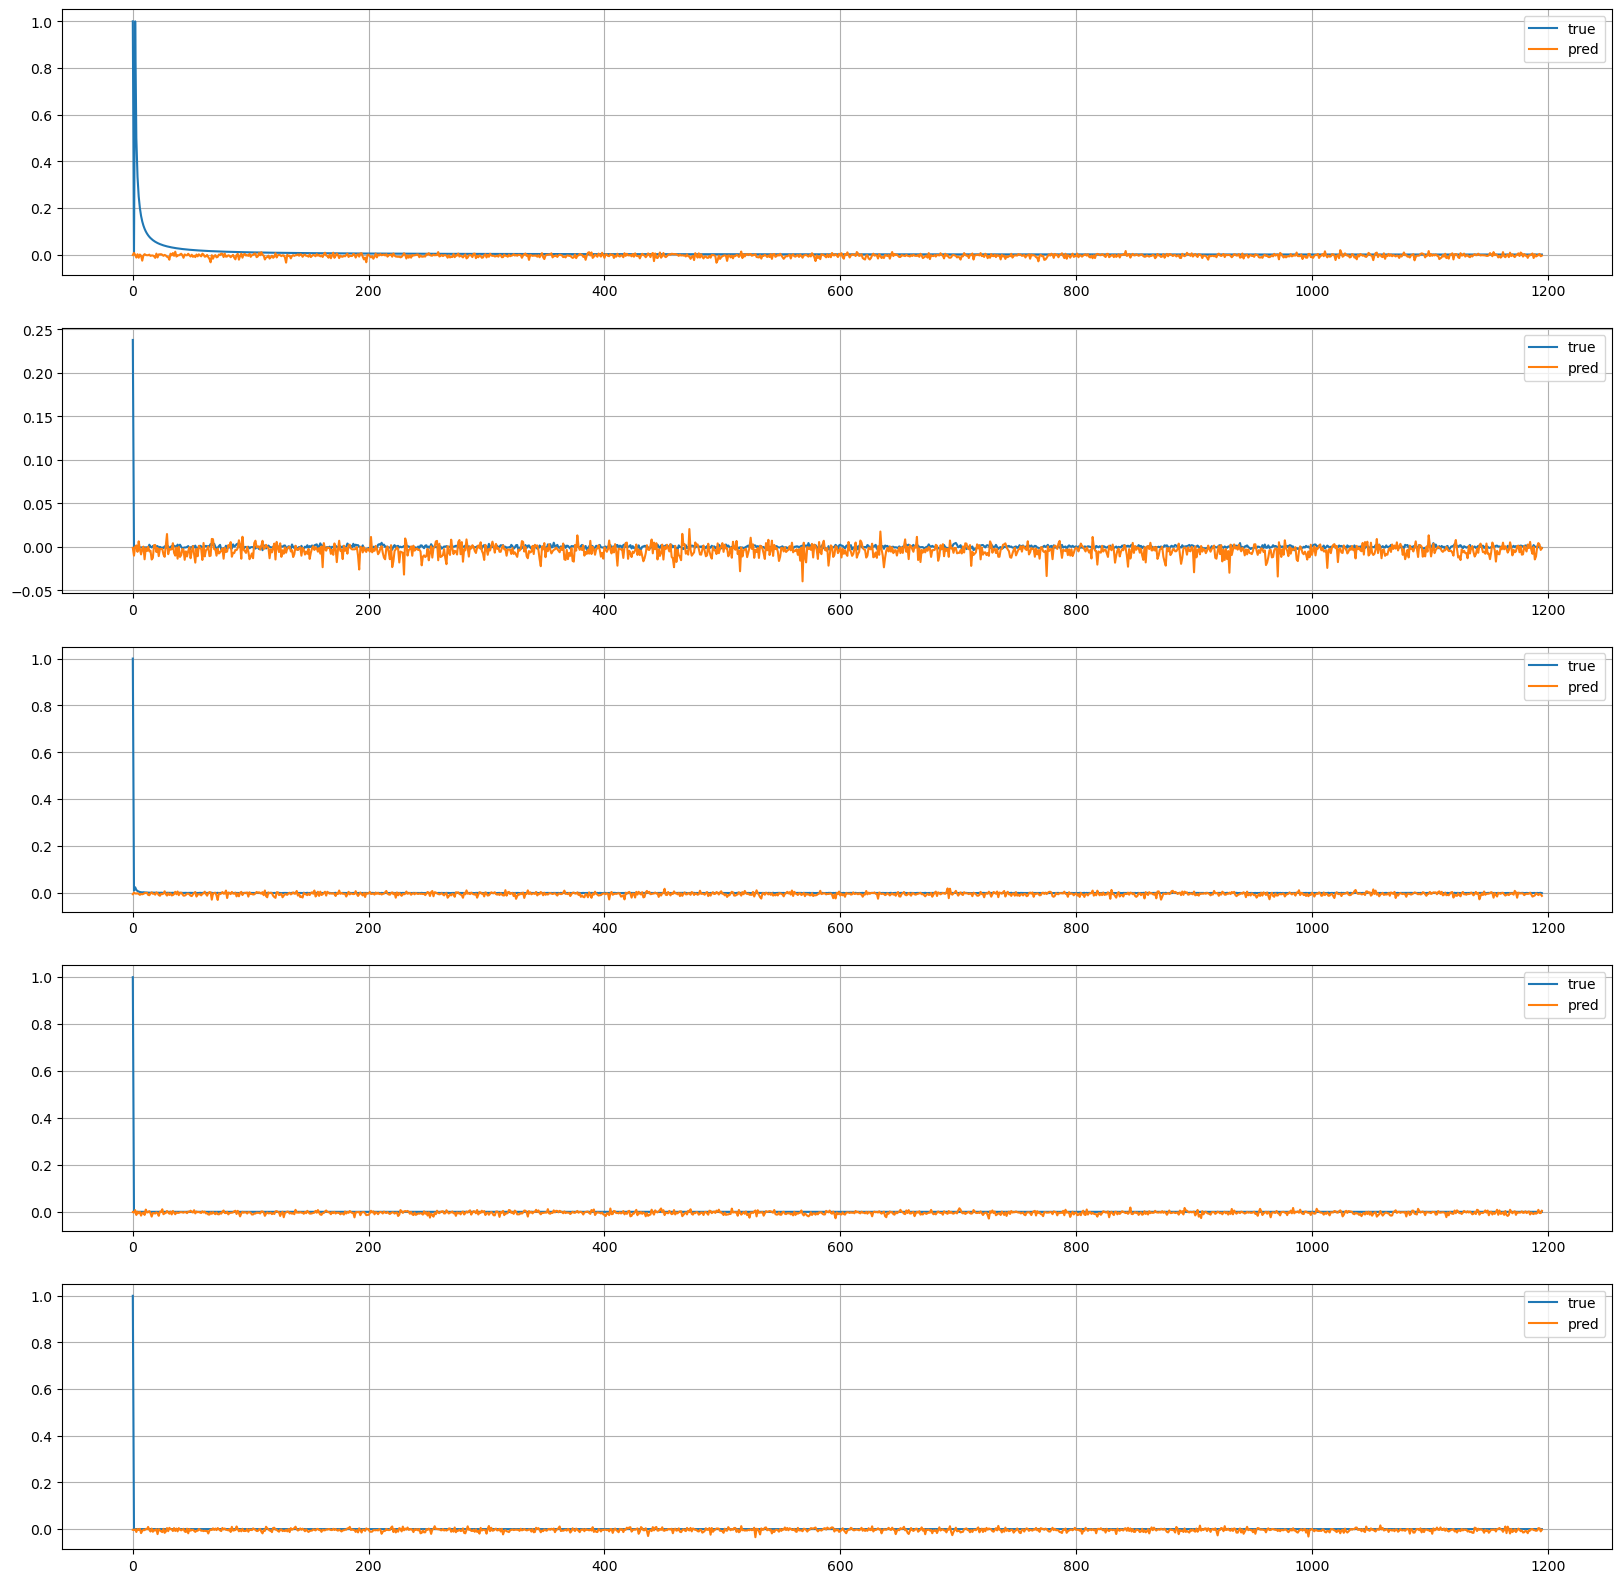

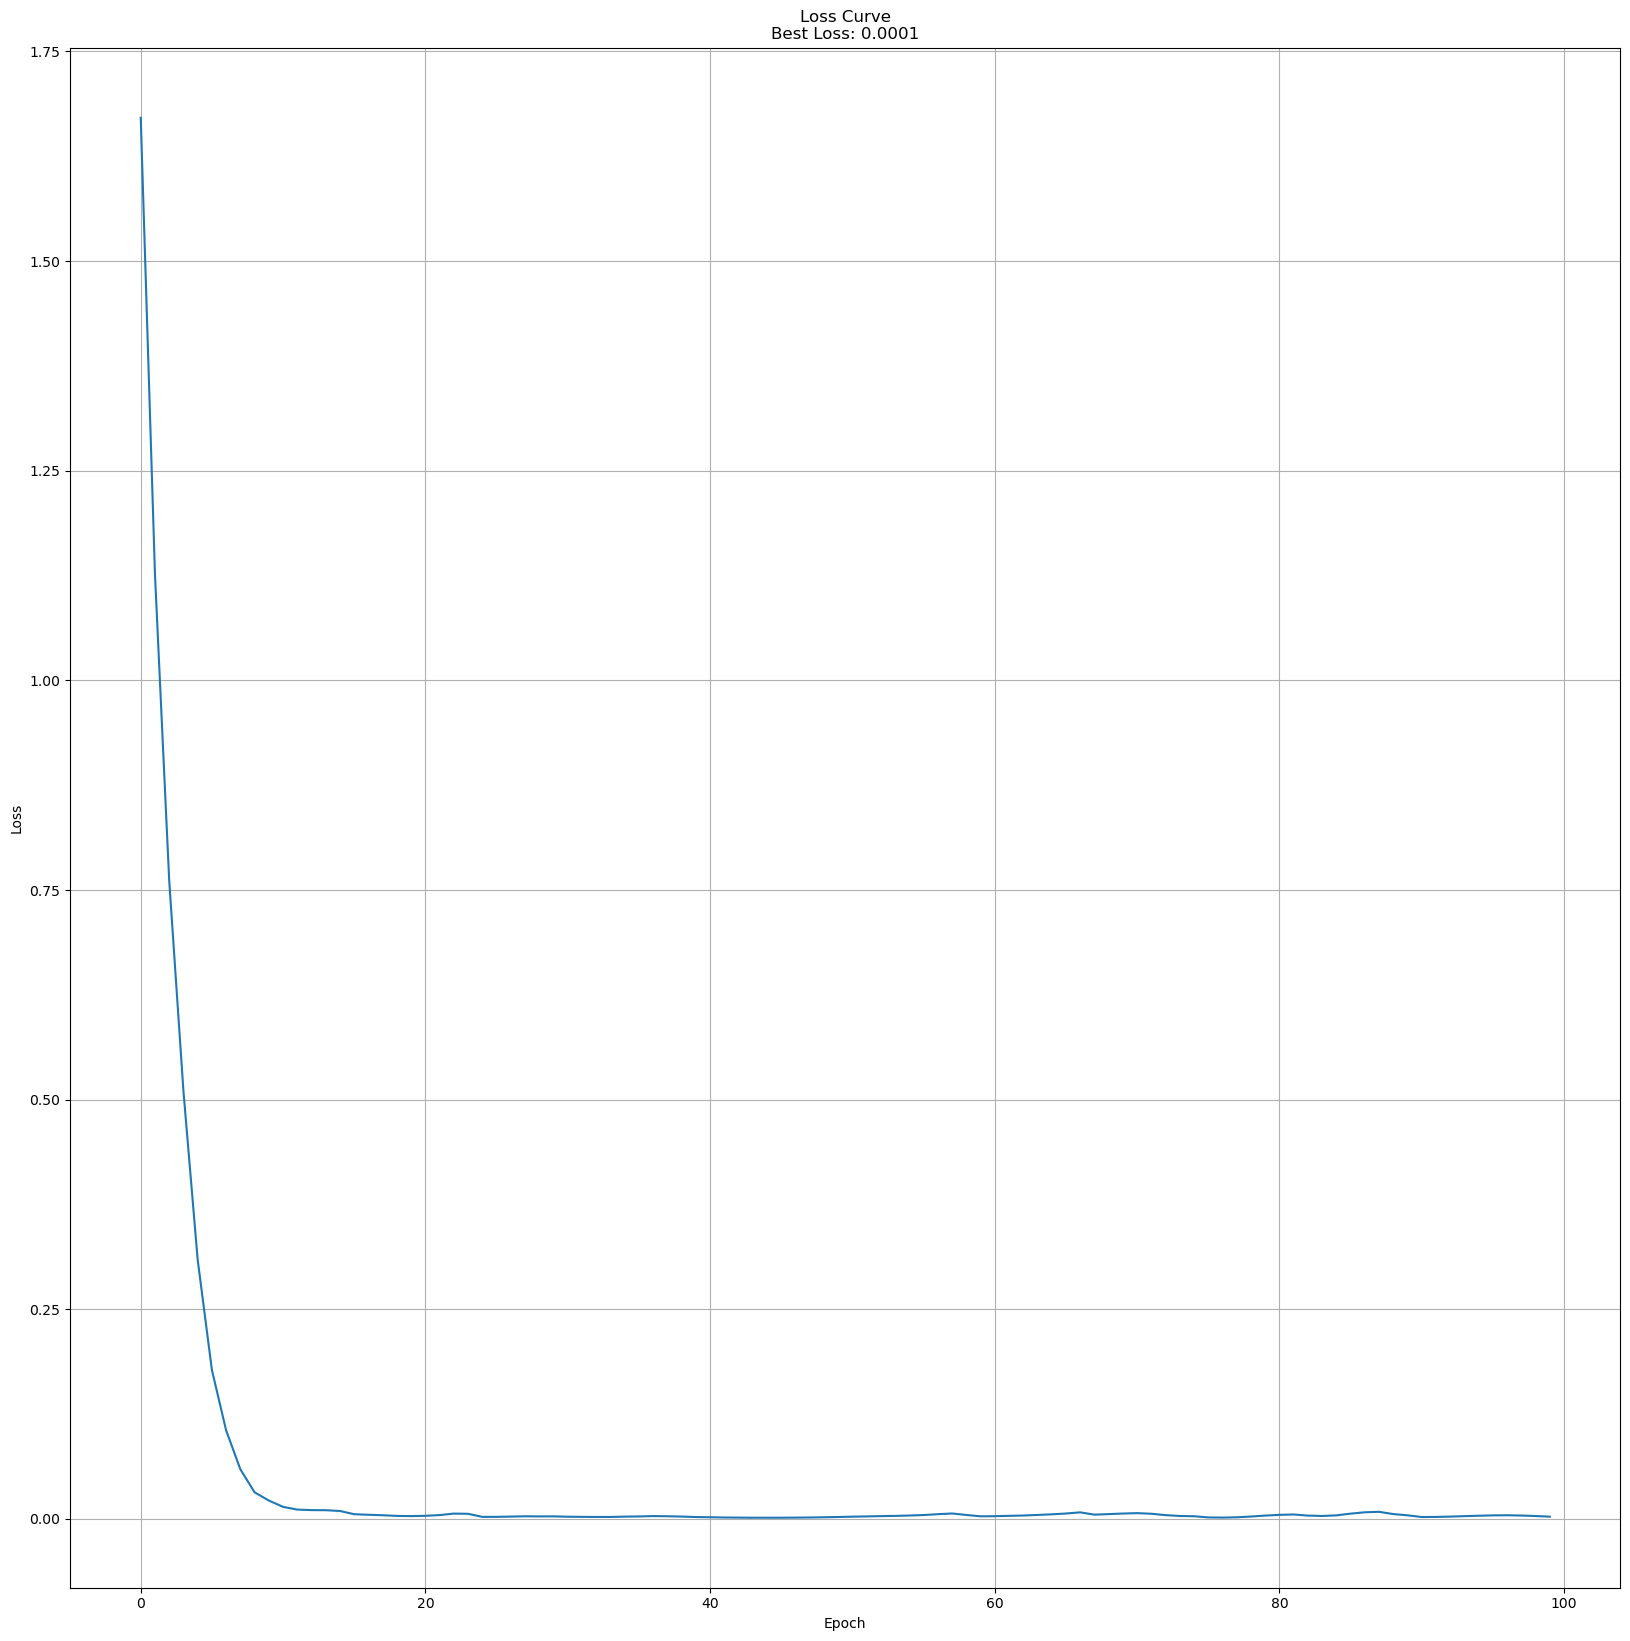

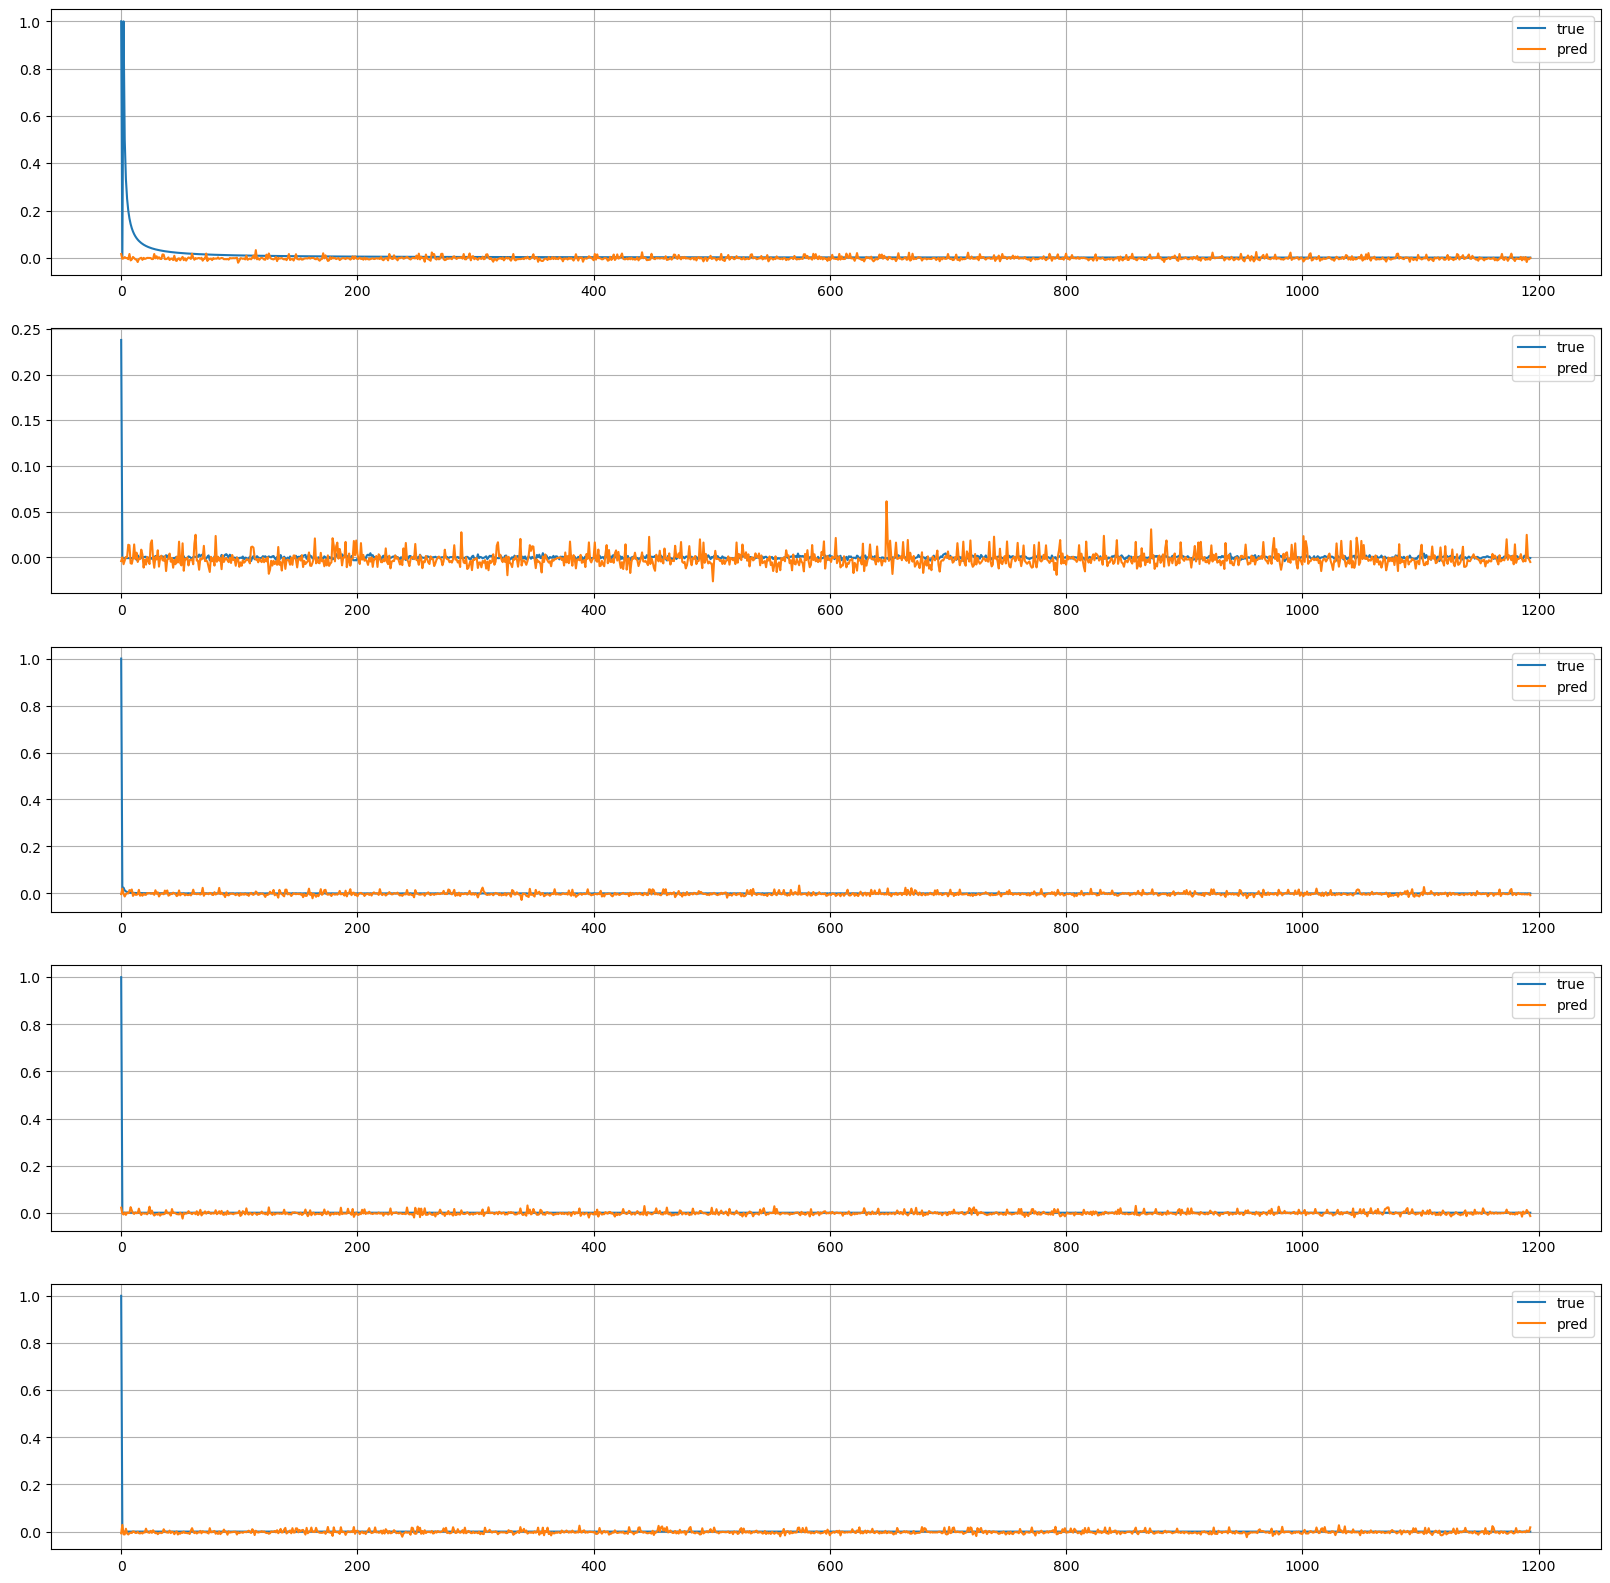

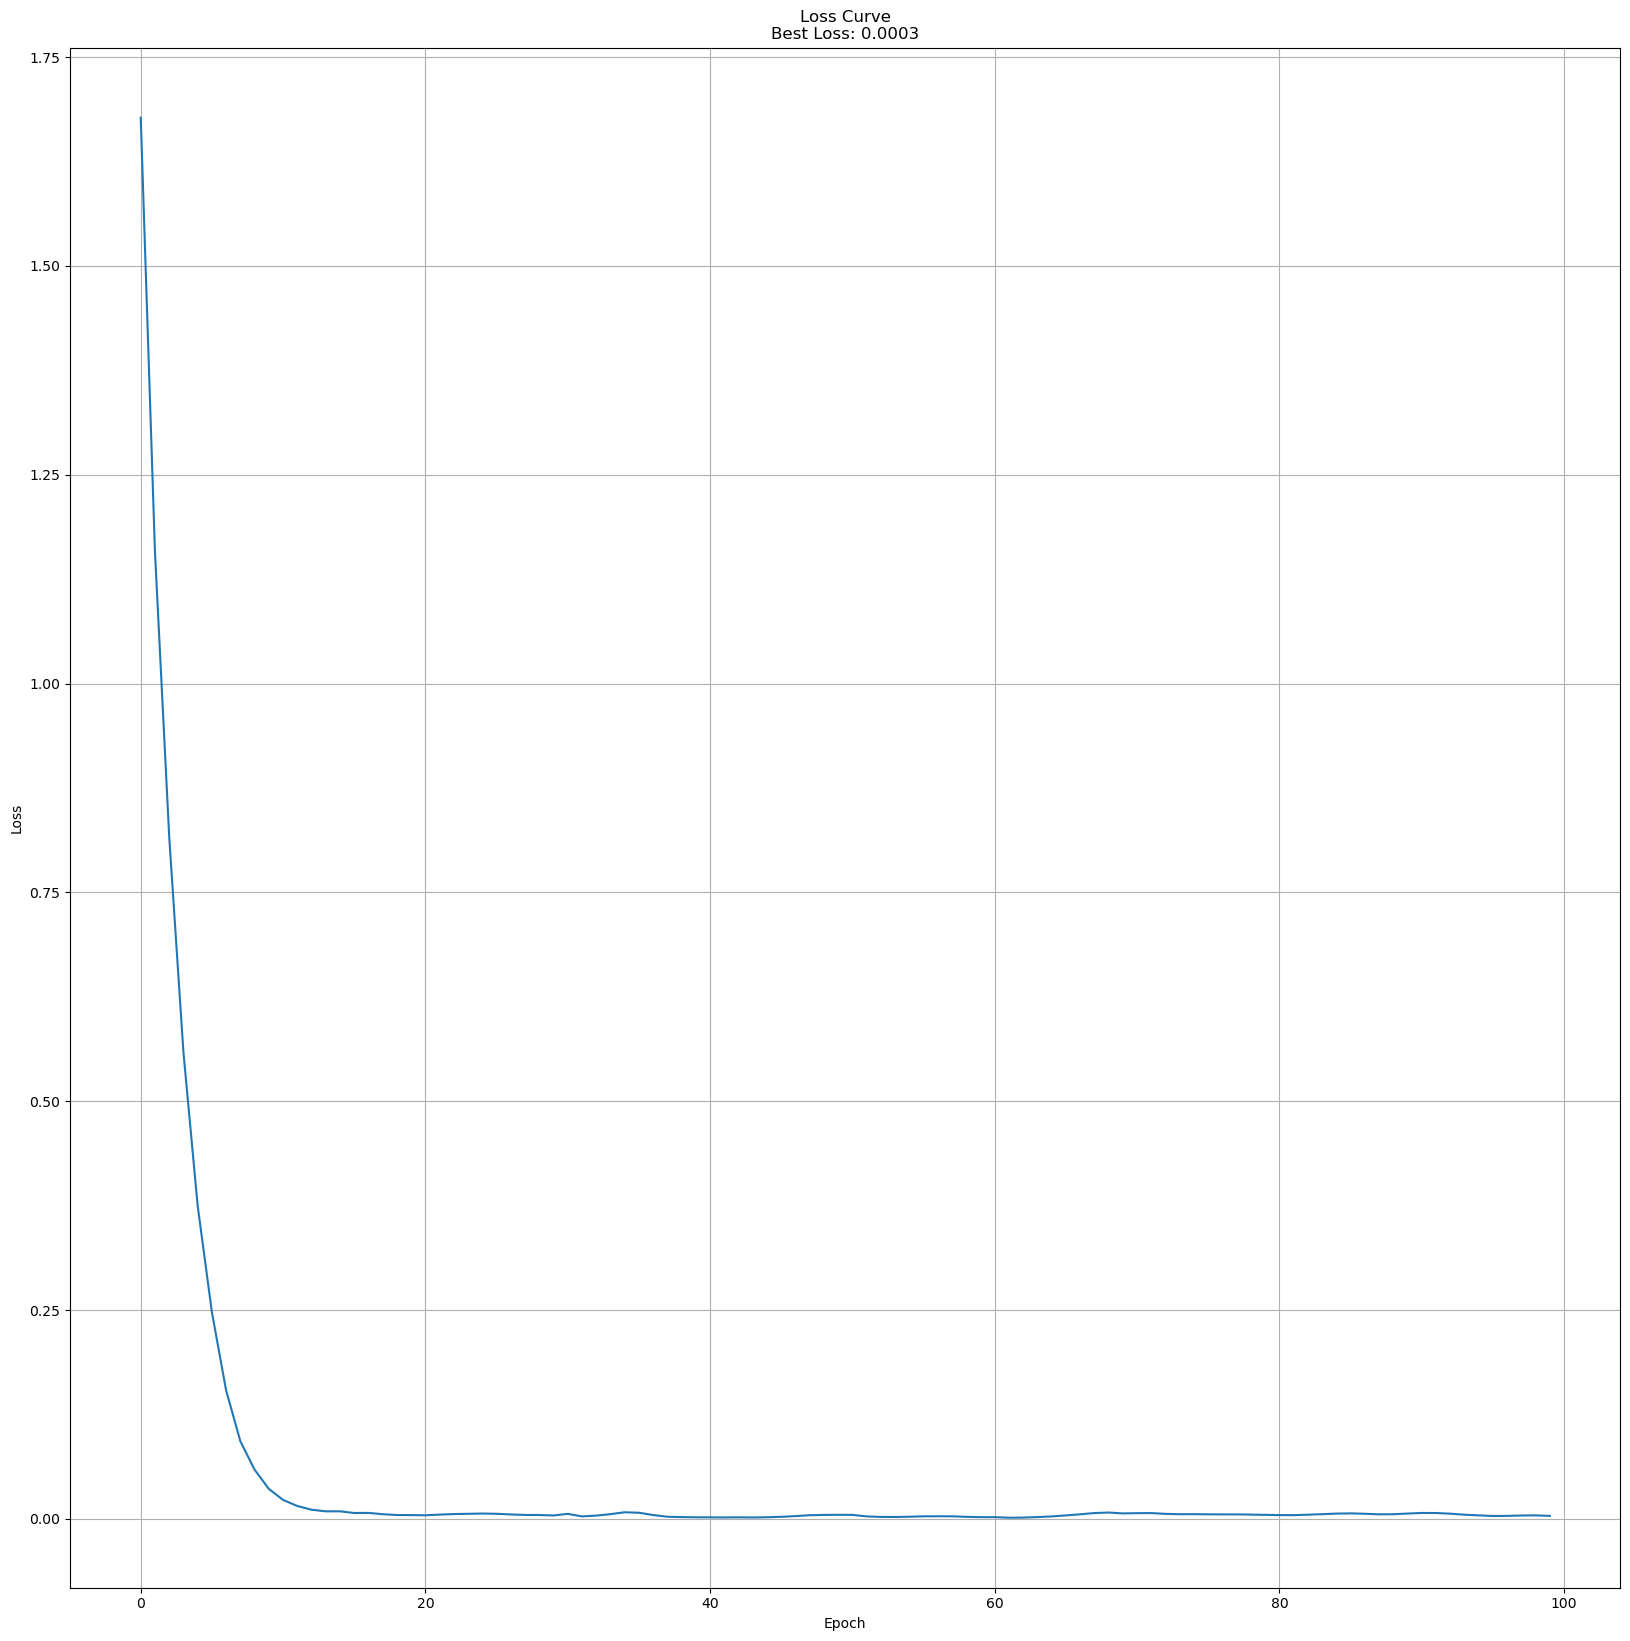

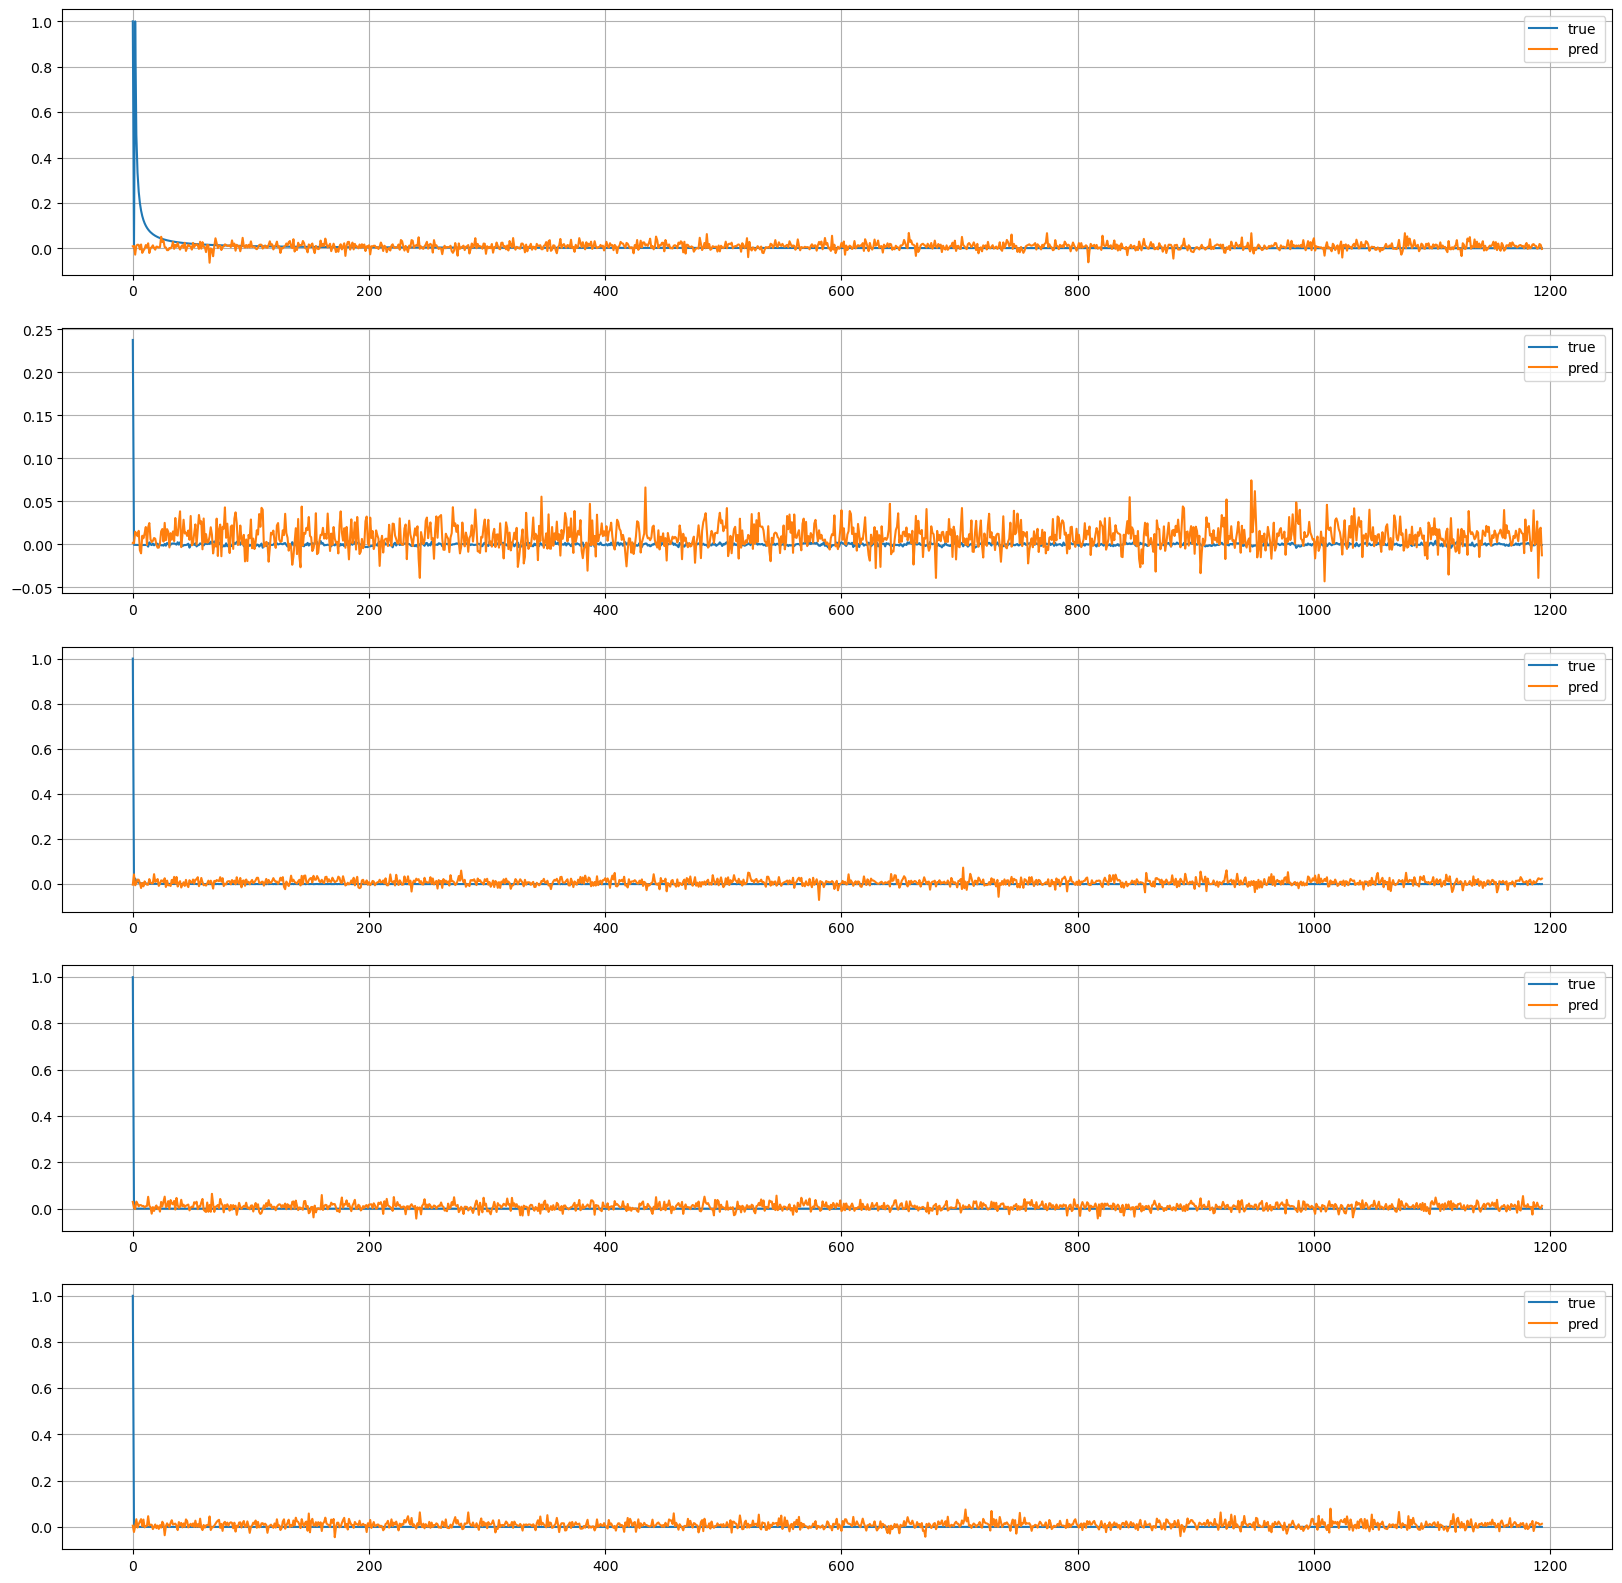

In [18]:
for supertype in ['iTransformer', 'GPT', 'BERT', 'Transformer']:
    mpg = ParamGrid({
    'd_model': [6,8],
    'n_layers': [12, 96],
})
    for params in mpg.grid:
        d = params['d_model']
        l = params['n_layers']
        savedir = f'neuro/models/v5/{supertype}/d{d}_l{l}_ksmoothed_deltas'

        if supertype == 'iTransformer':
            model = MyITransformer(
                n_layers=l,
                d_model=d,
                num_variates=5,
                dim=32,
                dim_head=4
            )
            model.to(model.device)
        else:
            if supertype == 'GPT':
                config = dict(d_model=d, n_encoders=0, n_decoders=l)
            elif supertype == 'BERT':
                config = dict(d_model=d, n_encoders=l, n_decoders=0)
            elif supertype == 'Transformer':
                config = dict(d_model=d, n_encoders=l//2, n_decoders=l//2)
            else:
                continue
            model = MyTransformer(**config)
        hist = model.fit(prepared_data, epochs=100, batch_size=64, savedir=savedir)
        model.load_state_dict(torch.load(os.path.join(savedir, 'best.pt'), weights_only=True))
        model.test(dataset1[0], contexts[0], savedir=savedir)
        print(savedir)

In [ ]:
for supertype in ['iTransformer']:
    mpg = ParamGrid({
    'd_model': [6,8],
    'n_layers': [4, 12],
})
    for params in mpg.grid:
        d = params['d_model']
        l = params['n_layers']

        savedir = f'neuro/models/v5/{supertype}/d{d}_l{l}_ksmoothed'
        model = MyITransformer(
            n_layers=l,
            d_model=d,
            num_variates=5,
            dim=32,
            dim_head=4
        )
        model.to(model.device)
        # hist = model.fit(prepared_data, epochs=100, batch_size=256, savedir=savedir)
        model.load_state_dict(torch.load(os.path.join(savedir, 'best.pt'), weights_only=True))
        model.test(scaled[0], contexts[0], savedir=savedir)
        print(savedir)